# 📋 TaxoClass: Hierarchical Text Classification with Self-Training

## Step 1: 환경 설정 🔧

필요한 라이브러리를 설치하고 Google Drive를 마운트합니다.

In [60]:
# 라이브러리 설치
!pip install -q sentence-transformers
!pip install -q torch
!pip install -q plotly
!pip install -q scikit-learn

In [ ]:
# Google Drive 마운트 (Colab 전용)
# 🔹 로컬 환경에서 실행 시 이 셀을 건너뛰세요

try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive 마운트 완료!")
except:
    print("⚠️ Colab이 아닌 환경입니다. 로컬 경로를 사용하세요.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive 마운트 완료!


In [62]:
# 필요한 라이브러리 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
from collections import defaultdict, Counter
import warnings
import random
warnings.filterwarnings('ignore')

# Random seed 설정 (재현성 확보)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ 라이브러리 로드 완료!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"🎲 Random seed: 42 (고정)")

✅ 라이브러리 로드 완료!
PyTorch version: 2.9.0+cu126
CUDA available: True
🎲 Random seed: 42 (고정)


## Step 2: 데이터 로드 📂

Amazon Products 데이터셋을 로드합니다.
- 클래스 정보 (531개)
- 계층 구조 (568개 관계)
- 키워드 정보
- 학습/테스트 문서 (전체 데이터)

In [ ]:
# 데이터셋 경로 설정
# 🔹 Google Colab 사용 시: 아래 경로 사용 (기본값)
BASE_PATH = '/content/drive/MyDrive/Amazon_products'

# 🔹 로컬 환경 사용 시: 아래 주석을 해제하고 위 줄을 주석처리
# BASE_PATH = './data/raw/Amazon_products'

CLASSES_PATH = f'{BASE_PATH}/classes.txt'
HIERARCHY_PATH = f'{BASE_PATH}/class_hierarchy.txt'
KEYWORDS_PATH = f'{BASE_PATH}/class_related_keywords.txt'
TRAIN_CORPUS_PATH = f'{BASE_PATH}/train/train_corpus.txt'
TEST_CORPUS_PATH = f'{BASE_PATH}/test/test_corpus.txt'

print(f"📁 데이터셋 경로: {BASE_PATH}")
print(f"✅ 경로 설정 완료!")

📁 데이터셋 경로: /content/drive/MyDrive/Amazon_products
✅ 경로 설정 완료!


In [64]:
# 1. 클래스 정보 로드
classes_dict = {}  # {class_id: class_name}
with open(CLASSES_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            class_id, class_name = parts
            classes_dict[int(class_id)] = class_name

print(f"✅ 클래스 로드 완료: {len(classes_dict)}개")
print(f"   예시: {list(classes_dict.items())[:3]}")

✅ 클래스 로드 완료: 531개
   예시: [(0, 'grocery_gourmet_food'), (1, 'meat_poultry'), (2, 'jerky')]


In [65]:
# 2. 계층 구조 로드
hierarchy = []
parent_to_children = defaultdict(list)  # {parent_id: [child_ids]}
child_to_parents = defaultdict(list)     # {child_id: [parent_ids]}

with open(HIERARCHY_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            parent_id, child_id = map(int, parts)
            hierarchy.append((parent_id, child_id))
            parent_to_children[parent_id].append(child_id)
            child_to_parents[child_id].append(parent_id)

# 루트 클래스 찾기 (부모가 없는 클래스)
all_class_ids = set(classes_dict.keys())
children_ids = set(child_to_parents.keys())
root_classes = all_class_ids - children_ids

print(f"✅ 계층 구조 로드 완료: {len(hierarchy)}개 관계")
print(f"   루트 클래스: {len(root_classes)}개")
print(f"   리프 클래스: {len(all_class_ids - set(parent_to_children.keys()))}개")

✅ 계층 구조 로드 완료: 568개 관계
   루트 클래스: 6개
   리프 클래스: 462개


In [66]:
# 3. 클래스 관련 키워드 로드
# 먼저 클래스 이름 -> 클래스 ID 매핑 생성
name_to_id = {name: cid for cid, name in classes_dict.items()}

keywords_dict = {}  # {class_id: [keywords]}

with open(KEYWORDS_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split(':')
        if len(parts) == 2:
            class_name = parts[0].strip()
            keywords = parts[1].split(',')

            # 클래스 이름으로 ID 찾기
            if class_name in name_to_id:
                class_id = name_to_id[class_name]
                keywords_dict[class_id] = [kw.strip() for kw in keywords if kw.strip()]

print(f"✅ 키워드 로드 완료: {len(keywords_dict)}개 클래스")
if keywords_dict:
    print(f"   평균 키워드 수: {np.mean([len(kws) for kws in keywords_dict.values()]):.1f}개")
else:
    print(f"   평균 키워드 수: 0개")

✅ 키워드 로드 완료: 531개 클래스
   평균 키워드 수: 9.9개


In [67]:
# 4. 훈련 문서 로드
train_docs = []
with open(TRAIN_CORPUS_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        text = line.strip()
        if text:
            train_docs.append(text)

print(f"✅ 훈련 문서 로드 완료: {len(train_docs):,}개")
print(f"   평균 문서 길이: {np.mean([len(doc) for doc in train_docs]):.1f}자")

✅ 훈련 문서 로드 완료: 29,487개
   평균 문서 길이: 478.1자


In [68]:
# 5. 테스트 문서 로드
test_docs = []
with open(TEST_CORPUS_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        text = line.strip()
        if text:
            test_docs.append(text)

print(f"✅ 테스트 문서 로드 완료: {len(test_docs):,}개")
print(f"   평균 문서 길이: {np.mean([len(doc) for doc in test_docs]):.1f}자")

✅ 테스트 문서 로드 완료: 19,658개
   평균 문서 길이: 478.6자


In [69]:
# 6. 데이터 요약 통계
print("=" * 60)
print("📊 데이터셋 요약")
print("=" * 60)
print(f"클래스 수: {len(classes_dict):,}개")
print(f"계층 관계: {len(hierarchy):,}개")
print(f"루트 클래스: {len(root_classes)}개")
print(f"리프 클래스: {len(all_class_ids - set(parent_to_children.keys()))}개")
print(f"키워드가 있는 클래스: {len(keywords_dict):,}개")
print(f"\n훈련 문서: {len(train_docs):,}개")
print(f"테스트 문서: {len(test_docs):,}개")
print(f"전체 문서: {len(train_docs) + len(test_docs):,}개")

# ⭐ Train + Test 통합 (둘 다 unlabeled이므로)
print("\n🔗 Train + Test 통합 중...")
all_docs = train_docs + test_docs
train_size = len(train_docs)  # Train 영역 경계 저장 (validation 분할용)
print(f"✅ 통합 완료: {len(all_docs):,}개 문서")
print(f"   - Train 영역: 0 ~ {train_size-1} (validation 추출용)")
print(f"   - Test 영역: {train_size} ~ {len(all_docs)-1}")
print("=" * 60)

# 루트 클래스 몇 개 출력
print(f"\n루트 클래스 예시:")
for root_id in list(root_classes)[:5]:
    print(f"  - [{root_id}] {classes_dict[root_id]}")

# 문서 샘플 출력
print(f"\n통합 문서 샘플:")
for i, doc in enumerate(all_docs[:3]):
    print(f"  {i+1}. {doc[:100]}..." if len(doc) > 100 else f"  {i+1}. {doc}")

📊 데이터셋 요약
클래스 수: 531개
계층 관계: 568개
루트 클래스: 6개
리프 클래스: 462개
키워드가 있는 클래스: 531개

훈련 문서: 29,487개
테스트 문서: 19,658개
전체 문서: 49,145개

🔗 Train + Test 통합 중...
✅ 통합 완료: 49,145개 문서
   - Train 영역: 0 ~ 29486 (validation 추출용)
   - Test 영역: 29487 ~ 49144

루트 클래스 예시:
  - [0] grocery_gourmet_food
  - [3] toys_games
  - [40] baby_products
  - [169] pet_supplies
  - [10] beauty

통합 문서 샘플:
  1. 0	omron hem 790it automatic blood pressure monitor with advanced omron health management software so...
  2. 1	natural factors whey factors chocolate works well , but there is a lot of dead space in the contai...
  3. 2	clif bar builder 's bar , 2 . 4 ounce bars i love the peanut butter builder 's bars . while amazon...


## Step 3: 유사 문서(Pseudo-Document) 생성

계층 정보를 활용하여 각 클래스에 대한 유사 문서를 생성합니다.

In [70]:
def create_enhanced_pseudo_document(class_id, classes_dict, keywords_dict,
                                     parent_to_children, child_to_parents):
    """
    계층 정보를 활용한 향상된 유사 문서 생성

    TaxoClass 논문의 방법론:
    - 클래스 이름
    - 관련 키워드
    - 부모 클래스 정보 (계층 컨텍스트)
    - 자식 클래스 정보 (하위 카테고리 힌트)
    """
    parts = []

    # 1. 클래스 이름 (가장 중요)
    class_name = classes_dict[class_id]
    parts.append(f"Category: {class_name}")

    # 2. 관련 키워드
    if class_id in keywords_dict and keywords_dict[class_id]:
        keywords = ", ".join(keywords_dict[class_id])
        parts.append(f"Keywords: {keywords}")

    # 3. 부모 클래스 (계층 상위 정보)
    if class_id in child_to_parents:
        parent_ids = child_to_parents[class_id]
        parent_names = [classes_dict[pid] for pid in parent_ids]
        parts.append(f"Parent categories: {', '.join(parent_names)}")

    # 4. 자식 클래스 (계층 하위 정보)
    if class_id in parent_to_children:
        children_ids = parent_to_children[class_id]
        # 자식이 너무 많으면 상위 5개만
        children_names = [classes_dict[cid] for cid in children_ids[:5]]
        if len(children_ids) > 5:
            children_names.append(f"and {len(children_ids) - 5} more")
        parts.append(f"Subcategories: {', '.join(children_names)}")

    return " | ".join(parts)

# 모든 클래스에 대한 유사 문서 생성
print("🔨 유사 문서 생성 중...")
pseudo_documents = {}

for class_id in classes_dict.keys():
    pseudo_doc = create_enhanced_pseudo_document(
        class_id, classes_dict, keywords_dict,
        parent_to_children, child_to_parents
    )
    pseudo_documents[class_id] = pseudo_doc

print(f"✅ 유사 문서 생성 완료: {len(pseudo_documents):,}개")

# 샘플 출력
print(f"\n유사 문서 샘플:")
for i, (class_id, pseudo_doc) in enumerate(list(pseudo_documents.items())[:3]):
    print(f"\n[{class_id}] {classes_dict[class_id]}")
    print(f"  {pseudo_doc}")

🔨 유사 문서 생성 중...
✅ 유사 문서 생성 완료: 531개

유사 문서 샘플:

[0] grocery_gourmet_food
  Category: grocery_gourmet_food | Keywords: snacks, condiments, beverages, specialty_foods, spices, cooking_oils, baking_ingredients, gourmet_chocolates, artisanal_cheeses, organic_foods | Subcategories: meat_poultry, beverages, gourmet_gifts, sauces_dips, breakfast_foods, and 11 more

[1] meat_poultry
  Category: meat_poultry | Keywords: butcher, cuts, marination, grilling, roasting, seasoning, halal, organic, deli, marbling | Parent categories: grocery_gourmet_food | Subcategories: jerky, p_t_s, seafood, exotic_meats, sausages, and 2 more

[2] jerky
  Category: jerky | Keywords: beef, turkey, chicken, venison, buffalo, kangaroo, elk, ostrich, bison, spicy | Parent categories: meat_poultry


## Step 4: 임베딩 및 유사도 계산

BAAI/bge-large-en-v1.5 모델을 사용하여 문서와 클래스 간 유사도를 계산합니다.

In [71]:
# 1. 모델 로드
print("🔧 BAAI/bge-large-en-v1.5 모델 로드 중...")
model = SentenceTransformer('BAAI/bge-large-en-v1.5')
print(f"✅ 모델 로드 완료 (임베딩 차원: {model.get_sentence_embedding_dimension()})")

🔧 BAAI/bge-large-en-v1.5 모델 로드 중...
✅ 모델 로드 완료 (임베딩 차원: 1024)


In [72]:
# 2. 유사 문서 임베딩
print("🔨 유사 문서 임베딩 생성 중...")

class_ids_list = list(pseudo_documents.keys())
pseudo_docs_list = [pseudo_documents[cid] for cid in class_ids_list]

# 배치 처리로 효율적인 임베딩
pseudo_embeddings = model.encode(
    pseudo_docs_list,
    batch_size=32,
    show_progress_bar=True,
    convert_to_tensor=True
)

print(f"✅ 유사 문서 임베딩 완료: {pseudo_embeddings.shape}")

🔨 유사 문서 임베딩 생성 중...


✅ 유사 문서 임베딩 완료: torch.Size([531, 1024])


In [73]:
import torch
import os

BASE_PATH = "/content/drive/MyDrive/Amazon_products"
TRAIN_EMB_PATH = os.path.join(BASE_PATH, "embeddings_output/all_docs_embeddings.pt")

# 임베딩 로드 또는 생성
if os.path.exists(TRAIN_EMB_PATH):
    print(f"📂 저장된 임베딩 로드 중: {TRAIN_EMB_PATH}")
    train_embeddings = torch.load(TRAIN_EMB_PATH, map_location="cuda" if torch.cuda.is_available() else "cpu")

    # dict로 저장된 경우 대비
    if isinstance(train_embeddings, dict):
        train_embeddings = train_embeddings["embeddings"]

    print(f"✅ 임베딩 로드 완료: {train_embeddings.shape}")
else:
    print(f"🔢 Train + Test 전체 문서 임베딩 생성 중...")
    print(f"   문서 수: {len(all_docs):,}개")

    # 배치 처리로 임베딩 생성
    train_embeddings = model.encode(
        all_docs,
        batch_size=32,
        show_progress_bar=True,
        convert_to_tensor=True
    )

    print(f"✅ 임베딩 생성 완료: {train_embeddings.shape}")

    # 구글 드라이브에 저장
    print(f"\n💾 임베딩 저장 중: {TRAIN_EMB_PATH}")
    os.makedirs(os.path.dirname(TRAIN_EMB_PATH), exist_ok=True)
    torch.save(train_embeddings.cpu(), TRAIN_EMB_PATH)
    print("✅ 저장 완료!")

    # GPU로 다시 이동
    if torch.cuda.is_available():
        train_embeddings = train_embeddings.cuda()

print(f"\n📊 임베딩 정보:")
print(f"  - Shape: {train_embeddings.shape}")
print(f"  - Train 영역: [:{train_size}]")
print(f"  - Test 영역: [{train_size}:]")

📂 저장된 임베딩 로드 중: /content/drive/MyDrive/Amazon_products/embeddings_output/all_docs_embeddings.pt
✅ 임베딩 로드 완료: torch.Size([49145, 1024])

📊 임베딩 정보:
  - Shape: torch.Size([49145, 1024])
  - Train 영역: [:29487]
  - Test 영역: [29487:]


In [74]:
# 4. 코사인 유사도 계산
print("🔨 유사도 행렬 계산 중...")

from torch.nn.functional import normalize
import torch

# L2 정규화
train_embeddings_norm = normalize(train_embeddings, p=2, dim=1)
pseudo_embeddings_norm = normalize(pseudo_embeddings, p=2, dim=1)

# 유사도 행렬 계산: (num_docs, num_classes)
similarity_matrix = torch.mm(train_embeddings_norm, pseudo_embeddings_norm.T)

print(f"✅ 유사도 행렬 계산 완료: {similarity_matrix.shape}")
print(f"   유사도 범위: [{similarity_matrix.min():.4f}, {similarity_matrix.max():.4f}]")
print(f"   평균 유사도: {similarity_matrix.mean():.4f}")

🔨 유사도 행렬 계산 중...
✅ 유사도 행렬 계산 완료: torch.Size([49145, 531])
   유사도 범위: [0.2262, 0.8090]
   평균 유사도: 0.4401


In [75]:
# 5. Top-K 후보 클래스 추출
print("🔨 각 문서별 Top-K 후보 클래스 추출 중...")

K = 10  # 상위 10개 후보 클래스

# 각 문서별 상위 K개 클래스 인덱스와 유사도
top_k_values, top_k_indices = torch.topk(similarity_matrix, K, dim=1)

# numpy로 변환
top_k_values_np = top_k_values.cpu().numpy()
top_k_indices_np = top_k_indices.cpu().numpy()

print(f"✅ Top-{K} 후보 추출 완료")
print(f"   문서당 후보: {K}개")
print(f"   평균 Top-1 유사도: {top_k_values_np[:, 0].mean():.4f}")
print(f"   평균 Top-{K} 유사도: {top_k_values_np[:, -1].mean():.4f}")

🔨 각 문서별 Top-K 후보 클래스 추출 중...
✅ Top-10 후보 추출 완료
   문서당 후보: 10개
   평균 Top-1 유사도: 0.5955
   평균 Top-10 유사도: 0.5372


## Step 5: Core Class Mining (핵심 클래스 추출)

TaxoClass 논문의 핵심: 계층 정보를 활용하여 문서의 핵심 클래스를 추출합니다.

In [76]:
def get_ancestors(class_id, child_to_parents, max_depth=10):
    """클래스의 모든 조상(상위 클래스) 찾기"""
    ancestors = set()
    queue = [class_id]
    depth = 0

    while queue and depth < max_depth:
        current_level = []
        for cid in queue:
            if cid in child_to_parents:
                parents = child_to_parents[cid]
                for p in parents:
                    if p not in ancestors:
                        ancestors.add(p)
                        current_level.append(p)
        queue = current_level
        depth += 1

    return ancestors

def get_descendants(class_id, parent_to_children, max_depth=10):
    """클래스의 모든 자손(하위 클래스) 찾기"""
    descendants = set()
    queue = [class_id]
    depth = 0

    while queue and depth < max_depth:
        current_level = []
        for cid in queue:
            if cid in parent_to_children:
                children = parent_to_children[cid]
                for c in children:
                    if c not in descendants:
                        descendants.add(c)
                        current_level.append(c)
        queue = current_level
        depth += 1

    return descendants

def core_class_mining(doc_idx, top_k_indices, top_k_values, class_ids_list,
                      parent_to_children, child_to_parents,
                      threshold=0.3, alpha=0.7, core_threshold=0.4):
    """
    TaxoClass의 Core Class Set Mining (논문 방식)

    Args:
        doc_idx: 문서 인덱스
        top_k_indices: Top-K 클래스 인덱스 배열
        top_k_values: Top-K 유사도 값 배열
        class_ids_list: 클래스 ID 리스트
        parent_to_children: 부모-자식 관계
        child_to_parents: 자식-부모 관계
        threshold: 최소 유사도 임계값 (후보 필터링)
        alpha: 조상/자손 패널티 가중치
        core_threshold: Core class로 선택될 최소 조정 점수

    Returns:
        core_classes: 핵심 클래스 집합 (list, 점수 순)
        core_scores: 각 클래스의 조정된 점수 (dict)
    """
    # Top-K 후보 클래스와 유사도
    candidates = []
    for idx, sim in zip(top_k_indices[doc_idx], top_k_values[doc_idx]):
        class_id = class_ids_list[idx]
        if sim >= threshold:
            candidates.append((class_id, sim))

    if not candidates:
        # 임계값 이상이 없으면 Top-1만 반환
        idx = top_k_indices[doc_idx][0]
        class_id = class_ids_list[idx]
        return [class_id], {class_id: top_k_values[doc_idx][0]}

    # 각 후보에 대해 조정된 점수 계산
    adjusted_scores = {}

    for class_id, sim in candidates:
        # 기본 유사도 점수
        score = sim

        # 다른 후보들과의 계층 관계 고려
        penalty = 0
        for other_id, other_sim in candidates:
            if class_id == other_id:
                continue

            # class_id가 other_id의 조상이면 패널티
            ancestors = get_ancestors(other_id, child_to_parents)
            if class_id in ancestors:
                penalty += alpha * (other_sim - sim)

            # class_id가 other_id의 자손이면 보너스
            descendants = get_descendants(other_id, parent_to_children)
            if class_id in descendants:
                penalty -= alpha * (sim - other_sim)

        adjusted_scores[class_id] = score - penalty

    # Core class set 선택: 조정된 점수가 threshold 이상인 모든 클래스
    core_classes = []
    core_scores = {}

    for class_id, score in adjusted_scores.items():
        if score >= core_threshold:
            core_classes.append(class_id)
            core_scores[class_id] = score

    # 점수 순으로 정렬
    core_classes.sort(key=lambda x: core_scores[x], reverse=True)

    # 최소 1개는 보장 (가장 높은 점수)
    if not core_classes:
        best_class = max(adjusted_scores, key=adjusted_scores.get)
        core_classes = [best_class]
        core_scores = {best_class: adjusted_scores[best_class]}

    return core_classes, core_scores

print("✅ Core Class Mining 함수 정의 완료")

✅ Core Class Mining 함수 정의 완료


## ⚠️ 중요: Core Class Set 품질 관리

**현재 문제점:**
1. 평균 9개의 core class는 너무 많음 (논문: 1-3개)
2. 이질적인 클래스 혼재 시 노이즈 발생
3. 해결책: 더 엄격한 필터링 + 계층 일관성 검증

**TaxoClass 논문의 접근:**
- **GNN**: 계층 구조를 그래프로 명시적 모델링
- **Core Class Mining**: 계층적으로 일관된 클래스만 선택
- **Consistency Check**: 공통 조상이 없는 클래스는 제거

In [77]:
def find_common_ancestor(class_ids, child_to_parents):
    """
    여러 클래스의 공통 조상 찾기 (계층 일관성 검증)
    """
    if len(class_ids) <= 1:
        return True  # 단일 클래스는 항상 일관적

    # 각 클래스의 모든 조상 찾기
    all_ancestors = []
    for cid in class_ids:
        ancestors = get_ancestors(cid, child_to_parents)
        all_ancestors.append(ancestors)

    # 공통 조상이 있는지 확인
    if not all_ancestors:
        return True

    common = set.intersection(*all_ancestors) if all_ancestors else set()

    # 공통 조상이 있거나, 한 클래스가 다른 클래스의 조상이면 OK
    if common:
        return True

    # 한 클래스가 다른 클래스들의 조상인지 확인
    for i, cid in enumerate(class_ids):
        if any(cid in all_ancestors[j] for j in range(len(class_ids)) if j != i):
            return True

    return False

def filter_inconsistent_classes(core_classes, core_scores, child_to_parents, max_classes=5):
    """
    계층적으로 일관되지 않은 클래스 제거

    Args:
        core_classes: 후보 클래스 리스트 (점수 순)
        core_scores: 각 클래스의 점수 dict
        child_to_parents: 계층 관계
        max_classes: 최대 core class 개수

    Returns:
        filtered_classes: 필터링된 클래스 리스트
        filtered_scores: 필터링된 점수 dict
    """
    if len(core_classes) <= 1:
        return core_classes, core_scores

    # 점수 순으로 정렬 (이미 정렬되어 있지만 확실히)
    sorted_classes = sorted(core_classes, key=lambda x: core_scores[x], reverse=True)

    # Greedy selection: 점수 높은 것부터 추가하되, 일관성 유지
    filtered = [sorted_classes[0]]  # 최고 점수는 무조건 포함

    for candidate in sorted_classes[1:]:
        if len(filtered) >= max_classes:
            break

        # 현재 후보가 이미 선택된 클래스들과 일관적인지 확인
        test_set = filtered + [candidate]
        if find_common_ancestor(test_set, child_to_parents):
            filtered.append(candidate)
        else:
            # 점수 차이가 크지 않으면 (0.1 이내) 건너뛰기
            if core_scores[candidate] >= core_scores[filtered[0]] - 0.1:
                continue
            else:
                break  # 점수가 많이 낮으면 중단

    filtered_scores = {cid: core_scores[cid] for cid in filtered}
    return filtered, filtered_scores

print("✅ Core Class 품질 필터링 함수 정의 완료")
print("   - 공통 조상 검증")
print("   - 계층 일관성 필터링")
print("   - 최대 5개 클래스 제한")

✅ Core Class 품질 필터링 함수 정의 완료
   - 공통 조상 검증
   - 계층 일관성 필터링
   - 최대 5개 클래스 제한


In [78]:
# 개선된 Core Class Mining (더 엄격한 필터링)
def core_class_mining_v2(doc_idx, top_k_indices, top_k_values, class_ids_list,
                         parent_to_children, child_to_parents,
                         threshold=0.4, alpha=0.7, core_threshold=0.5, max_classes=5):
    """
    개선된 TaxoClass Core Class Set Mining

    개선사항:
    1. 더 높은 threshold (0.3 → 0.4)
    2. 더 높은 core_threshold (0.4 → 0.5)
    3. 계층 일관성 검증 추가
    4. 최대 클래스 수 제한 (5개)

    Args:
        threshold: 최소 유사도 임계값 (0.4로 상향)
        core_threshold: Core class 최소 점수 (0.5로 상향)
        max_classes: 최대 core class 개수 (5개)
    """
    # Top-K 후보 클래스와 유사도
    candidates = []
    for idx, sim in zip(top_k_indices[doc_idx], top_k_values[doc_idx]):
        class_id = class_ids_list[idx]
        if sim >= threshold:
            candidates.append((class_id, sim))

    if not candidates:
        # 임계값 이상이 없으면 Top-1만 반환
        idx = top_k_indices[doc_idx][0]
        class_id = class_ids_list[idx]
        return [class_id], {class_id: top_k_values[doc_idx][0]}

    # 각 후보에 대해 조정된 점수 계산
    adjusted_scores = {}

    for class_id, sim in candidates:
        score = sim

        # 다른 후보들과의 계층 관계 고려
        penalty = 0
        for other_id, other_sim in candidates:
            if class_id == other_id:
                continue

            # class_id가 other_id의 조상이면 패널티
            ancestors = get_ancestors(other_id, child_to_parents)
            if class_id in ancestors:
                penalty += alpha * (other_sim - sim)

            # class_id가 other_id의 자손이면 보너스
            descendants = get_descendants(other_id, parent_to_children)
            if class_id in descendants:
                penalty -= alpha * (sim - other_sim)

        adjusted_scores[class_id] = score - penalty

    # Core class set 선택
    core_classes = []
    core_scores = {}

    for class_id, score in adjusted_scores.items():
        if score >= core_threshold:
            core_classes.append(class_id)
            core_scores[class_id] = score

    # 점수 순으로 정렬
    core_classes.sort(key=lambda x: core_scores[x], reverse=True)

    # 최소 1개는 보장
    if not core_classes:
        best_class = max(adjusted_scores, key=adjusted_scores.get)
        core_classes = [best_class]
        core_scores = {best_class: adjusted_scores[best_class]}

    # 계층 일관성 필터링 + 최대 개수 제한
    filtered_classes, filtered_scores = filter_inconsistent_classes(
        core_classes, core_scores, child_to_parents, max_classes=max_classes
    )

    return filtered_classes, filtered_scores

print("✅ 개선된 Core Class Mining v2 정의 완료")
print("   변경사항:")
print("   - threshold: 0.3 → 0.4 (더 엄격)")
print("   - core_threshold: 0.4 → 0.5 (더 엄격)")
print("   - 계층 일관성 검증 추가")
print("   - 최대 5개 클래스 제한")

✅ 개선된 Core Class Mining v2 정의 완료
   변경사항:
   - threshold: 0.3 → 0.4 (더 엄격)
   - core_threshold: 0.4 → 0.5 (더 엄격)
   - 계층 일관성 검증 추가
   - 최대 5개 클래스 제한


In [79]:
# 기존 방식 vs 개선 방식 비교 (샘플 10개)
print("=" * 100)
print("🔍 기존 vs 개선 Core Class Mining 비교 (샘플 10개)")
print("=" * 100)

np.random.seed(42)
sample_indices = np.random.choice(len(train_docs), 10, replace=False)

for i, doc_idx in enumerate(sample_indices):
    print(f"\n[샘플 {i+1}] Document: {train_docs[doc_idx][:60]}...")

    # 기존 방식 (threshold=0.3, core_threshold=0.4)
    old_classes, old_scores = core_class_mining(
        doc_idx, top_k_indices_np, top_k_values_np, class_ids_list,
        parent_to_children, child_to_parents,
        threshold=0.3, alpha=0.7, core_threshold=0.4
    )

    # 개선 방식 (threshold=0.4, core_threshold=0.5, consistency check)
    new_classes, new_scores = core_class_mining_v2(
        doc_idx, top_k_indices_np, top_k_values_np, class_ids_list,
        parent_to_children, child_to_parents,
        threshold=0.4, alpha=0.7, core_threshold=0.5, max_classes=5
    )

    print(f"  기존 ({len(old_classes)}개): {', '.join([classes_dict[c][:20] for c in old_classes[:3]])}...")
    print(f"  개선 ({len(new_classes)}개): {', '.join([classes_dict[c][:20] for c in new_classes[:3]])}...")

    # 계층 일관성 체크
    old_consistent = find_common_ancestor(old_classes, child_to_parents)
    new_consistent = find_common_ancestor(new_classes, child_to_parents)
    print(f"  일관성: 기존={old_consistent}, 개선={new_consistent}")

print("\n" + "=" * 100)

🔍 기존 vs 개선 Core Class Mining 비교 (샘플 10개)

[샘플 1] Document: 6460	kidkraft nantucket toddler cot the manufacturer attache...
  기존 (10개): nursery_d_cor, safety, cabinet_locks_straps...
  개선 (5개): nursery_d_cor, safety, cabinet_locks_straps...
  일관성: 기존=True, 개선=True

[샘플 2] Document: 10812	skip hop duo denim this fits just what you need , it '...
  기존 (10개): strollers, tandem, diaper_bags...
  개선 (5개): strollers, tandem, diaper_bags...
  일관성: 기존=True, 개선=True

[샘플 3] Document: 13106	britax decathlon convertible car seat , onyx we got tw...
  기존 (10개): car_seats, strollers, travel_systems...
  개선 (5개): car_seats, strollers, travel_systems...
  일관성: 기존=True, 개선=True

[샘플 4] Document: 18821	primaforce 5 htp 100mg suffered from depression for a ...
  기존 (10개): sexual_enhancers, hair_loss_products, energy_drinks...
  개선 (5개): sexual_enhancers, stress_reduction, weight_loss_products...
  일관성: 기존=True, 개선=True

[샘플 5] Document: 26779	splenda no calorie sweetener , 400 count packets splen...
  기존

### 📊 개선된 방식으로 전체 데이터 처리

개선 사항:
- ✅ 더 엄격한 threshold (0.4, 0.5)
- ✅ 계층 일관성 검증
- ✅ 최대 5개 제한
- ✅ 노이즈 클래스 제거

---

## 💡 핵심 개선 사항 정리

### 문제점
1. **평균 9개 core class** → 너무 많음 (노이즈 증가)
2. **이질적인 클래스 혼재** → "Electronics" + "Clothing" 같은 무관한 클래스
3. **성능 저하 위험** → 모델이 혼란스러워짐

### 해결책
1. **더 엄격한 threshold**
   - 기존: threshold=0.3, core_threshold=0.4
   - 개선: threshold=0.4, core_threshold=0.5

2. **계층 일관성 검증**
   - 공통 조상이 없는 클래스 제거
   - 계층적으로 관련 있는 클래스만 선택

3. **최대 개수 제한**
   - 최대 5개로 제한 (논문: 1-3개 권장)

### GNN vs Hierarchical Loss
| 방식 | GNN (논문) | Hierarchical Loss (현재) |
|------|------------|--------------------------|
| **모델링** | 그래프로 명시적 모델링 | 제약 조건으로 간접 반영 |
| **정교함** | 이웃 노드 정보 집계 | 단순 부모-자식 제약 |
| **복잡도** | 높음 (느림) | 낮음 (빠름) |
| **효과** | 더 정교한 계층 관계 | 기본적인 일관성 유지 |

**결론**: Hierarchical Loss는 GNN보다 단순하지만, 계층 일관성 검증을 추가하면 실용적으로 충분함

In [80]:
# 모든 문서 (Train + Test)에 대해 Core Class Set Mining 수행
print("🔨 모든 문서에 대해 Core Class Set Mining 수행 중...")
print(f"   총 문서 수: {len(all_docs):,}개 (Train {train_size:,} + Test {len(all_docs)-train_size:,})")

# Core class sets 저장
doc_core_class_sets = []  # 각 문서의 core class set
doc_core_scores = []       # 각 문서의 core class별 점수

# 진행률 표시를 위한 설정
from tqdm import tqdm

for doc_idx in tqdm(range(len(all_docs)), desc="Core Class Set Mining"):
    core_classes_list, core_scores_dict = core_class_mining(
        doc_idx,
        top_k_indices_np,
        top_k_values_np,
        class_ids_list,
        parent_to_children,
        child_to_parents,
        threshold=0.3,
        alpha=0.7,
        core_threshold=0.4
    )

    doc_core_class_sets.append(core_classes_list)
    doc_core_scores.append(core_scores_dict)

print(f"\n✅ Core Class Set Mining 완료")

# 통계 계산
num_core_classes_per_doc = [len(cc) for cc in doc_core_class_sets]
avg_score_per_doc = [np.mean(list(scores.values())) if scores else 0
                     for scores in doc_core_scores]

print(f"   문서당 평균 core class 수: {np.mean(num_core_classes_per_doc):.2f}개")
print(f"   문서당 최소/최대 core class 수: [{np.min(num_core_classes_per_doc)}, {np.max(num_core_classes_per_doc)}]")
print(f"   평균 core class 점수: {np.mean(avg_score_per_doc):.4f}")

🔨 모든 문서에 대해 Core Class Set Mining 수행 중...
   총 문서 수: 49,145개 (Train 29,487 + Test 19,658)


Core Class Set Mining: 100%|██████████| 49145/49145 [00:19<00:00, 2522.97it/s]



✅ Core Class Set Mining 완료
   문서당 평균 core class 수: 9.97개
   문서당 최소/최대 core class 수: [7, 10]
   평균 core class 점수: 0.5565


In [ ]:
# 개선된 방식으로 전체 데이터 재처리
print("🔨 개선된 Core Class Mining으로 전체 데이터 재처리 중...")
print(f"   총 문서 수: {len(all_docs):,}개 (Train {train_size:,} + Test {len(all_docs)-train_size:,})")

# 기존 결과 백업
doc_core_class_sets_old = doc_core_class_sets.copy()
doc_core_scores_old = doc_core_scores.copy()

# 새로운 결과 저장
doc_core_class_sets_v2 = []
doc_core_scores_v2 = []

for doc_idx in tqdm(range(len(all_docs)), desc="Core Class Mining v2"):
    core_classes_list, core_scores_dict = core_class_mining_v2(
        doc_idx,
        top_k_indices_np,
        top_k_values_np,
        class_ids_list,
        parent_to_children,
        child_to_parents,
        threshold=0.35,
        alpha=0.7,
        # core_threshold=0.55, 
        core_threshold=0.6, # highest
        max_classes=3
    )

    doc_core_class_sets_v2.append(core_classes_list)
    doc_core_scores_v2.append(core_scores_dict)

print(f"\n✅ 개선된 Core Class Mining 완료")

# 통계 비교
num_old = [len(cc) for cc in doc_core_class_sets_old]
num_new = [len(cc) for cc in doc_core_class_sets_v2]

avg_score_old = [np.mean(list(scores.values())) if scores else 0 for scores in doc_core_scores_old]
avg_score_new = [np.mean(list(scores.values())) if scores else 0 for scores in doc_core_scores_v2]

print("\n📊 기존 vs 개선 비교:")
print(f"{'Metric':<30} {'기존':<20} {'개선':<20} {'변화':<15}")
print("-" * 85)
print(f"{'평균 core class 수':<30} {np.mean(num_old):<20.2f} {np.mean(num_new):<20.2f} {(np.mean(num_new)-np.mean(num_old))/np.mean(num_old)*100:+.1f}%")
print(f"{'중간값 core class 수':<30} {np.median(num_old):<20.0f} {np.median(num_new):<20.0f} {np.median(num_new)-np.median(num_old):+.0f}")
print(f"{'최대 core class 수':<30} {np.max(num_old):<20} {np.max(num_new):<20} {np.max(num_new)-np.max(num_old):+}")
print(f"{'평균 점수':<30} {np.mean(avg_score_old):<20.4f} {np.mean(avg_score_new):<20.4f} {(np.mean(avg_score_new)-np.mean(avg_score_old))/np.mean(avg_score_old)*100:+.1f}%")

# 일관성 체크 (샘플 1000개)
consistent_old = sum(1 for cc in doc_core_class_sets_old[:1000] if find_common_ancestor(cc, child_to_parents))
consistent_new = sum(1 for cc in doc_core_class_sets_v2[:1000] if find_common_ancestor(cc, child_to_parents))
print(f"{'계층 일관성 (1000개 샘플)':<30} {consistent_old:<20} {consistent_new:<20} {consistent_new-consistent_old:+}")

# 개선된 결과를 기본으로 사용
doc_core_class_sets = doc_core_class_sets_v2
doc_core_scores = doc_core_scores_v2

print("\n✅ 개선된 결과를 기본 데이터로 설정 완료")

🔨 개선된 Core Class Mining으로 전체 데이터 재처리 중...
   총 문서 수: 49,145개 (Train 29,487 + Test 19,658)


Core Class Mining v2: 100%|██████████| 49145/49145 [00:11<00:00, 4120.56it/s]



✅ 개선된 Core Class Mining 완료

📊 기존 vs 개선 비교:
Metric                         기존                   개선                   변화             
-------------------------------------------------------------------------------------
평균 core class 수                9.97                 2.23                 -77.7%
중간값 core class 수               10                   3                    -7
최대 core class 수                10                   3                    -7
평균 점수                          0.5565               0.6049               +8.7%
계층 일관성 (1000개 샘플)              838                  1000                 +162

✅ 개선된 결과를 기본 데이터로 설정 완료


In [82]:
# Core Class Set 분포 분석
from collections import Counter

# 모든 core class들을 flat하게 모음
all_core_classes = []
for core_set in doc_core_class_sets:
    all_core_classes.extend(core_set)

class_distribution = Counter(all_core_classes)

print("=" * 60)
print("📊 Core Class Set 분포 분석")
print("=" * 60)
print(f"전체 문서 수: {len(doc_core_class_sets):,}개")
print(f"총 core class 할당: {len(all_core_classes):,}개")
print(f"고유 클래스 수: {len(class_distribution)}/{len(classes_dict)}")
print(f"문서당 평균 core class 수: {len(all_core_classes)/len(doc_core_class_sets):.2f}개")

print(f"\nTop 10 가장 많이 할당된 클래스:")
for class_id, count in class_distribution.most_common(10):
    class_name = classes_dict[class_id]
    percentage = (count / len(doc_core_class_sets)) * 100
    print(f"  [{class_id}] {class_name:40s}: {count:5d}회 ({percentage:5.2f}%)")

print(f"\n할당되지 않은 클래스: {len(classes_dict) - len(class_distribution)}개")
print("=" * 60)

📊 Core Class Set 분포 분석
전체 문서 수: 49,145개
총 core class 할당: 109,540개
고유 클래스 수: 530/531
문서당 평균 core class 수: 2.23개

Top 10 가장 많이 할당된 클래스:
  [448] shampoo_plus_conditioner                :  1709회 ( 3.48%)
  [379] toy_gift_sets                           :  1672회 ( 3.40%)
  [220] fragrance                               :  1653회 ( 3.36%)
  [43] shaving_hair_removal                    :  1470회 ( 2.99%)
  [21] baby_toddler_toys                       :  1234회 ( 2.51%)
  [42] baby_gyms_playmats                      :  1142회 ( 2.32%)
  [40] baby_products                           :  1073회 ( 2.18%)
  [93] styling_tools                           :  1061회 ( 2.16%)
  [221] women_s                                 :  1058회 ( 2.15%)
  [170] cats                                    :  1034회 ( 2.10%)

할당되지 않은 클래스: 1개


## Step 6: Silver Label 생성

신뢰도 기반으로 고품질 Silver Label을 생성합니다.

In [83]:
# 1. Silver Label 데이터셋 생성 (모든 문서 사용: Train + Test)
print("=" * 60)
print("✨ Silver Label 데이터셋 생성 (Train + Test 통합)")
print("=" * 60)

# Multi-label 형태로 저장
silver_label_data = []

for doc_idx in range(len(all_docs)):
    core_classes_list = doc_core_class_sets[doc_idx]
    core_scores_dict = doc_core_scores[doc_idx]

    # 최고 점수 클래스 (primary label)
    primary_class = core_classes_list[0] if core_classes_list else None
    primary_score = core_scores_dict[primary_class] if primary_class else 0.0

    silver_label_data.append({
        'doc_index': doc_idx,
        'document': all_docs[doc_idx],
        'primary_class_id': primary_class,
        'primary_class_name': classes_dict[primary_class] if primary_class else None,
        'primary_score': primary_score,
        'core_class_ids': core_classes_list,
        'core_class_names': [classes_dict[cid] for cid in core_classes_list],
        'core_scores': [core_scores_dict[cid] for cid in core_classes_list],
        'num_core_classes': len(core_classes_list),
        'is_train': doc_idx < train_size  # Train 영역 여부
    })

print(f"전체 문서: {len(silver_label_data):,}개")
print(f"  - Train 영역: {sum(1 for d in silver_label_data if d['is_train']):,}개")
print(f"  - Test 영역: {sum(1 for d in silver_label_data if not d['is_train']):,}개")
print(f"평균 core class 수: {np.mean([d['num_core_classes'] for d in silver_label_data]):.2f}개")
print(f"평균 primary score: {np.mean([d['primary_score'] for d in silver_label_data]):.4f}")
print("=" * 60)

✨ Silver Label 데이터셋 생성 (Train + Test 통합)
전체 문서: 49,145개
  - Train 영역: 29,487개
  - Test 영역: 19,658개
평균 core class 수: 2.23개
평균 primary score: 0.6267


In [84]:
# ============================================
# 2-3. Strategy 1 적용 (최종 선택)
# ============================================

# 이전 설정 대체
CONFIDENCE_THRESHOLD = 0.60  # 0.75 → 0.60 (완화)
MAX_CORE_CLASSES = 2         # 3 → 2 (엄격)

# ⭐ Train 영역에서만 High-confidence 선택 (Validation 분할용)
high_conf_silver_labels = [
    d for d in silver_label_data
    if d['is_train']  # Train 영역만
    and d['primary_score'] >= CONFIDENCE_THRESHOLD
    and d['num_core_classes'] <= MAX_CORE_CLASSES
]

print("\n" + "=" * 60)
print("✅ 최종 High-confidence Silver Labels (Train 영역만)")
print("=" * 60)
print(f"   Confidence threshold : {CONFIDENCE_THRESHOLD}")
print(f"   Max core classes     : {MAX_CORE_CLASSES}")
print(f"   선택된 문서          : {len(high_conf_silver_labels):,}개")
print(f"   비율 (Train 대비)    : {len(high_conf_silver_labels)/train_size*100:.2f}%")
if high_conf_silver_labels:
    print(f"   평균 core class 수   : {np.mean([d['num_core_classes'] for d in high_conf_silver_labels]):.2f}개")
    print(f"   평균 primary score   : {np.mean([d['primary_score'] for d in high_conf_silver_labels]):.4f}")

# 전체 (Train + Test) High-confidence 통계
all_high_conf = [
    d for d in silver_label_data
    if d['primary_score'] >= CONFIDENCE_THRESHOLD
    and d['num_core_classes'] <= MAX_CORE_CLASSES
]
print(f"\n📊 전체 (Train + Test) High-confidence:")
print(f"   선택된 문서          : {len(all_high_conf):,}개")
print(f"   비율 (전체 대비)     : {len(all_high_conf)/len(silver_label_data)*100:.2f}%")
print("=" * 60)


✅ 최종 High-confidence Silver Labels (Train 영역만)
   Confidence threshold : 0.6
   Max core classes     : 2
   선택된 문서          : 5,206개
   비율 (Train 대비)    : 17.66%
   평균 core class 수   : 1.42개
   평균 primary score   : 0.6638

📊 전체 (Train + Test) High-confidence:
   선택된 문서          : 8,761개
   비율 (전체 대비)     : 17.83%


In [85]:
import numpy as np

core_counts = [d['num_core_classes'] for d in high_conf_silver_labels]

print("\n📈 Core class 분포 (high-confidence)")
print(f"  min / max : {min(core_counts)} / {max(core_counts)}")
print(f"  median    : {np.median(core_counts)}")
print(f"  mean      : {np.mean(core_counts):.2f}")

# 상위 꼬리 확인
from collections import Counter
print("\nTop core class counts:")
for k, v in Counter(core_counts).most_common(10):
    print(f"  {k} classes: {v} docs")


📈 Core class 분포 (high-confidence)
  min / max : 1 / 2
  median    : 1.0
  mean      : 1.42

Top core class counts:
  1 classes: 2999 docs
  2 classes: 2207 docs


In [86]:
# 3. Primary 클래스 분포 분석
primary_class_ids = [d['primary_class_id'] for d in high_conf_silver_labels]
primary_class_distribution = Counter(primary_class_ids)

print("\n📊 Primary Class 분포 (High-confidence)")
print("=" * 60)
print(f"고유 클래스 수: {len(primary_class_distribution)}/{len(classes_dict)}")
print(f"\nTop 10 Primary 클래스:")
for class_id, count in primary_class_distribution.most_common(10):
    class_name = classes_dict[class_id]
    percentage = (count / len(high_conf_silver_labels)) * 100
    print(f"  [{class_id}] {class_name:40s}: {count:5d}개 ({percentage:5.2f}%)")
print("=" * 60)


📊 Primary Class 분포 (High-confidence)
고유 클래스 수: 343/531

Top 10 Primary 클래스:
  [43] shaving_hair_removal                    :   494개 ( 9.49%)
  [220] fragrance                               :   373개 ( 7.16%)
  [32] household_batteries                     :   171개 ( 3.28%)
  [49] oral_hygiene                            :   164개 ( 3.15%)
  [170] cats                                    :   160개 ( 3.07%)
  [118] health_monitors                         :   123개 ( 2.36%)
  [350] sports_supplements                      :   116개 ( 2.23%)
  [223] treats                                  :    92개 ( 1.77%)
  [21] baby_toddler_toys                       :    89개 ( 1.71%)
  [145] bathing_skin_care                       :    81개 ( 1.56%)


In [87]:
# 4. Silver Label 데이터 저장
import pandas as pd
import json

# Full silver label dataset (모든 문서)
silver_label_df = pd.DataFrame(silver_label_data)

# Core class 관련 컬럼은 JSON 문자열로 변환
silver_label_df['core_class_ids'] = silver_label_df['core_class_ids'].apply(json.dumps)
silver_label_df['core_class_names'] = silver_label_df['core_class_names'].apply(json.dumps)
silver_label_df['core_scores'] = silver_label_df['core_scores'].apply(lambda x: json.dumps([float(s) for s in x]))

# 저장 경로
SILVER_LABEL_FULL_PATH = os.path.join(BASE_PATH, 'silver_labels_full.csv')
silver_label_df.to_csv(SILVER_LABEL_FULL_PATH, index=False, encoding='utf-8')

# High-confidence 데이터만 별도 저장
high_conf_df = pd.DataFrame(high_conf_silver_labels)
high_conf_df['core_class_ids'] = high_conf_df['core_class_ids'].apply(json.dumps)
high_conf_df['core_class_names'] = high_conf_df['core_class_names'].apply(json.dumps)
high_conf_df['core_scores'] = high_conf_df['core_scores'].apply(lambda x: json.dumps([float(s) for s in x]))

SILVER_LABEL_HIGHCONF_PATH = os.path.join(BASE_PATH, 'silver_labels_highconf.csv')
high_conf_df.to_csv(SILVER_LABEL_HIGHCONF_PATH, index=False, encoding='utf-8')

print(f"\n✅ Silver Label 데이터 저장 완료!")
print(f"   전체 데이터: {SILVER_LABEL_FULL_PATH}")
print(f"   - {len(silver_label_df):,}개 문서")
print(f"   High-confidence 데이터: {SILVER_LABEL_HIGHCONF_PATH}")
print(f"   - {len(high_conf_df):,}개 문서")

# 샘플 출력 (원본 형태로)
print("\n📄 Silver Label 샘플 (High-confidence):")
for i, sample in enumerate(high_conf_silver_labels[:3]):
    print(f"\n{i+1}. Document: {sample['document'][:80]}...")
    print(f"   Primary: [{sample['primary_class_id']}] {sample['primary_class_name']} (score: {sample['primary_score']:.4f})")
    print(f"   Core classes ({sample['num_core_classes']}개): {', '.join(sample['core_class_names'][:3])}...")


✅ Silver Label 데이터 저장 완료!
   전체 데이터: /content/drive/MyDrive/Amazon_products/silver_labels_full.csv
   - 49,145개 문서
   High-confidence 데이터: /content/drive/MyDrive/Amazon_products/silver_labels_highconf.csv
   - 5,206개 문서

📄 Silver Label 샘플 (High-confidence):

1. Document: 5	gillette fusion power cartridges until i tried fusion catridges , i got decent...
   Primary: [43] shaving_hair_removal (score: 0.6819)
   Core classes (1개): shaving_hair_removal...

2. Document: 7	sony rechargeable battery part npfe1 the replacement battery charged in less t...
   Primary: [32] household_batteries (score: 0.6316)
   Core classes (1개): household_batteries...

3. Document: 10	balance bar gold triple layer energy bar ( pack of 15 ) i 've enjoyed these b...
   Primary: [27] nutrition_bars_drinks (score: 0.6424)
   Core classes (1개): nutrition_bars_drinks...


## Step 7: 시각화 및 분석

생성된 Silver Label의 품질과 분포를 시각적으로 분석합니다.

In [114]:
# 1. Primary Score 분포 (Figure 1: Score Distribution)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

all_primary_scores = [d['primary_score'] for d in silver_label_data]
highconf_scores = [d['primary_score'] for d in high_conf_silver_labels]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        f'All Documents (n={len(all_primary_scores):,})',
        f'High-Confidence (n={len(highconf_scores):,}, ≥{CONFIDENCE_THRESHOLD})'
    )
)

# 전체 문서
fig.add_trace(
    go.Histogram(
        x=all_primary_scores,
        nbinsx=50,
        name='All Docs',
        marker_color='lightblue',
        opacity=0.7
    ),
    row=1, col=1
)

# High-confidence만
fig.add_trace(
    go.Histogram(
        x=highconf_scores,
        nbinsx=50,
        name='High-Conf',
        marker_color='darkgreen',
        opacity=0.7
    ),
    row=1, col=2
)

# Threshold 라인 추가
fig.add_vline(x=CONFIDENCE_THRESHOLD, line_dash="dash", line_color="red",
              annotation_text=f"Threshold={CONFIDENCE_THRESHOLD}", row=1, col=1)

fig.update_xaxes(title_text="Primary Class Score", row=1, col=1)
fig.update_xaxes(title_text="Primary Class Score", row=1, col=2)
fig.update_yaxes(title_text="Number of Documents", row=1, col=1)
fig.update_yaxes(title_text="Number of Documents", row=1, col=2)

fig.update_layout(
    title_text="<b>Figure 1: Primary Class Score Distribution</b>",
    height=400,
    showlegend=False,
    font=dict(size=12)
)

fig.show()

# 통계 출력
print(f"\n📊 Score Statistics:")
print(f"All Documents:")
print(f"  Mean: {np.mean(all_primary_scores):.4f}, Std: {np.std(all_primary_scores):.4f}")
print(f"  Median: {np.median(all_primary_scores):.4f}")
print(f"High-Confidence:")
print(f"  Mean: {np.mean(highconf_scores):.4f}, Std: {np.std(highconf_scores):.4f}")
print(f"  Median: {np.median(highconf_scores):.4f}")


📊 Score Statistics:
All Documents:
  Mean: 0.6267, Std: 0.0671
  Median: 0.6171
High-Confidence:
  Mean: 0.6638, Std: 0.0589
  Median: 0.6460


In [89]:
# 3. Top Classes Distribution (Figure 3)
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('All Documents', 'High-Confidence'),
    specs=[[{"type": "bar"}, {"type": "bar"}]]
)

# All documents - primary class
all_primary_ids = [d['primary_class_id'] for d in silver_label_data if d['primary_class_id']]
all_distribution = Counter(all_primary_ids)
top_15_all = all_distribution.most_common(15)

class_names_all = [classes_dict[cid][:25] for cid, _ in top_15_all]
counts_all = [count for _, count in top_15_all]

fig.add_trace(go.Bar(
    y=class_names_all,
    x=counts_all,
    orientation='h',
    marker_color='lightblue',
    text=counts_all,
    textposition='auto',
    name='All'
), row=1, col=1)

# High-confidence
highconf_distribution = Counter(primary_class_ids)
top_15_highconf = highconf_distribution.most_common(15)

class_names_highconf = [classes_dict[cid][:25] for cid, _ in top_15_highconf]
counts_highconf = [count for _, count in top_15_highconf]

fig.add_trace(go.Bar(
    y=class_names_highconf,
    x=counts_highconf,
    orientation='h',
    marker_color='darkgreen',
    text=counts_highconf,
    textposition='auto',
    name='High-Conf'
), row=1, col=2)

fig.update_layout(
    title_text="<b>Figure 3: Top 15 Primary Classes</b>",
    height=600,
    showlegend=False,
    font=dict(size=11)
)

fig.update_xaxes(title_text="Number of Documents", row=1, col=1)
fig.update_xaxes(title_text="Number of Documents", row=1, col=2)
fig.update_yaxes(categoryorder='total ascending', row=1, col=1)
fig.update_yaxes(categoryorder='total ascending', row=1, col=2)

fig.show()

In [90]:
# 5. Sample Quality Analysis (Table 1)
print("\n" + "=" * 100)
print("📋 Table 1: Silver Label Quality Examples")
print("=" * 100)

# 높은 품질 샘플 (High scores)
high_quality_samples = sorted(high_conf_silver_labels, key=lambda x: x['primary_score'], reverse=True)[:5]

print("\n✅ HIGH-QUALITY SAMPLES (Top-5 Highest Scores):")
for i, sample in enumerate(high_quality_samples, 1):
    print(f"\n[{i}] Score: {sample['primary_score']:.4f}, Core Classes: {sample['num_core_classes']}")
    print(f"    Document: {sample['document'][:100]}...")
    print(f"    Primary: {sample['primary_class_name']}")
    core_names_str = ', '.join(sample['core_class_names'][:3])
    if sample['num_core_classes'] > 3:
        core_names_str += f", ... (+{sample['num_core_classes']-3} more)"
    print(f"    Core Set: [{core_names_str}]")

# 경계 품질 샘플 (Near threshold)
boundary_samples = sorted(
    [d for d in high_conf_silver_labels if abs(d['primary_score'] - CONFIDENCE_THRESHOLD) < 0.05],
    key=lambda x: x['primary_score']
)[:5]

print("\n" + "-" * 100)
print(f"⚠️  BOUNDARY SAMPLES (Near Threshold={CONFIDENCE_THRESHOLD}):")
for i, sample in enumerate(boundary_samples, 1):
    print(f"\n[{i}] Score: {sample['primary_score']:.4f}, Core Classes: {sample['num_core_classes']}")
    print(f"    Document: {sample['document'][:100]}...")
    print(f"    Primary: {sample['primary_class_name']}")
    core_names_str = ', '.join(sample['core_class_names'][:3])
    if sample['num_core_classes'] > 3:
        core_names_str += f", ... (+{sample['num_core_classes']-3} more)"
    print(f"    Core Set: [{core_names_str}]")

print("\n" + "=" * 100)


📋 Table 1: Silver Label Quality Examples

✅ HIGH-QUALITY SAMPLES (Top-5 Highest Scores):

[1] Score: 1.1117, Core Classes: 1
    Document: 18722	smartcat ultimate scratching post the scratching post lives up to all expectations . a friend ...
    Primary: cats
    Core Set: [cats]

[2] Score: 1.0821, Core Classes: 1
    Document: 10956	flexrake deluxe carpet scratch post 1047 i have two cats , and neither one use this scratching...
    Primary: cats
    Core Set: [cats]

[3] Score: 1.0253, Core Classes: 1
    Document: 23843	smartcat ultimate scratching post my two cats love this scratching post . they 're adolescent ...
    Primary: cats
    Core Set: [cats]

[4] Score: 1.0100, Core Classes: 1
    Document: 7717	kiddyguard wall installation kit these would have been very helpful , had we decided to keep th...
    Primary: safety
    Core Set: [safety]

[5] Score: 0.9929, Core Classes: 1
    Document: 25252	( 1 ) cresci products window wedge ( 2 per pack ) white color easy to install 

## Step 8: 초기 모델 학습 (Hierarchical Loss)

High-confidence silver label로 초기 분류 모델을 학습합니다.

In [91]:
print("=" * 80)
print("🔧 Step 8-1: 학습 데이터 준비")
print("=" * 80)

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# 기본 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# 클래스 매핑 생성
class_ids_list = list(pseudo_documents.keys())  # Step 3에서 생성한 클래스 리스트
class2idx = {cid: i for i, cid in enumerate(class_ids_list)}
num_classes = len(class_ids_list)

print(f"총 클래스 수: {num_classes}")
print(f"High-confidence 문서 수: {len(high_conf_silver_labels):,}")

# Multi-label 생성 (binary, 1.0 for core classes)
train_multilabels = np.zeros((len(high_conf_silver_labels), num_classes), dtype=np.float32)

for i, sample in enumerate(high_conf_silver_labels):
    for cid in sample["core_class_ids"]:
        if cid in class2idx:
            train_multilabels[i, class2idx[cid]] = 1.0

print(f"\n📊 레이블 통계:")
print(f"  평균 positive labels/doc: {(train_multilabels > 0).sum(1).mean():.2f}")
print(f"  최소/최대 labels: {int((train_multilabels > 0).sum(1).min())}/{int((train_multilabels > 0).sum(1).max())}")

# Train / Validation split
indices = np.arange(len(train_multilabels))
train_idx, val_idx = train_test_split(indices, test_size=0.15, random_state=42, shuffle=True)

print(f"\n📂 데이터 분할:")
print(f"  Train: {len(train_idx):,}개")
print(f"  Validation: {len(val_idx):,}개")

# 레이블 준비
y_train = torch.from_numpy(train_multilabels[train_idx]).float()
y_val = torch.from_numpy(train_multilabels[val_idx]).float()

# 임베딩 준비 (doc_index를 사용해 train_embeddings에서 가져옴)
train_emb_idx = [high_conf_silver_labels[i]["doc_index"] for i in train_idx]
val_emb_idx = [high_conf_silver_labels[i]["doc_index"] for i in val_idx]

X_train = train_embeddings[train_emb_idx].detach().cpu()
X_val = train_embeddings[val_emb_idx].detach().cpu()

print(f"\n📦 임베딩 shape:")
print(f"  Train: {X_train.shape}")
print(f"  Validation: {X_val.shape}")

# DataLoader 생성
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0,  # Colab에서는 0 권장
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n✅ DataLoader 준비 완료")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print("=" * 80)

🔧 Step 8-1: 학습 데이터 준비
Device: cuda
총 클래스 수: 531
High-confidence 문서 수: 5,206

📊 레이블 통계:
  평균 positive labels/doc: 1.42
  최소/최대 labels: 1/2

📂 데이터 분할:
  Train: 4,425개
  Validation: 781개

📦 임베딩 shape:
  Train: torch.Size([4425, 1024])
  Validation: torch.Size([781, 1024])

✅ DataLoader 준비 완료
  Train batches: 70
  Val batches: 7


In [92]:
print("\n" + "=" * 80)
print("🔧 Step 8-2: Hierarchical Classifier 모델 정의")
print("=" * 80)

class HierarchicalClassifier(nn.Module):
    """
    계층적 Multi-label 분류기
    - 3층 MLP with LayerNorm and Dropout
    - 안정적인 학습을 위한 구조
    """
    def __init__(self, embedding_dim, num_classes, hidden_dim=512, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.drop1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.ln2 = nn.LayerNorm(hidden_dim // 2)
        self.drop2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, x):
        x = self.drop1(F.relu(self.ln1(self.fc1(x))))
        x = self.drop2(F.relu(self.ln2(self.fc2(x))))
        return self.fc3(x)

print("✅ HierarchicalClassifier 정의 완료")
print(f"  - Input: embedding_dim")
print(f"  - Hidden: 512 → 256")
print(f"  - Output: {num_classes} classes")
print("=" * 80)


🔧 Step 8-2: Hierarchical Classifier 모델 정의
✅ HierarchicalClassifier 정의 완료
  - Input: embedding_dim
  - Hidden: 512 → 256
  - Output: 531 classes


In [93]:
print("\n" + "=" * 80)
print("🔧 Step 8-3: Hierarchical Loss 정의")
print("=" * 80)

class HierarchicalLoss(nn.Module):
    """
    계층 제약 조건이 포함된 손실 함수

    Loss = BCE + α * Hierarchy_Penalty

    Hierarchy_Penalty:
    - 자식 클래스가 활성화되면 부모 클래스도 활성화되어야 함
    - P(child) > P(parent)일 때 패널티 부여
    """
    def __init__(self, child_to_parents, class_ids_list, pos_weight, alpha=0.1):
        super().__init__()
        self.alpha = float(alpha)
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        self.class2idx = {cid: i for i, cid in enumerate(class_ids_list)}

        # 계층 구조 edge 생성 (child -> parent)
        edges = []
        for c, parents in child_to_parents.items():
            if c not in self.class2idx:
                continue
            c_idx = self.class2idx[c]
            for p in parents:
                if p in self.class2idx:
                    edges.append((c_idx, self.class2idx[p]))

        if len(edges) == 0:
            self.register_buffer("edge_index", torch.empty(0, 2, dtype=torch.long))
        else:
            self.register_buffer("edge_index", torch.tensor(edges, dtype=torch.long))

        print(f"  계층 edges: {len(edges)}개")

    def forward(self, logits, targets):
        # Base BCE loss
        base_loss = self.bce(logits, targets)

        if self.edge_index.numel() == 0:
            return base_loss

        # Hierarchy penalty
        probs = torch.sigmoid(logits)
        c_idx = self.edge_index[:, 0]  # child indices
        p_idx = self.edge_index[:, 1]  # parent indices

        child_prob = probs[:, c_idx]
        parent_prob = probs[:, p_idx]

        # GT-positive child에만 패널티 적용
        mask = (targets[:, c_idx] > 0).float()
        hier_penalty = F.relu(child_prob - parent_prob) * mask

        return base_loss + self.alpha * hier_penalty.sum(dim=1).mean()

print("✅ HierarchicalLoss 정의 완료")
print(f"  - BCE + α * Hierarchy_Penalty (α=0.1)")
print("=" * 80)


🔧 Step 8-3: Hierarchical Loss 정의
✅ HierarchicalLoss 정의 완료
  - BCE + α * Hierarchy_Penalty (α=0.1)


In [94]:
print("\n" + "=" * 80)
print("🔧 Step 8-4: Class Imbalance 처리 (pos_weight 계산)")
print("=" * 80)

def compute_pos_weight(train_loader, num_classes, device):
    """
    클래스 불균형을 처리하기 위한 positive weight 계산

    pos_weight = (total - pos) / pos
    - 드문 클래스에 높은 가중치 부여
    - 1.0 ~ 5.0으로 clamp (너무 극단적인 값 방지)
    """
    pos = torch.zeros(num_classes)
    total = 0

    for _, y in train_loader:
        pos += (y > 0).sum(0)
        total += y.size(0)

    pos = pos.to(device)
    total = torch.tensor(total, device=device)

    w = (total - pos) / (pos + 1e-8)
    w = torch.clamp(w, 1.0, 5.0)  # 완화된 가중치

    return w

pos_weight = compute_pos_weight(train_loader, num_classes, device)

print(f"✅ pos_weight 계산 완료")
print(f"  - 범위: [{pos_weight.min().item():.2f}, {pos_weight.max().item():.2f}]")
print(f"  - 평균: {pos_weight.mean().item():.2f}")
print("=" * 80)


🔧 Step 8-4: Class Imbalance 처리 (pos_weight 계산)
✅ pos_weight 계산 완료
  - 범위: [5.00, 5.00]
  - 평균: 5.00


In [95]:
print("\n" + "=" * 80)
print("🔧 Step 8-5: 예측 함수 정의")
print("=" * 80)

# 예측 하이퍼파라미터
BEST_THRESHOLD = 0.3  # 확률 임계값
TOP_K = 3  # 최대 선택 클래스 수

def topk_predict(probs, k=3, min_prob=0.3):
    """
    Top-K 예측 with 최소 확률 임계값

    Args:
        probs: (N, C) 확률 행렬
        k: 최대 선택 클래스 수
        min_prob: 최소 확률 임계값

    Returns:
        preds: (N, C) binary 예측
    """
    topk_vals, topk_idx = torch.topk(probs, k=k, dim=1)
    preds = torch.zeros_like(probs)

    mask = topk_vals > min_prob
    preds.scatter_(1, topk_idx, mask.float())

    return preds

print(f"✅ 예측 설정")
print(f"  - Threshold: {BEST_THRESHOLD}")
print(f"  - Top-K: {TOP_K}")
print("=" * 80)


🔧 Step 8-5: 예측 함수 정의
✅ 예측 설정
  - Threshold: 0.3
  - Top-K: 3


In [96]:
print("\n" + "=" * 80)
print("🔧 Step 8-6: 학습 함수 정의")
print("=" * 80)

from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    num_epochs=15,
    lr=1e-3,
    device=None
):
    """
    Hierarchical Classifier 학습 함수

    Args:
        model: HierarchicalClassifier 모델
        train_loader, val_loader: DataLoader
        criterion: HierarchicalLoss
        num_epochs: 학습 에폭 수
        lr: Learning rate
        device: 디바이스

    Returns:
        trained_model: 학습된 모델
        history: 학습 기록
    """
    if device is None:
        device = next(model.parameters()).device

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    use_amp = device.type == 'cuda'
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    best_f1 = -1.0
    best_state = None

    history = {
        "train_loss": [],
        "val_f1": [],
        "val_precision": [],
        "val_recall": []
    }

    print("\n🚀 모델 학습 시작")
    print(f"  - Epochs: {num_epochs}")
    print(f"  - Learning rate: {lr}")
    print(f"  - Device: {device}")
    print("-" * 80)

    for epoch in range(num_epochs):
        # Train
        model.train()
        total_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for x, y in pbar:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = model(x)
                loss = criterion(logits, y)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        scheduler.step()
        avg_loss = total_loss / len(train_loader)
        history["train_loss"].append(avg_loss)

        # Validation
        model.eval()
        tp = fp = fn = 0

        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)

                logits = model(x)
                probs = torch.sigmoid(logits)
                preds = topk_predict(probs, k=TOP_K, min_prob=BEST_THRESHOLD)

                yb = (y > 0).float()

                tp += (preds * yb).sum().item()
                fp += (preds * (1 - yb)).sum().item()
                fn += ((1 - preds) * yb).sum().item()

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)

        history["val_precision"].append(precision)
        history["val_recall"].append(recall)
        history["val_f1"].append(f1)

        if f1 > best_f1:
            best_f1 = f1
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

        print(
            f"Epoch {epoch+1:02d} | "
            f"Loss: {avg_loss:.4f} | "
            f"P: {precision:.4f} | R: {recall:.4f} | F1: {f1:.4f}"
        )

    print("-" * 80)
    print(f"✅ 학습 완료 | Best F1 = {best_f1:.4f}")
    print("=" * 80)

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

print("✅ train_model 함수 정의 완료")
print("=" * 80)


🔧 Step 8-6: 학습 함수 정의
✅ train_model 함수 정의 완료


In [97]:
print("\n" + "=" * 80)
print("🔧 Step 8-7: 모델 학습 실행")
print("=" * 80)

# 모델 생성
embedding_dim = train_embeddings.shape[1]

hier_model = HierarchicalClassifier(
    embedding_dim=embedding_dim,
    num_classes=num_classes,
    hidden_dim=512,
    dropout=0.3
).to(device)

print(f"\n📊 모델 정보:")
print(f"  - Parameters: {sum(p.numel() for p in hier_model.parameters()):,}")
print(f"  - Input dim: {embedding_dim}")
print(f"  - Output classes: {num_classes}")

# Loss 함수 생성
hier_criterion = HierarchicalLoss(
    child_to_parents=child_to_parents,
    class_ids_list=class_ids_list,
    pos_weight=pos_weight,
    alpha=0.1
).to(device)

print(f"\n✅ 모델 및 Loss 준비 완료")

# 학습 실행
hier_model, hier_history = train_model(
    model=hier_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=hier_criterion,
    num_epochs=15,
    lr=1e-3,
    device=device
)

print("\n✅ Step 8-7 완료: 초기 모델 학습 성공")


🔧 Step 8-7: 모델 학습 실행

📊 모델 정보:
  - Parameters: 794,131
  - Input dim: 1024
  - Output classes: 531
  계층 edges: 568개

✅ 모델 및 Loss 준비 완료

🚀 모델 학습 시작
  - Epochs: 15
  - Learning rate: 0.001
  - Device: cuda
--------------------------------------------------------------------------------


Epoch 01 | Loss: 0.1497 | P: 0.0000 | R: 0.0000 | F1: 0.0000


Epoch 02 | Loss: 0.0612 | P: 0.0000 | R: 0.0000 | F1: 0.0000


Epoch 03 | Loss: 0.0593 | P: 0.3624 | R: 0.0724 | F1: 0.1207


Epoch 04 | Loss: 0.0537 | P: 0.3046 | R: 0.2236 | F1: 0.2579


Epoch 05 | Loss: 0.0464 | P: 0.2777 | R: 0.3401 | F1: 0.3057


Epoch 06 | Loss: 0.0412 | P: 0.2871 | R: 0.4326 | F1: 0.3452


Epoch 07 | Loss: 0.0367 | P: 0.2901 | R: 0.4675 | F1: 0.3580


Epoch 08 | Loss: 0.0338 | P: 0.3007 | R: 0.4849 | F1: 0.3712


Epoch 09 | Loss: 0.0315 | P: 0.2960 | R: 0.4959 | F1: 0.3707


Epoch 10 | Loss: 0.0296 | P: 0.3017 | R: 0.5096 | F1: 0.3790


Epoch 11 | Loss: 0.0282 | P: 0.3036 | R: 0.5234 | F1: 0.3843


Epoch 12 | Loss: 0.0272 | P: 0.3117 | R: 0.5380 | F1: 0.3948


Epoch 13 | Loss: 0.0265 | P: 0.3112 | R: 0.5408 | F1: 0.3950


Epoch 14 | Loss: 0.0261 | P: 0.3144 | R: 0.5435 | F1: 0.3984


Epoch 15 | Loss: 0.0260 | P: 0.3143 | R: 0.5435 | F1: 0.3983
--------------------------------------------------------------------------------
✅ 학습 완료 | Best F1 = 0.3984

✅ Step 8-7 완료: 초기 모델 학습 성공



📊 Step 8-8: 학습 결과 시각화


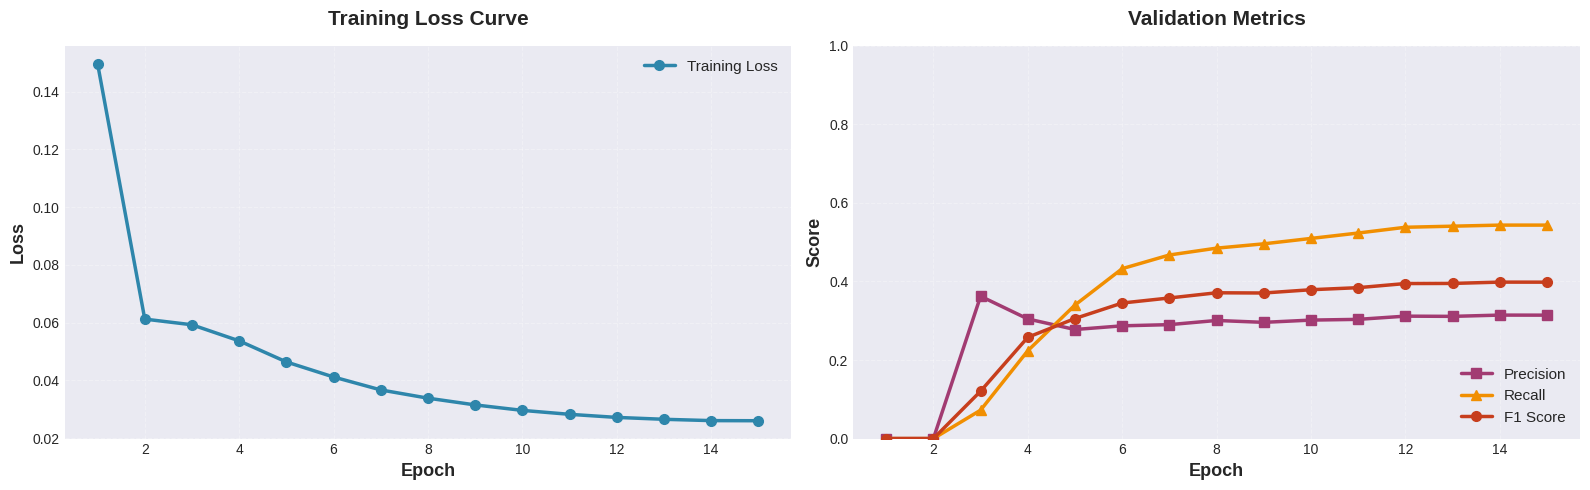


📊 최종 결과:
  - Final Loss: 0.0260
  - Best F1: 0.3984
  - Final Precision: 0.3143
  - Final Recall: 0.5435


In [98]:
import matplotlib.pyplot as plt

print("\n" + "=" * 80)
print("📊 Step 8-8: 학습 결과 시각화")
print("=" * 80)

epochs = list(range(1, len(hier_history["train_loss"]) + 1))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. Training Loss
axes[0].plot(epochs, hier_history["train_loss"], marker="o", linewidth=2.5,
             markersize=7, color='#2E86AB', label='Training Loss')
axes[0].set_xlabel("Epoch", fontsize=13, fontweight='bold')
axes[0].set_ylabel("Loss", fontsize=13, fontweight='bold')
axes[0].set_title("Training Loss Curve", fontsize=15, fontweight='bold', pad=15)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].legend(fontsize=11)

# 2. Validation Metrics
axes[1].plot(epochs, hier_history["val_precision"], marker="s", label="Precision",
             linewidth=2.5, markersize=7, color='#A23B72')
axes[1].plot(epochs, hier_history["val_recall"], marker="^", label="Recall",
             linewidth=2.5, markersize=7, color='#F18F01')
axes[1].plot(epochs, hier_history["val_f1"], marker="o", label="F1 Score",
             linewidth=2.5, markersize=7, color='#C73E1D')
axes[1].set_xlabel("Epoch", fontsize=13, fontweight='bold')
axes[1].set_ylabel("Score", fontsize=13, fontweight='bold')
axes[1].set_title("Validation Metrics", fontsize=15, fontweight='bold', pad=15)
axes[1].legend(fontsize=11, loc='lower right')
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print(f"\n📊 최종 결과:")
print(f"  - Final Loss: {hier_history['train_loss'][-1]:.4f}")
print(f"  - Best F1: {max(hier_history['val_f1']):.4f}")
print(f"  - Final Precision: {hier_history['val_precision'][-1]:.4f}")
print(f"  - Final Recall: {hier_history['val_recall'][-1]:.4f}")
print("=" * 80)


📊 Step 8-9: t-SNE 시각화 (초기 학습 결과)
📊 시각화 데이터:
  - Train samples: 1500
  - Val samples: 781
  - Total samples: 2281
  - Unique classes: 274

🔄 t-SNE 실행 중...
✅ t-SNE 완료


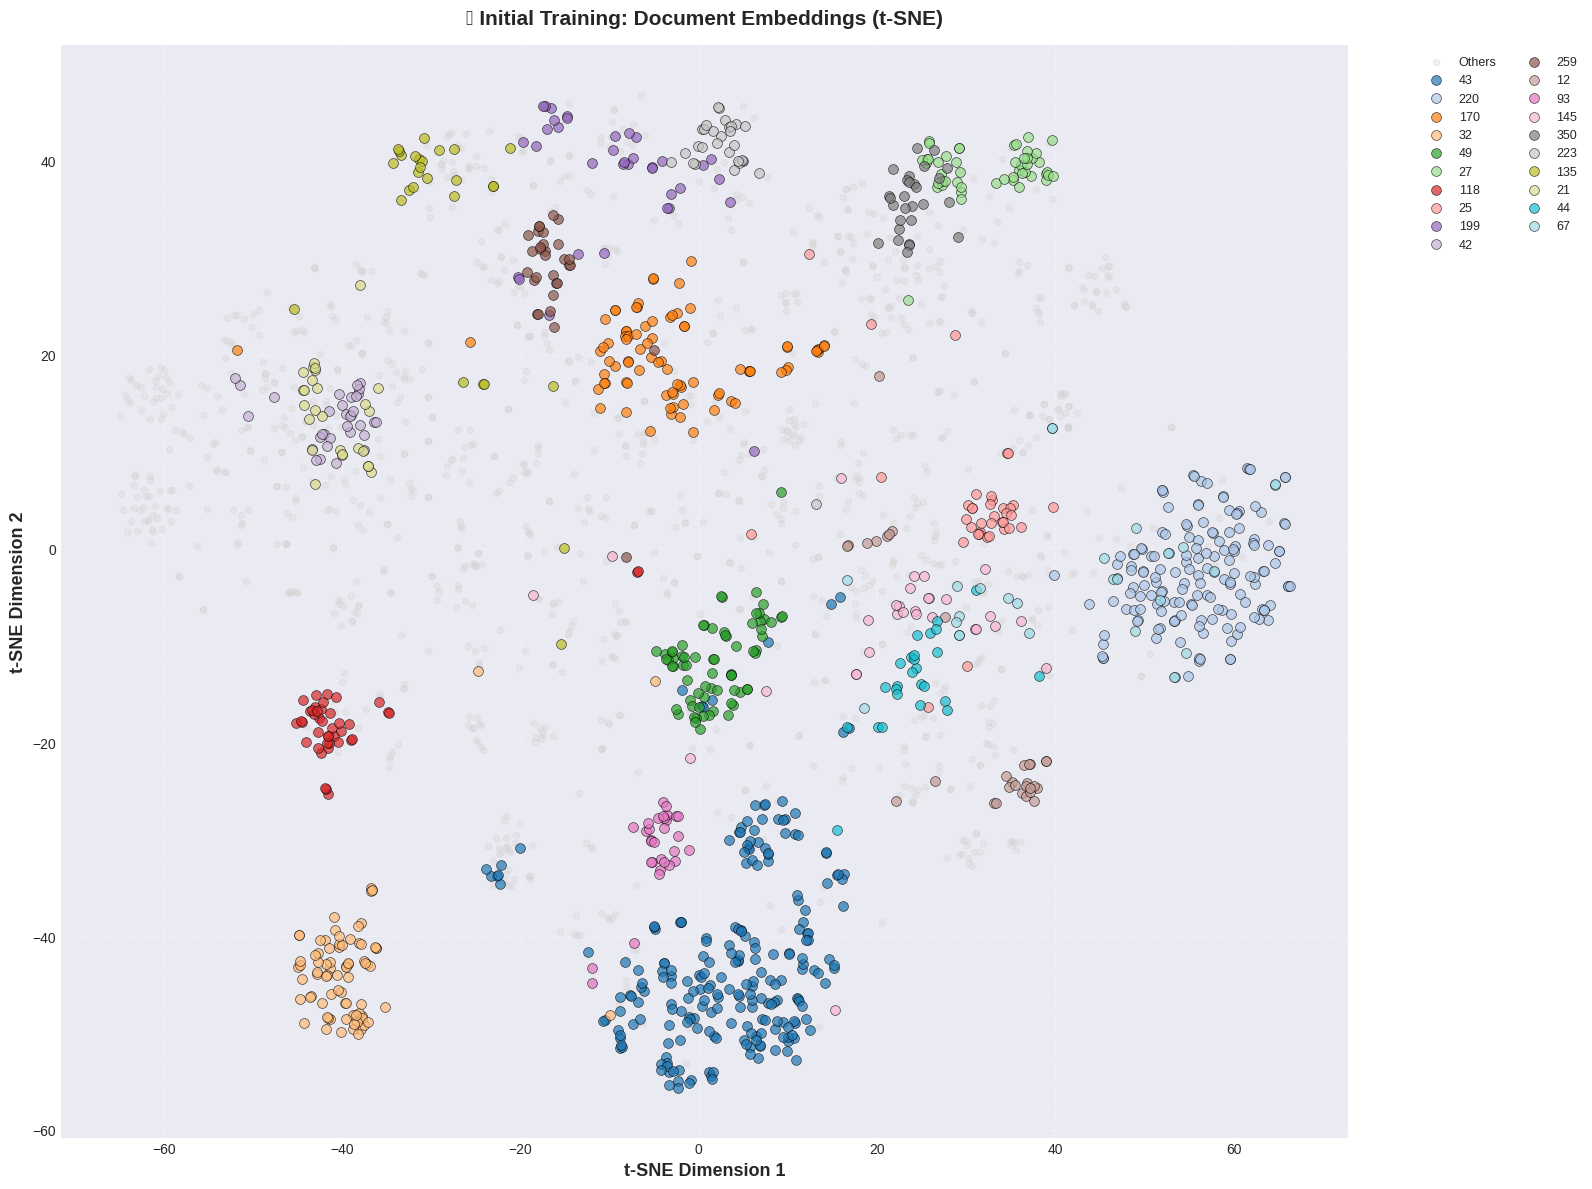

In [99]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "=" * 80)
print("📊 Step 8-9: t-SNE 시각화 (초기 학습 결과)")
print("=" * 80)

# Train/Val 데이터에서 샘플링 (너무 많으면 시각화 느림)
max_samples = 3000  # 샘플 수 제한

# Train에서 샘플링
if len(X_train) > max_samples // 2:
    train_sample_idx = np.random.choice(len(X_train), max_samples // 2, replace=False)
    emb_train_sample = X_train[train_sample_idx].cpu().numpy()
    y_train_sample = y_train[train_sample_idx].cpu().numpy()
else:
    emb_train_sample = X_train.cpu().numpy()
    y_train_sample = y_train.cpu().numpy()

# Val에서 샘플링
if len(X_val) > max_samples // 2:
    val_sample_idx = np.random.choice(len(X_val), max_samples // 2, replace=False)
    emb_val_sample = X_val[val_sample_idx].cpu().numpy()
    y_val_sample = y_val[val_sample_idx].cpu().numpy()
else:
    emb_val_sample = X_val.cpu().numpy()
    y_val_sample = y_val.cpu().numpy()

# 합치기
all_embeddings = np.vstack([emb_train_sample, emb_val_sample])
all_labels = np.vstack([y_train_sample, y_val_sample])

# 각 문서의 주요 클래스 선택 (가장 많이 등장하는 클래스)
main_class_idx = []
for doc_labels in all_labels:
    active_classes = np.where(doc_labels > 0)[0]
    if len(active_classes) > 0:
        main_class_idx.append(active_classes[0])  # 첫 번째 활성 클래스
    else:
        main_class_idx.append(-1)  # 레이블 없음

main_class_idx = np.array(main_class_idx)

print(f"📊 시각화 데이터:")
print(f"  - Train samples: {len(emb_train_sample)}")
print(f"  - Val samples: {len(emb_val_sample)}")
print(f"  - Total samples: {len(all_embeddings)}")
print(f"  - Unique classes: {len(np.unique(main_class_idx[main_class_idx >= 0]))}")

# t-SNE 실행
print(f"\n🔄 t-SNE 실행 중...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(all_embeddings)

print(f"✅ t-SNE 완료")

# 시각화
fig, ax = plt.subplots(figsize=(16, 12))

# 상위 20개 클래스만 색상으로 표시
unique_classes, counts = np.unique(main_class_idx[main_class_idx >= 0], return_counts=True)
top_k_classes = unique_classes[np.argsort(-counts)[:20]]

# 색상 팔레트
colors = plt.cm.tab20(np.linspace(0, 1, 20))

# 배경 (기타 클래스)
other_mask = ~np.isin(main_class_idx, top_k_classes)
ax.scatter(embeddings_2d[other_mask, 0], embeddings_2d[other_mask, 1],
           c='lightgray', alpha=0.3, s=20, label='Others')

# 상위 20개 클래스
for i, cls_idx in enumerate(top_k_classes):
    mask = main_class_idx == cls_idx
    class_name = class_ids_list[cls_idx]

    ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
               c=[colors[i]], alpha=0.7, s=50, label=class_name, edgecolors='black', linewidth=0.5)

ax.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
ax.set_title('📊 Initial Training: Document Embeddings (t-SNE)', fontsize=15, fontweight='bold', pad=15)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("=" * 80)

---

## Step 9: Self-Training (반복 학습 및 레이블 확장)

학습된 모델로 전체 데이터에 pseudo-label을 생성하고 반복 학습합니다.

**과정:**
1. 초기 모델로 전체 train data 예측
2. 높은 confidence 레이블만 선택하여 학습 데이터 확장
3. 확장된 데이터로 재학습
4. 2-3 반복

In [100]:
import torch
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader

print("=" * 80)
print("🔧 Step 9-1: Self-Training 준비")
print("=" * 80)

# Self-training 하이퍼파라미터
NUM_ITERATIONS = 3  # 반복 횟수
PSEUDO_CONFIDENCE = 0.6  # Pseudo-label 신뢰도 임계값
PSEUDO_TOP_K = 3  # 각 문서당 최대 pseudo-label 수
ST_EPOCHS = 8  # 각 iteration당 epoch 수

print(f"📊 Self-Training 설정:")
print(f"  - Iterations: {NUM_ITERATIONS}")
print(f"  - Pseudo confidence: {PSEUDO_CONFIDENCE}")
print(f"  - Top-K: {PSEUDO_TOP_K}")
print(f"  - Epochs per iteration: {ST_EPOCHS}")
print("=" * 80)

🔧 Step 9-1: Self-Training 준비
📊 Self-Training 설정:
  - Iterations: 3
  - Pseudo confidence: 0.6
  - Top-K: 3
  - Epochs per iteration: 8


In [101]:
print("\n" + "=" * 80)
print("🔧 Step 9-2: Pseudo-Label 생성 함수")
print("=" * 80)

@torch.no_grad()
def generate_pseudo_labels(model, embeddings, confidence_thr=0.6, top_k=3):
    """
    전체 데이터에 대해 pseudo-label 생성

    Args:
        model: 학습된 모델
        embeddings: 전체 데이터 임베딩 (N, D)
        confidence_thr: 최소 신뢰도 임계값
        top_k: 각 문서당 최대 레이블 수

    Returns:
        pseudo_labels: (N, C) binary labels
        pseudo_scores: (N, C) confidence scores
        selected_mask: (N,) 선택된 문서 마스크
    """
    model.eval()
    N = embeddings.shape[0]
    C = num_classes

    all_probs = []
    batch_size = 256

    # 전체 데이터 예측
    for i in tqdm(range(0, N, batch_size), desc="Pseudo-labeling", leave=False):
        batch = embeddings[i:i+batch_size].to(device)
        logits = model(batch)
        probs = torch.sigmoid(logits)
        all_probs.append(probs.cpu())

    all_probs = torch.cat(all_probs, dim=0)  # (N, C)

    # Top-K 선택 with confidence threshold
    pseudo_labels = torch.zeros(N, C)
    pseudo_scores = torch.zeros(N, C)
    selected_mask = torch.zeros(N, dtype=torch.bool)

    for i in range(N):
        probs = all_probs[i]
        topk_vals, topk_idx = torch.topk(probs, k=min(top_k, C))

        # Confidence threshold 이상인 것만 선택
        valid_mask = topk_vals >= confidence_thr
        if valid_mask.any():
            valid_idx = topk_idx[valid_mask]
            valid_vals = topk_vals[valid_mask]

            pseudo_labels[i, valid_idx] = 1.0
            pseudo_scores[i, valid_idx] = valid_vals
            selected_mask[i] = True

    return pseudo_labels, pseudo_scores, selected_mask

print("✅ Pseudo-label 생성 함수 정의 완료")
print("=" * 80)


🔧 Step 9-2: Pseudo-Label 생성 함수
✅ Pseudo-label 생성 함수 정의 완료


In [102]:
print("\n" + "=" * 80)
print("🚀 Step 9-3: Self-Training 반복 학습 (Train + Test 통합)")
print("=" * 80)

# 초기 레이블 (high-confidence silver labels, Train 영역만)
initial_labels = train_multilabels.copy()
initial_indices = indices.copy()

st_history = {
    "iteration": [],
    "num_labeled": [],
    "num_train": [],
    "num_test": [],
    "train_loss": [],
    "val_f1": []
}

best_model_state = {k: v.cpu() for k, v in hier_model.state_dict().items()}
best_overall_f1 = max(hier_history['val_f1'])

print(f"초기 상태:")
print(f"  - Labeled documents (Train 영역): {len(initial_labels):,}")
print(f"  - Best F1: {best_overall_f1:.4f}")
print("-" * 80)

for iteration in range(1, NUM_ITERATIONS + 1):
    print(f"\n{'='*80}")
    print(f"🔄 Iteration {iteration}/{NUM_ITERATIONS}")
    print(f"{'='*80}")

    # 1. Pseudo-label 생성 (Train + Test 전체)
    print(f"\n📊 Generating pseudo-labels (Train + Test 전체)...")
    pseudo_labels, pseudo_scores, selected_mask = generate_pseudo_labels(
        hier_model,
        train_embeddings,  # 이미 Train + Test 통합된 임베딩
        confidence_thr=PSEUDO_CONFIDENCE,
        top_k=PSEUDO_TOP_K
    )

    num_pseudo = selected_mask.sum().item()
    num_pseudo_train = selected_mask[:train_size].sum().item()
    num_pseudo_test = selected_mask[train_size:].sum().item()

    print(f"✅ Pseudo-labeled: {num_pseudo:,} / {len(train_embeddings):,} ({num_pseudo/len(train_embeddings)*100:.1f}%)")
    print(f"   - Train 영역: {num_pseudo_train:,} ({num_pseudo_train/train_size*100:.1f}%)")
    print(f"   - Test 영역: {num_pseudo_test:,} ({num_pseudo_test/(len(train_embeddings)-train_size)*100:.1f}%)")

    if num_pseudo == 0:
        print("⚠️ No pseudo-labels generated. Stopping.")
        break

    # 2. 새로운 학습 데이터 구성 (초기 Train + pseudo Train + pseudo Test)
    # 초기 high-confidence (Train 영역)를 항상 포함
    combined_labels = initial_labels.copy()
    combined_indices = initial_indices.copy()

    # Pseudo-label 추가 (중복 제거)
    high_conf_indices = set([d['doc_index'] for d in high_conf_silver_labels])
    new_pseudo_idx = []
    new_pseudo_labels = []

    for i in range(len(train_embeddings)):
        if selected_mask[i] and i not in high_conf_indices:
            new_pseudo_idx.append(i)
            new_pseudo_labels.append(pseudo_labels[i].numpy())

    if len(new_pseudo_idx) > 0:
        combined_labels = np.vstack([combined_labels, np.array(new_pseudo_labels)])
        combined_indices = np.concatenate([combined_indices, new_pseudo_idx])

    # Train/Test 영역별 통계
    num_combined_train = sum(1 for idx in combined_indices if idx < train_size)
    num_combined_test = sum(1 for idx in combined_indices if idx >= train_size)

    print(f"📦 Combined dataset:")
    print(f"  - High-confidence (Train): {len(initial_labels):,}")
    print(f"  - New pseudo (Train + Test): {len(new_pseudo_idx):,}")
    print(f"  - Total: {len(combined_labels):,}")
    print(f"    * Train 영역: {num_combined_train:,}")
    print(f"    * Test 영역: {num_combined_test:,}")

    # 3. Train/Val split (Train 영역에서만 validation 추출)
    # Validation은 Train 영역의 인덱스만 사용
    train_region_mask = np.array([idx < train_size for idx in combined_indices])
    train_region_positions = np.where(train_region_mask)[0]

    # Train 영역 내에서만 split
    train_idx_st, val_idx_st = train_test_split(
        train_region_positions,
        test_size=0.15,
        random_state=42+iteration
    )

    # Test 영역은 모두 training에 포함
    test_region_positions = np.where(~train_region_mask)[0]
    train_idx_st = np.concatenate([train_idx_st, test_region_positions])

    y_train_st = torch.from_numpy(combined_labels[train_idx_st]).float()
    y_val_st = torch.from_numpy(combined_labels[val_idx_st]).float()

    emb_train_st = train_embeddings[combined_indices[train_idx_st]].detach().cpu()
    emb_val_st = train_embeddings[combined_indices[val_idx_st]].detach().cpu()

    print(f"\n📂 데이터 분할:")
    print(f"  - Training: {len(train_idx_st):,}개 (Train 영역 + Test 영역 전체)")
    print(f"  - Validation: {len(val_idx_st):,}개 (Train 영역만)")

    # DataLoader
    train_loader_st = DataLoader(
        TensorDataset(emb_train_st, y_train_st),
        batch_size=64,
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader_st = DataLoader(
        TensorDataset(emb_val_st, y_val_st),
        batch_size=128,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )

    # 4. 재학습
    print(f"\n🔥 Re-training with expanded dataset...")
    pos_weight_st = compute_pos_weight(train_loader_st, num_classes, device)
    hier_criterion_st = HierarchicalLoss(
        child_to_parents=child_to_parents,
        class_ids_list=class_ids_list,
        pos_weight=pos_weight_st,
        alpha=0.1
    ).to(device)

    hier_model, iter_history = train_model(
        model=hier_model,
        train_loader=train_loader_st,
        val_loader=val_loader_st,
        criterion=hier_criterion_st,
        num_epochs=ST_EPOCHS,
        lr=5e-4,  # 더 작은 learning rate
        device=device
    )

    # 5. 결과 기록
    final_f1 = max(iter_history['val_f1'])
    st_history["iteration"].append(iteration)
    st_history["num_labeled"].append(len(combined_labels))
    st_history["num_train"].append(num_combined_train)
    st_history["num_test"].append(num_combined_test)
    st_history["train_loss"].append(iter_history['train_loss'][-1])
    st_history["val_f1"].append(final_f1)

    print(f"\n📊 Iteration {iteration} 결과:")
    print(f"  - Labeled docs: {len(combined_labels):,} (Train {num_combined_train:,} + Test {num_combined_test:,})")
    print(f"  - Best F1: {final_f1:.4f}")

    # Best model 업데이트
    if final_f1 > best_overall_f1:
        best_overall_f1 = final_f1
        best_model_state = {k: v.cpu() for k, v in hier_model.state_dict().items()}
        print(f"  ✨ New best model saved!")

print(f"\n{'='*80}")
print(f"✅ Self-Training 완료!")
print(f"  - Best F1: {best_overall_f1:.4f}")
print(f"{'='*80}")

# Best model 로드
hier_model.load_state_dict(best_model_state)
print("✅ Best model loaded for final predictions")


🚀 Step 9-3: Self-Training 반복 학습 (Train + Test 통합)
초기 상태:
  - Labeled documents (Train 영역): 5,206
  - Best F1: 0.3984
--------------------------------------------------------------------------------

🔄 Iteration 1/3

📊 Generating pseudo-labels (Train + Test 전체)...


✅ Pseudo-labeled: 26,486 / 49,145 (53.9%)
   - Train 영역: 15,984 (54.2%)
   - Test 영역: 10,502 (53.4%)
📦 Combined dataset:
  - High-confidence (Train): 5,206
  - New pseudo (Train + Test): 22,716
  - Total: 27,922
    * Train 영역: 17,420
    * Test 영역: 10,502

📂 데이터 분할:
  - Training: 25,309개 (Train 영역 + Test 영역 전체)
  - Validation: 2,613개 (Train 영역만)

🔥 Re-training with expanded dataset...
  계층 edges: 568개

🚀 모델 학습 시작
  - Epochs: 8
  - Learning rate: 0.0005
  - Device: cuda
--------------------------------------------------------------------------------


Epoch 01 | Loss: 0.0228 | P: 0.4576 | R: 0.6975 | F1: 0.5526


Epoch 02 | Loss: 0.0199 | P: 0.4632 | R: 0.7053 | F1: 0.5592


Epoch 03 | Loss: 0.0190 | P: 0.4719 | R: 0.7043 | F1: 0.5651


Epoch 04 | Loss: 0.0183 | P: 0.4773 | R: 0.7046 | F1: 0.5691


Epoch 05 | Loss: 0.0177 | P: 0.4823 | R: 0.7061 | F1: 0.5731


Epoch 06 | Loss: 0.0172 | P: 0.4805 | R: 0.7051 | F1: 0.5715


Epoch 07 | Loss: 0.0168 | P: 0.4844 | R: 0.7061 | F1: 0.5746


Epoch 08 | Loss: 0.0167 | P: 0.4856 | R: 0.7058 | F1: 0.5754
--------------------------------------------------------------------------------
✅ 학습 완료 | Best F1 = 0.5754

📊 Iteration 1 결과:
  - Labeled docs: 27,922 (Train 17,420 + Test 10,502)
  - Best F1: 0.5754
  ✨ New best model saved!

🔄 Iteration 2/3

📊 Generating pseudo-labels (Train + Test 전체)...


✅ Pseudo-labeled: 38,720 / 49,145 (78.8%)
   - Train 영역: 23,247 (78.8%)
   - Test 영역: 15,473 (78.7%)
📦 Combined dataset:
  - High-confidence (Train): 5,206
  - New pseudo (Train + Test): 34,152
  - Total: 39,358
    * Train 영역: 23,885
    * Test 영역: 15,473

📂 데이터 분할:
  - Training: 35,775개 (Train 영역 + Test 영역 전체)
  - Validation: 3,583개 (Train 영역만)

🔥 Re-training with expanded dataset...
  계층 edges: 568개

🚀 모델 학습 시작
  - Epochs: 8
  - Learning rate: 0.0005
  - Device: cuda
--------------------------------------------------------------------------------


Epoch 01 | Loss: 0.0140 | P: 0.6405 | R: 0.8304 | F1: 0.7232


Epoch 02 | Loss: 0.0132 | P: 0.6510 | R: 0.8315 | F1: 0.7303


Epoch 03 | Loss: 0.0126 | P: 0.6662 | R: 0.8304 | F1: 0.7393


Epoch 04 | Loss: 0.0122 | P: 0.6647 | R: 0.8304 | F1: 0.7384


Epoch 05 | Loss: 0.0117 | P: 0.6706 | R: 0.8310 | F1: 0.7423


Epoch 06 | Loss: 0.0114 | P: 0.6735 | R: 0.8318 | F1: 0.7443


Epoch 07 | Loss: 0.0110 | P: 0.6815 | R: 0.8315 | F1: 0.7491


Epoch 08 | Loss: 0.0109 | P: 0.6809 | R: 0.8318 | F1: 0.7488
--------------------------------------------------------------------------------
✅ 학습 완료 | Best F1 = 0.7491

📊 Iteration 2 결과:
  - Labeled docs: 39,358 (Train 23,885 + Test 15,473)
  - Best F1: 0.7491
  ✨ New best model saved!

🔄 Iteration 3/3

📊 Generating pseudo-labels (Train + Test 전체)...


✅ Pseudo-labeled: 44,790 / 49,145 (91.1%)
   - Train 영역: 26,837 (91.0%)
   - Test 영역: 17,953 (91.3%)
📦 Combined dataset:
  - High-confidence (Train): 5,206
  - New pseudo (Train + Test): 39,828
  - Total: 45,034
    * Train 영역: 27,081
    * Test 영역: 17,953

📂 데이터 분할:
  - Training: 40,971개 (Train 영역 + Test 영역 전체)
  - Validation: 4,063개 (Train 영역만)

🔥 Re-training with expanded dataset...
  계층 edges: 568개

🚀 모델 학습 시작
  - Epochs: 8
  - Learning rate: 0.0005
  - Device: cuda
--------------------------------------------------------------------------------


Epoch 01 | Loss: 0.0120 | P: 0.6661 | R: 0.8464 | F1: 0.7455


Epoch 02 | Loss: 0.0114 | P: 0.6682 | R: 0.8446 | F1: 0.7461


Epoch 03 | Loss: 0.0110 | P: 0.6784 | R: 0.8453 | F1: 0.7527


Epoch 04 | Loss: 0.0105 | P: 0.6832 | R: 0.8460 | F1: 0.7559


Epoch 05 | Loss: 0.0101 | P: 0.6888 | R: 0.8464 | F1: 0.7595


Epoch 06 | Loss: 0.0097 | P: 0.6942 | R: 0.8462 | F1: 0.7627


Epoch 07 | Loss: 0.0095 | P: 0.6978 | R: 0.8476 | F1: 0.7654


Epoch 08 | Loss: 0.0093 | P: 0.7004 | R: 0.8476 | F1: 0.7670
--------------------------------------------------------------------------------
✅ 학습 완료 | Best F1 = 0.7670

📊 Iteration 3 결과:
  - Labeled docs: 45,034 (Train 27,081 + Test 17,953)
  - Best F1: 0.7670
  ✨ New best model saved!

✅ Self-Training 완료!
  - Best F1: 0.7670
✅ Best model loaded for final predictions



📊 Step 9: Self-Training 결과 시각화


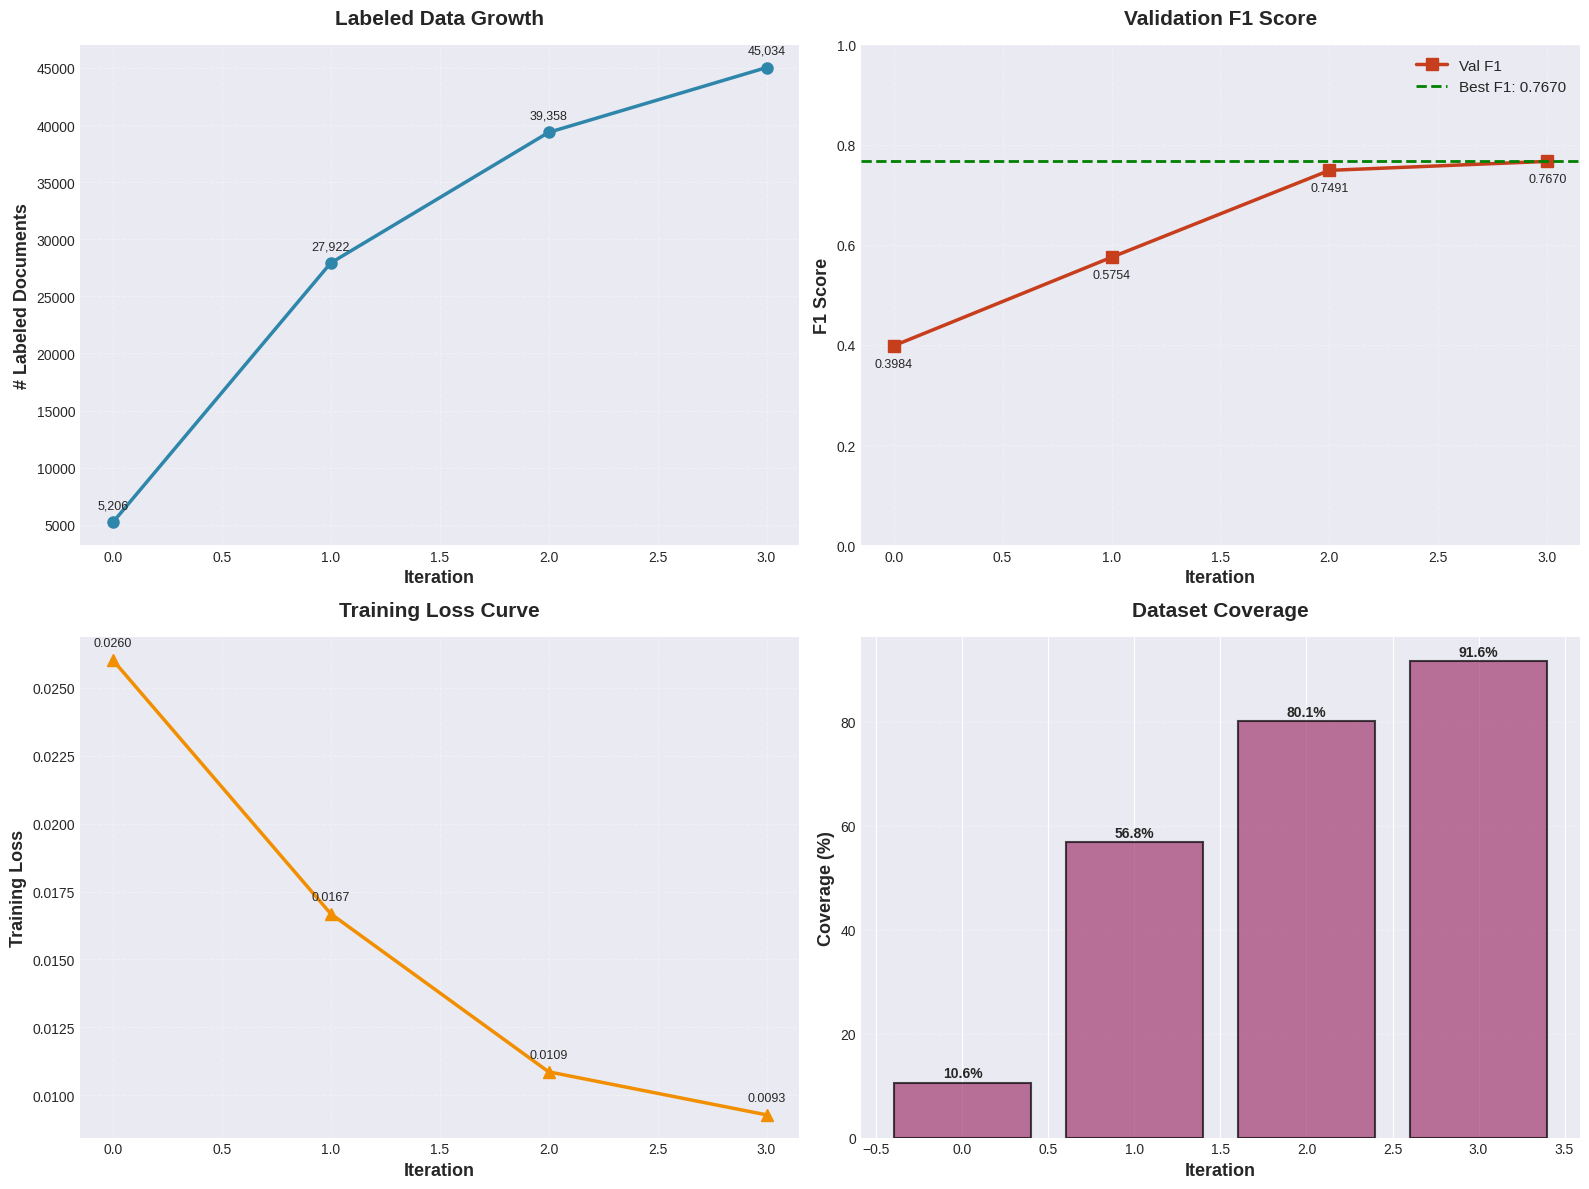


📊 Self-Training 최종 결과:
  - 초기 Labeled: 5,206개 (10.6%)
  - 최종 Labeled: 45,034개 (91.6%)
  - 증가량: 39,828개
  - Best F1: 0.7670


In [103]:
import matplotlib.pyplot as plt

print("\n" + "=" * 80)
print("📊 Step 9: Self-Training 결과 시각화")
print("=" * 80)

# Self-training 이터레이션 결과 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Labeled Documents 증가 추이
iterations = [0] + st_history["iteration"]
num_labeled = [len(initial_labels)] + st_history["num_labeled"]

axes[0, 0].plot(iterations, num_labeled, marker="o", linewidth=2.5,
                markersize=8, color='#2E86AB')
axes[0, 0].set_xlabel("Iteration", fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel("# Labeled Documents", fontsize=13, fontweight='bold')
axes[0, 0].set_title("Labeled Data Growth", fontsize=15, fontweight='bold', pad=15)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

# 각 포인트에 값 표시
for i, (x, y) in enumerate(zip(iterations, num_labeled)):
    axes[0, 0].annotate(f'{y:,}', (x, y), textcoords="offset points",
                        xytext=(0,10), ha='center', fontsize=9)

# 2. Validation F1 Score 향상 추이
val_f1_scores = [best_overall_f1 if len(st_history["iteration"]) == 0 else max(hier_history['val_f1'])] + st_history["val_f1"]

axes[0, 1].plot(iterations, val_f1_scores, marker="s", linewidth=2.5,
                markersize=8, color='#C73E1D', label='Val F1')
axes[0, 1].axhline(y=best_overall_f1, color='green', linestyle='--',
                   linewidth=2, label=f'Best F1: {best_overall_f1:.4f}')
axes[0, 1].set_xlabel("Iteration", fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel("F1 Score", fontsize=13, fontweight='bold')
axes[0, 1].set_title("Validation F1 Score", fontsize=15, fontweight='bold', pad=15)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3, linestyle='--')
axes[0, 1].set_ylim([0, 1])

# 각 포인트에 값 표시
for i, (x, y) in enumerate(zip(iterations, val_f1_scores)):
    axes[0, 1].annotate(f'{y:.4f}', (x, y), textcoords="offset points",
                        xytext=(0,-15), ha='center', fontsize=9)

# 3. Training Loss 감소 추이
if len(st_history["train_loss"]) > 0:
    initial_loss = hier_history['train_loss'][-1]
    train_losses = [initial_loss] + st_history["train_loss"]

    axes[1, 0].plot(iterations, train_losses, marker="^", linewidth=2.5,
                    markersize=8, color='#F18F01')
    axes[1, 0].set_xlabel("Iteration", fontsize=13, fontweight='bold')
    axes[1, 0].set_ylabel("Training Loss", fontsize=13, fontweight='bold')
    axes[1, 0].set_title("Training Loss Curve", fontsize=15, fontweight='bold', pad=15)
    axes[1, 0].grid(True, alpha=0.3, linestyle='--')

    # 각 포인트에 값 표시
    for i, (x, y) in enumerate(zip(iterations, train_losses)):
        axes[1, 0].annotate(f'{y:.4f}', (x, y), textcoords="offset points",
                            xytext=(0,10), ha='center', fontsize=9)
else:
    axes[1, 0].text(0.5, 0.5, 'No training data', ha='center', va='center',
                    transform=axes[1, 0].transAxes, fontsize=14)

# 4. Data Coverage (라벨된 문서 비율)
coverage = [len(initial_labels)/len(train_embeddings)*100] + \
           [n/len(train_embeddings)*100 for n in st_history["num_labeled"]]

axes[1, 1].bar(iterations, coverage, color='#A23B72', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 1].set_xlabel("Iteration", fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel("Coverage (%)", fontsize=13, fontweight='bold')
axes[1, 1].set_title("Dataset Coverage", fontsize=15, fontweight='bold', pad=15)
axes[1, 1].grid(True, alpha=0.3, linestyle='--', axis='y')

# 각 바에 값 표시
for i, (x, y) in enumerate(zip(iterations, coverage)):
    axes[1, 1].text(x, y + 0.5, f'{y:.1f}%', ha='center', va='bottom',
                    fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Self-Training 최종 결과:")
print(f"  - 초기 Labeled: {len(initial_labels):,}개 ({len(initial_labels)/len(train_embeddings)*100:.1f}%)")
if len(st_history["num_labeled"]) > 0:
    print(f"  - 최종 Labeled: {st_history['num_labeled'][-1]:,}개 ({st_history['num_labeled'][-1]/len(train_embeddings)*100:.1f}%)")
    print(f"  - 증가량: {st_history['num_labeled'][-1] - len(initial_labels):,}개")
print(f"  - Best F1: {best_overall_f1:.4f}")
print("=" * 80)


📊 Step 9-4: t-SNE 시각화 (Self-Training 후)
📊 시각화 데이터:
  - Train samples: 1500
  - Val samples: 1500
  - Total samples: 3000
  - Unique classes: 146

🔄 t-SNE 실행 중...
✅ t-SNE 완료


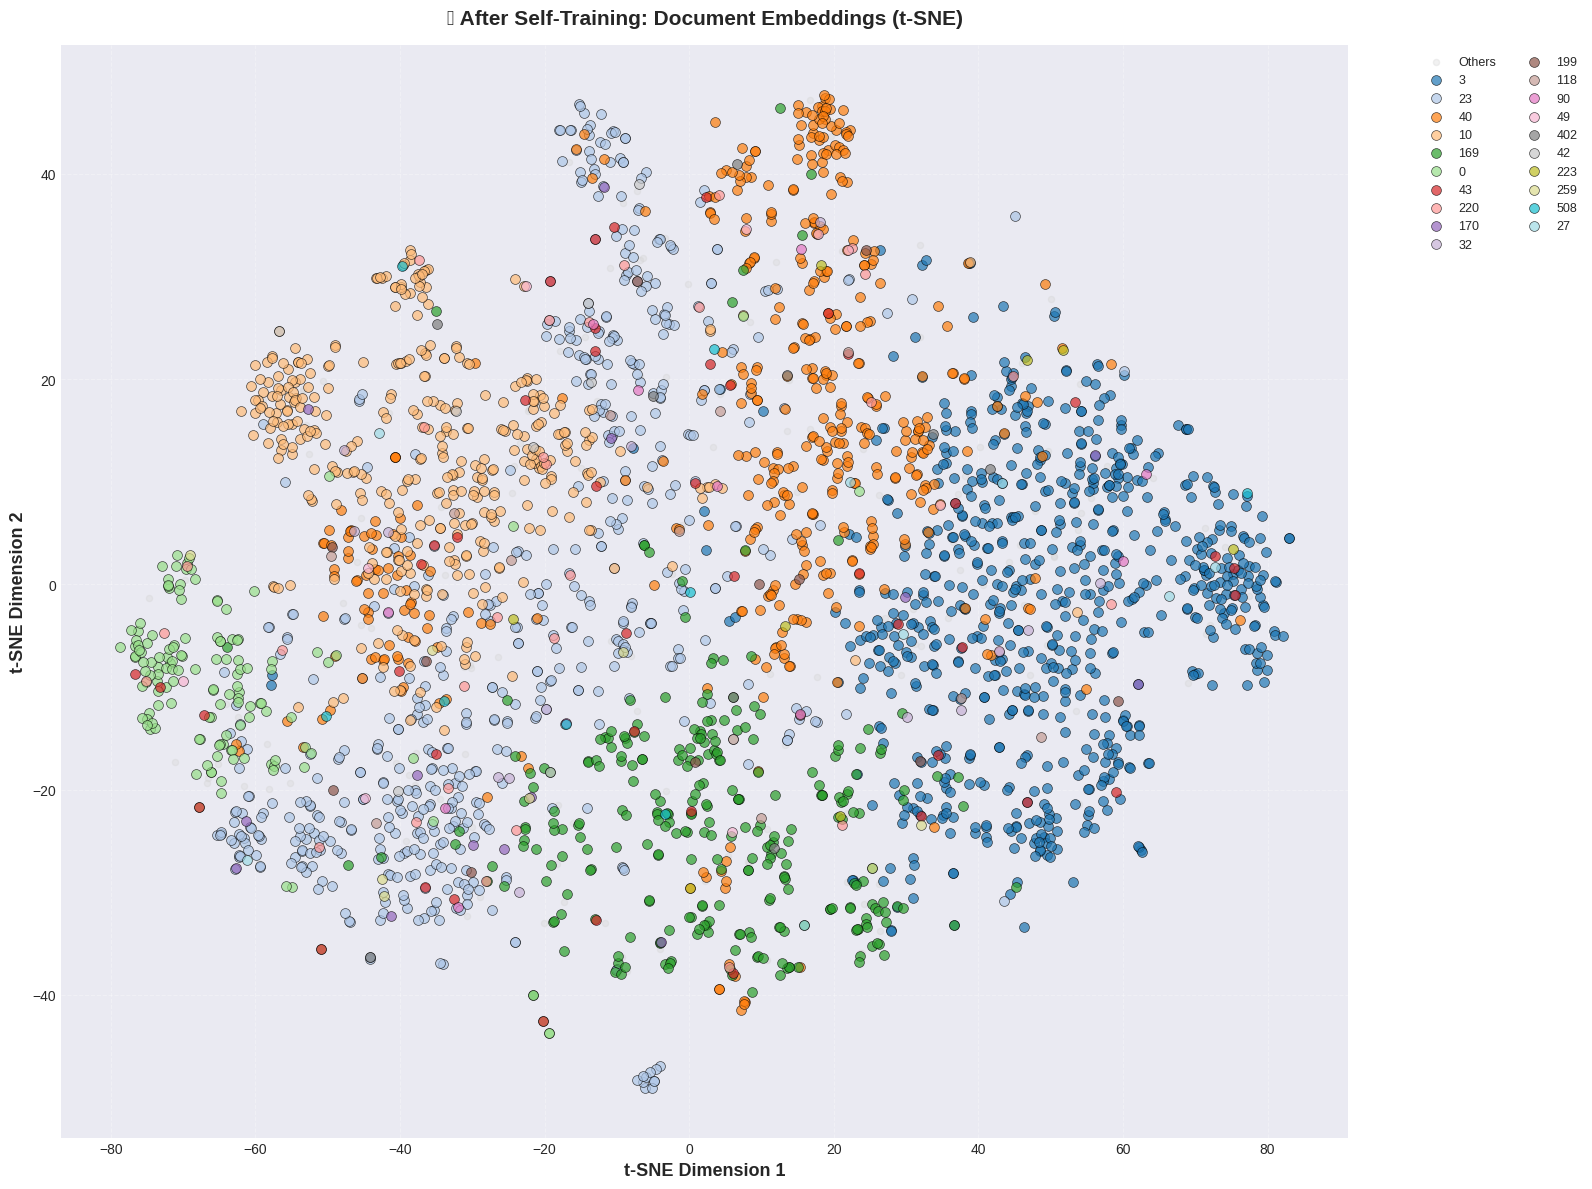

In [104]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "=" * 80)
print("📊 Step 9-4: t-SNE 시각화 (Self-Training 후)")
print("=" * 80)

# Self-Training 후 최종 데이터 샘플링
max_samples = 3000

# Train 영역 샘플링
if len(emb_train_st) > max_samples // 2:
    train_st_sample_idx = np.random.choice(len(emb_train_st), max_samples // 2, replace=False)
    emb_train_st_sample = emb_train_st[train_st_sample_idx].cpu().numpy()
    y_train_st_sample = y_train_st[train_st_sample_idx].cpu().numpy()
else:
    emb_train_st_sample = emb_train_st.cpu().numpy()
    y_train_st_sample = y_train_st.cpu().numpy()

# Val 영역 샘플링
if len(emb_val_st) > max_samples // 2:
    val_st_sample_idx = np.random.choice(len(emb_val_st), max_samples // 2, replace=False)
    emb_val_st_sample = emb_val_st[val_st_sample_idx].cpu().numpy()
    y_val_st_sample = y_val_st[val_st_sample_idx].cpu().numpy()
else:
    emb_val_st_sample = emb_val_st.cpu().numpy()
    y_val_st_sample = y_val_st.cpu().numpy()

# 합치기
all_embeddings_st = np.vstack([emb_train_st_sample, emb_val_st_sample])
all_labels_st = np.vstack([y_train_st_sample, y_val_st_sample])

# 각 문서의 주요 클래스
main_class_idx_st = []
for doc_labels in all_labels_st:
    active_classes = np.where(doc_labels > 0)[0]
    if len(active_classes) > 0:
        main_class_idx_st.append(active_classes[0])
    else:
        main_class_idx_st.append(-1)

main_class_idx_st = np.array(main_class_idx_st)

print(f"📊 시각화 데이터:")
print(f"  - Train samples: {len(emb_train_st_sample)}")
print(f"  - Val samples: {len(emb_val_st_sample)}")
print(f"  - Total samples: {len(all_embeddings_st)}")
print(f"  - Unique classes: {len(np.unique(main_class_idx_st[main_class_idx_st >= 0]))}")

# t-SNE 실행
print(f"\n🔄 t-SNE 실행 중...")
tsne_st = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d_st = tsne_st.fit_transform(all_embeddings_st)

print(f"✅ t-SNE 완료")

# 시각화
fig, ax = plt.subplots(figsize=(16, 12))

# 상위 20개 클래스
unique_classes_st, counts_st = np.unique(main_class_idx_st[main_class_idx_st >= 0], return_counts=True)
top_k_classes_st = unique_classes_st[np.argsort(-counts_st)[:20]]

colors = plt.cm.tab20(np.linspace(0, 1, 20))

# 배경 (기타 클래스)
other_mask_st = ~np.isin(main_class_idx_st, top_k_classes_st)
ax.scatter(embeddings_2d_st[other_mask_st, 0], embeddings_2d_st[other_mask_st, 1],
           c='lightgray', alpha=0.3, s=20, label='Others')

# 상위 20개 클래스
for i, cls_idx in enumerate(top_k_classes_st):
    mask = main_class_idx_st == cls_idx
    class_name = class_ids_list[cls_idx]

    ax.scatter(embeddings_2d_st[mask, 0], embeddings_2d_st[mask, 1],
               c=[colors[i]], alpha=0.7, s=50, label=class_name, edgecolors='black', linewidth=0.5)

ax.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
ax.set_title('📊 After Self-Training: Document Embeddings (t-SNE)', fontsize=15, fontweight='bold', pad=15)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("=" * 80)

---

## Step 9B: GNN 기반 Self-Training (비교용)

TaxoClass 논문의 GNN 접근법을 구현하여 Hierarchical Loss 방식과 비교합니다.

**구조:**
- **Class Encoder GNN**: 계층 구조를 그래프로 명시적 모델링
- **TaxoMatch**: Document-Class 매칭 모델
- **Self-Training**: GNN으로 pseudo-label 생성 및 반복 학습

**비교 목적:**
- Hierarchical Loss (Step 9A) vs GNN (Step 9B)
- 성능, 복잡도, 학습 시간 비교

In [105]:
print("=" * 80)
print("🔧 Step 9B-1: 계층 구조 인접 행렬 생성")
print("=" * 80)

# 계층 구조를 그래프로 변환
C = num_classes
adj_matrix = torch.zeros((C, C), dtype=torch.float32)

# Child -> Parent 연결
for child_id, parents in child_to_parents.items():
    if child_id not in class2idx:
        continue
    c_idx = class2idx[child_id]
    for parent_id in parents:
        if parent_id in class2idx:
            p_idx = class2idx[parent_id]
            adj_matrix[c_idx, p_idx] = 1.0
            adj_matrix[p_idx, c_idx] = 1.0  # Undirected

# Self-loop 추가
adj_matrix += torch.eye(C)

# Normalization (GCN-style)
degree = adj_matrix.sum(dim=1)
degree_inv_sqrt = torch.pow(degree, -0.5)
degree_inv_sqrt[torch.isinf(degree_inv_sqrt)] = 0.0
D_inv = torch.diag(degree_inv_sqrt)

adj_matrix_norm = D_inv @ adj_matrix @ D_inv
adj_matrix_norm = adj_matrix_norm.to(device)

print(f"✅ 인접 행렬 생성 완료")
print(f"  - Shape: {adj_matrix_norm.shape}")
print(f"  - Edges: {int((adj_matrix > 0).sum().item() - C)} (self-loop 제외)")
print("=" * 80)

🔧 Step 9B-1: 계층 구조 인접 행렬 생성
✅ 인접 행렬 생성 완료
  - Shape: torch.Size([531, 531])
  - Edges: 1136 (self-loop 제외)


In [106]:
print("\n" + "=" * 80)
print("🔧 Step 9B-2: GNN 모델 정의")
print("=" * 80)

class GCNLayer(nn.Module):
    """Graph Convolutional Network Layer"""
    def __init__(self, in_dim, out_dim, dropout=0.1):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, A):
        """
        Args:
            X: (C, D) 노드 특징
            A: (C, C) 정규화된 인접 행렬
        """
        X = torch.matmul(A, X)  # 그래프 컨볼루션
        X = self.linear(X)
        X = F.relu(X)
        X = self.dropout(X)
        return X

class ClassEncoderGNN(nn.Module):
    """클래스 계층 구조를 인코딩하는 GNN"""
    def __init__(self, in_dim, hidden_dim=256, num_layers=2, dropout=0.1):
        super().__init__()
        layers = []
        dim = in_dim
        for _ in range(num_layers - 1):
            layers.append(GCNLayer(dim, hidden_dim, dropout))
            dim = hidden_dim
        layers.append(GCNLayer(dim, hidden_dim, dropout=0.0))

        self.layers = nn.ModuleList(layers)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, X, A):
        """
        Args:
            X: (C, D) 클래스 특징
            A: (C, C) 인접 행렬
        Returns:
            H: (C, hidden_dim) 인코딩된 클래스 표현
        """
        H = X
        for layer in self.layers:
            H = layer(H, A)
        return self.norm(H)

class TaxoMatchModel(nn.Module):
    """Document-Class 매칭 모델 (TaxoClass)"""
    def __init__(self, doc_dim, class_dim, hidden_dim=256, dropout=0.2):
        super().__init__()

        # Document encoder
        self.doc_encoder = nn.Sequential(
            nn.Linear(doc_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )

        # Class GNN encoder
        self.class_gnn = ClassEncoderGNN(
            in_dim=class_dim,
            hidden_dim=hidden_dim,
            num_layers=2,
            dropout=0.1
        )

        # Matching score
        self.logit_scale = nn.Parameter(torch.tensor(1.0))

    def forward(self, doc_emb, class_emb, adj_matrix):
        """
        Args:
            doc_emb: (B, doc_dim) 문서 임베딩
            class_emb: (C, class_dim) 클래스 임베딩
            adj_matrix: (C, C) 인접 행렬
        Returns:
            logits: (B, C) 매칭 점수
        """
        # Encode documents
        doc_encoded = self.doc_encoder(doc_emb)  # (B, hidden_dim)

        # Encode classes with GNN
        class_encoded = self.class_gnn(class_emb, adj_matrix)  # (C, hidden_dim)

        # Compute matching scores
        logits = torch.matmul(doc_encoded, class_encoded.T)  # (B, C)
        logits = logits * self.logit_scale

        return logits

print("✅ GNN 모델 정의 완료")
print("  - GCNLayer: 그래프 컨볼루션")
print("  - ClassEncoderGNN: 클래스 계층 인코딩")
print("  - TaxoMatchModel: Document-Class 매칭")
print("=" * 80)


🔧 Step 9B-2: GNN 모델 정의
✅ GNN 모델 정의 완료
  - GCNLayer: 그래프 컨볼루션
  - ClassEncoderGNN: 클래스 계층 인코딩
  - TaxoMatchModel: Document-Class 매칭


In [107]:
print("\n" + "=" * 80)
print("🔧 Step 9B-3: 클래스 특징 생성")
print("=" * 80)

# 클래스 이름으로 특징 생성 (sentence-transformers 사용)
from sentence_transformers import SentenceTransformer

class_names = [classes_dict.get(cid, f"Class_{cid}") for cid in class_ids_list]

print("📝 클래스 이름 임베딩 생성 중...")
class_emb_model = SentenceTransformer('all-MiniLM-L6-v2', device=str(device))

with torch.no_grad():
    class_embeddings = class_emb_model.encode(
        class_names,
        batch_size=64,
        show_progress_bar=True,
        convert_to_tensor=True,
        device=str(device)
    )

class_embeddings = class_embeddings.float().to(device)

print(f"✅ 클래스 임베딩 생성 완료")
print(f"  - Shape: {class_embeddings.shape}")
print(f"  - 예시 클래스: {class_names[:3]}")
print("=" * 80)


🔧 Step 9B-3: 클래스 특징 생성
📝 클래스 이름 임베딩 생성 중...


✅ 클래스 임베딩 생성 완료
  - Shape: torch.Size([531, 384])
  - 예시 클래스: ['grocery_gourmet_food', 'meat_poultry', 'jerky']


In [108]:
print("\n" + "=" * 80)
print("🔧 Step 9B-4: GNN 모델 초기 학습")
print("=" * 80)

# GNN 모델 생성
doc_dim = train_embeddings.shape[1]
class_dim = class_embeddings.shape[1]

gnn_model = TaxoMatchModel(
    doc_dim=doc_dim,
    class_dim=class_dim,
    hidden_dim=256,
    dropout=0.2
).to(device)

print(f"📊 GNN 모델 정보:")
print(f"  - Parameters: {sum(p.numel() for p in gnn_model.parameters()):,}")
print(f"  - Doc dim: {doc_dim}")
print(f"  - Class dim: {class_dim}")

# 초기 학습 (high-confidence silver labels 사용)
gnn_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
gnn_optimizer = torch.optim.AdamW(gnn_model.parameters(), lr=1e-3, weight_decay=0.01)
gnn_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(gnn_optimizer, T_max=15)

print(f"\n🚀 GNN 초기 학습 시작...")
print(f"  - Epochs: 15")
print(f"  - Learning rate: 1e-3")
print("-" * 80)

gnn_history = {
    "train_loss": [],
    "val_f1": [],
    "val_precision": [],
    "val_recall": []
}

best_gnn_f1 = -1.0
best_gnn_state = None

for epoch in range(15):
    # Train
    gnn_model.train()
    total_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/15", leave=False):
        x = x.to(device)
        y = y.to(device)

        gnn_optimizer.zero_grad()

        logits = gnn_model(x, class_embeddings, adj_matrix_norm)
        loss = gnn_criterion(logits, y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(gnn_model.parameters(), 1.0)
        gnn_optimizer.step()

        total_loss += loss.item()

    gnn_scheduler.step()
    avg_loss = total_loss / len(train_loader)
    gnn_history["train_loss"].append(avg_loss)

    # Validation
    gnn_model.eval()
    tp = fp = fn = 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)

            logits = gnn_model(x, class_embeddings, adj_matrix_norm)
            probs = torch.sigmoid(logits)
            preds = topk_predict(probs, k=TOP_K, min_prob=BEST_THRESHOLD)

            yb = (y > 0).float()

            tp += (preds * yb).sum().item()
            fp += (preds * (1 - yb)).sum().item()
            fn += ((1 - preds) * yb).sum().item()

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    gnn_history["val_precision"].append(precision)
    gnn_history["val_recall"].append(recall)
    gnn_history["val_f1"].append(f1)

    if f1 > best_gnn_f1:
        best_gnn_f1 = f1
        best_gnn_state = {k: v.cpu() for k, v in gnn_model.state_dict().items()}

    print(
        f"Epoch {epoch+1:02d} | "
        f"Loss: {avg_loss:.4f} | "
        f"P: {precision:.4f} | R: {recall:.4f} | F1: {f1:.4f}"
    )

print("-" * 80)
print(f"✅ GNN 초기 학습 완료 | Best F1 = {best_gnn_f1:.4f}")
print("=" * 80)

# Best model 로드
if best_gnn_state is not None:
    gnn_model.load_state_dict(best_gnn_state)


🔧 Step 9B-4: GNN 모델 초기 학습
📊 GNN 모델 정보:
  - Parameters: 494,081
  - Doc dim: 1024
  - Class dim: 384

🚀 GNN 초기 학습 시작...
  - Epochs: 15
  - Learning rate: 1e-3
--------------------------------------------------------------------------------


Epoch 01 | Loss: 0.3736 | P: 0.1344 | R: 0.2887 | F1: 0.1835


Epoch 02 | Loss: 0.0450 | P: 0.4778 | R: 0.3254 | F1: 0.3871


Epoch 03 | Loss: 0.0342 | P: 0.3476 | R: 0.5445 | F1: 0.4243


Epoch 04 | Loss: 0.0281 | P: 0.4684 | R: 0.5509 | F1: 0.5063


Epoch 05 | Loss: 0.0243 | P: 0.4267 | R: 0.6324 | F1: 0.5096


Epoch 06 | Loss: 0.0216 | P: 0.4201 | R: 0.6581 | F1: 0.5129


Epoch 07 | Loss: 0.0187 | P: 0.5304 | R: 0.6389 | F1: 0.5796


Epoch 08 | Loss: 0.0170 | P: 0.3976 | R: 0.7369 | F1: 0.5165


Epoch 09 | Loss: 0.0150 | P: 0.4668 | R: 0.7030 | F1: 0.5611


Epoch 10 | Loss: 0.0137 | P: 0.4830 | R: 0.7278 | F1: 0.5806


Epoch 11 | Loss: 0.0124 | P: 0.4886 | R: 0.7269 | F1: 0.5844


Epoch 12 | Loss: 0.0113 | P: 0.4651 | R: 0.7461 | F1: 0.5730


Epoch 13 | Loss: 0.0104 | P: 0.4854 | R: 0.7443 | F1: 0.5876


Epoch 14 | Loss: 0.0099 | P: 0.4901 | R: 0.7479 | F1: 0.5922


Epoch 15 | Loss: 0.0098 | P: 0.4991 | R: 0.7443 | F1: 0.5975
--------------------------------------------------------------------------------
✅ GNN 초기 학습 완료 | Best F1 = 0.5975



📊 Step 9B-4-1: GNN 학습 전 t-SNE 시각화
📊 시각화 데이터:
  - Train samples: 1500
  - Val samples: 781
  - Total samples: 2281
  - Unique classes: 282

🔄 t-SNE 실행 중 (GNN 학습 전)...
✅ t-SNE 완료


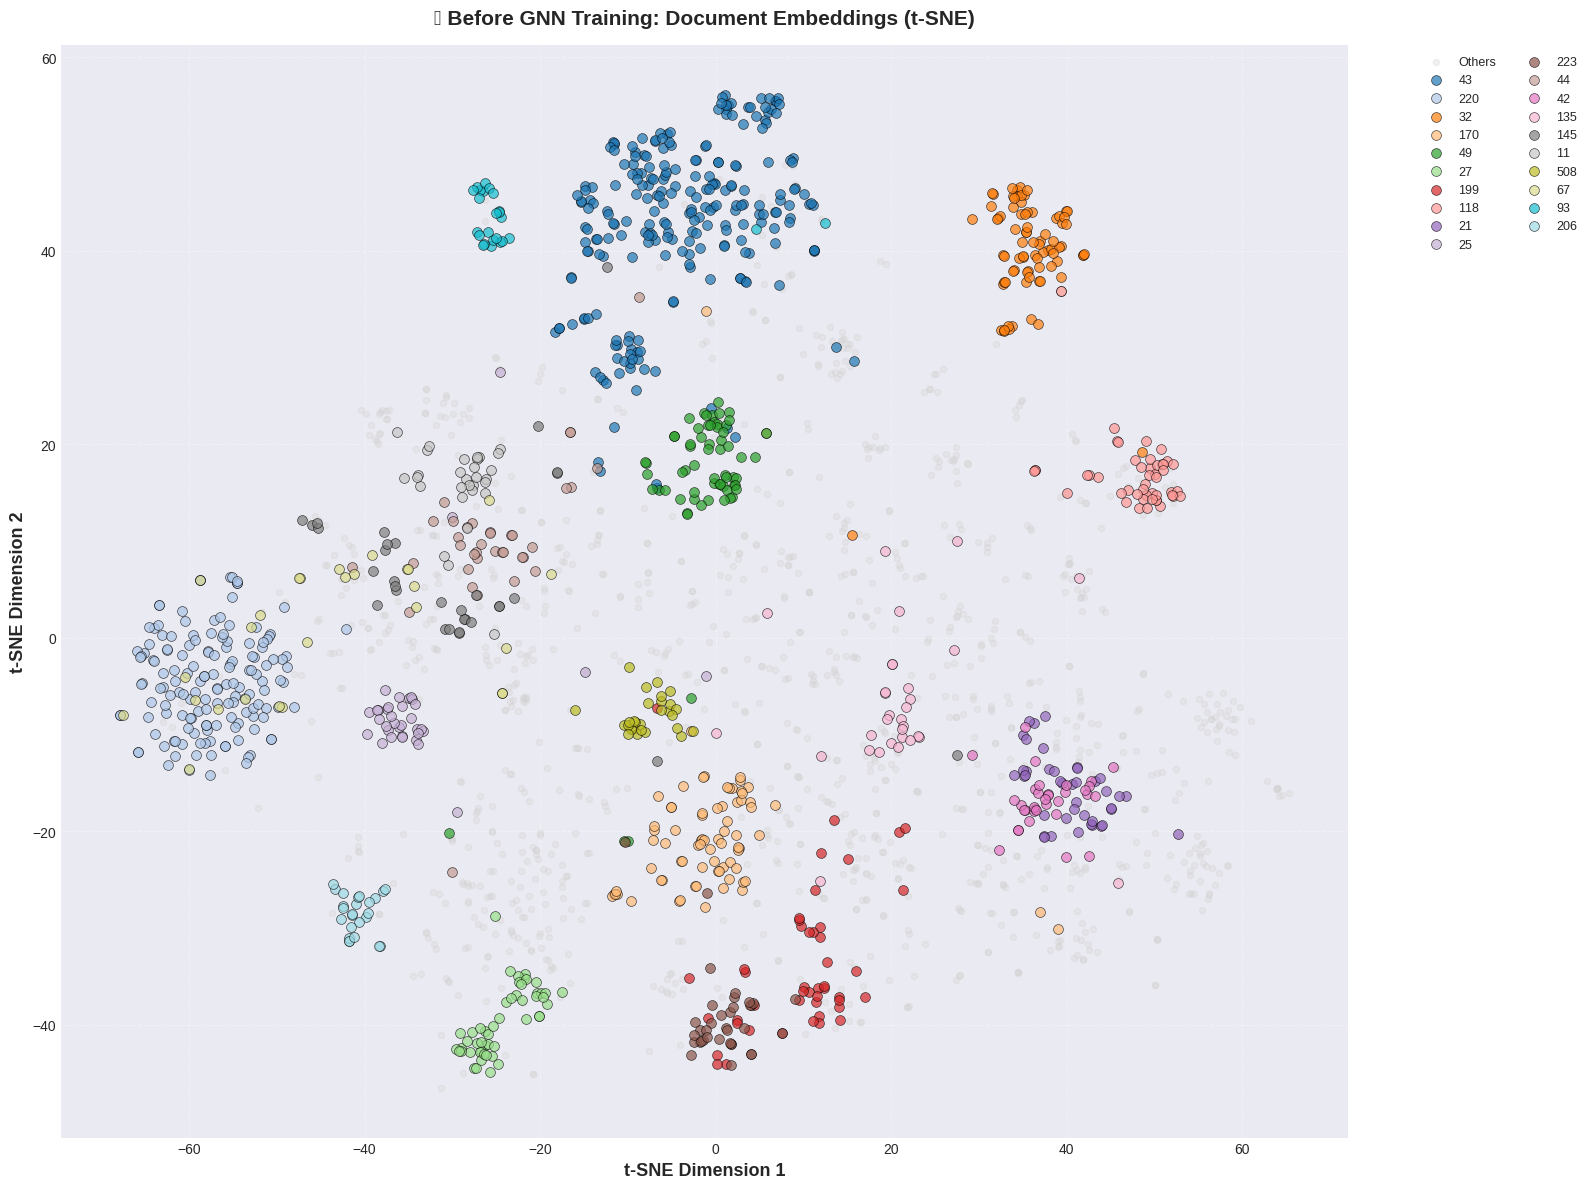

In [109]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "=" * 80)
print("📊 Step 9B-4-1: GNN 학습 전 t-SNE 시각화")
print("=" * 80)

# Train/Val 데이터에서 샘플링
max_samples_gnn = 3000

# Train에서 샘플링
if len(X_train) > max_samples_gnn // 2:
    train_sample_idx_gnn_pre = np.random.choice(len(X_train), max_samples_gnn // 2, replace=False)
    emb_train_sample_gnn_pre = X_train[train_sample_idx_gnn_pre].cpu().numpy()
    y_train_sample_gnn_pre = y_train[train_sample_idx_gnn_pre].cpu().numpy()
else:
    emb_train_sample_gnn_pre = X_train.cpu().numpy()
    y_train_sample_gnn_pre = y_train.cpu().numpy()

# Val에서 샘플링
if len(X_val) > max_samples_gnn // 2:
    val_sample_idx_gnn_pre = np.random.choice(len(X_val), max_samples_gnn // 2, replace=False)
    emb_val_sample_gnn_pre = X_val[val_sample_idx_gnn_pre].cpu().numpy()
    y_val_sample_gnn_pre = y_val[val_sample_idx_gnn_pre].cpu().numpy()
else:
    emb_val_sample_gnn_pre = X_val.cpu().numpy()
    y_val_sample_gnn_pre = y_val.cpu().numpy()

# 합치기
all_embeddings_gnn_pre = np.vstack([emb_train_sample_gnn_pre, emb_val_sample_gnn_pre])
all_labels_gnn_pre = np.vstack([y_train_sample_gnn_pre, y_val_sample_gnn_pre])

# 각 문서의 주요 클래스 선택
main_class_idx_gnn_pre = []
for doc_labels in all_labels_gnn_pre:
    active_classes = np.where(doc_labels > 0)[0]
    if len(active_classes) > 0:
        main_class_idx_gnn_pre.append(active_classes[0])
    else:
        main_class_idx_gnn_pre.append(-1)

main_class_idx_gnn_pre = np.array(main_class_idx_gnn_pre)

print(f"📊 시각화 데이터:")
print(f"  - Train samples: {len(emb_train_sample_gnn_pre)}")
print(f"  - Val samples: {len(emb_val_sample_gnn_pre)}")
print(f"  - Total samples: {len(all_embeddings_gnn_pre)}")
print(f"  - Unique classes: {len(np.unique(main_class_idx_gnn_pre[main_class_idx_gnn_pre >= 0]))}")

# t-SNE 실행
print(f"\n🔄 t-SNE 실행 중 (GNN 학습 전)...")
tsne_gnn_pre = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d_gnn_pre = tsne_gnn_pre.fit_transform(all_embeddings_gnn_pre)

print(f"✅ t-SNE 완료")

# 시각화
fig, ax = plt.subplots(figsize=(16, 12))

# 상위 20개 클래스만 색상으로 표시
unique_classes_gnn_pre, counts_gnn_pre = np.unique(main_class_idx_gnn_pre[main_class_idx_gnn_pre >= 0], return_counts=True)
top_k_classes_gnn_pre = unique_classes_gnn_pre[np.argsort(-counts_gnn_pre)[:20]]

# 색상 팔레트
colors_gnn = plt.cm.tab20(np.linspace(0, 1, 20))

# 배경 (기타 클래스)
other_mask_gnn_pre = ~np.isin(main_class_idx_gnn_pre, top_k_classes_gnn_pre)
ax.scatter(embeddings_2d_gnn_pre[other_mask_gnn_pre, 0], embeddings_2d_gnn_pre[other_mask_gnn_pre, 1],
           c='lightgray', alpha=0.3, s=20, label='Others')

# 상위 20개 클래스
for i, cls_idx in enumerate(top_k_classes_gnn_pre):
    mask = main_class_idx_gnn_pre == cls_idx
    class_name = class_ids_list[cls_idx]

    ax.scatter(embeddings_2d_gnn_pre[mask, 0], embeddings_2d_gnn_pre[mask, 1],
               c=[colors_gnn[i]], alpha=0.7, s=50, label=class_name, edgecolors='black', linewidth=0.5)

ax.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
ax.set_title('📊 Before GNN Training: Document Embeddings (t-SNE)', fontsize=15, fontweight='bold', pad=15)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("=" * 80)

In [110]:
print("\n" + "=" * 80)
print("🔧 Step 9B-5: GNN Self-Training")
print("=" * 80)

@torch.no_grad()
def generate_pseudo_labels_gnn(model, embeddings, class_emb, adj_matrix, confidence_thr=0.6, top_k=3):
    """GNN으로 pseudo-label 생성"""
    model.eval()

    all_probs = []
    batch_size = 256

    for i in range(0, len(embeddings), batch_size):
        batch = embeddings[i:i+batch_size].to(device)
        logits = model(batch, class_emb, adj_matrix)
        probs = torch.sigmoid(logits).cpu()
        all_probs.append(probs)

    all_probs = torch.cat(all_probs, dim=0)

    # Top-k 선택 (confidence threshold 적용)
    pseudo_labels = torch.zeros_like(all_probs)
    selected_mask = torch.zeros(len(all_probs), dtype=torch.bool)

    for i in range(len(all_probs)):
        probs = all_probs[i]
        topk_vals, topk_idx = torch.topk(probs, k=top_k)

        # Confidence 이상인 것만 선택
        mask = topk_vals >= confidence_thr
        if mask.sum() > 0:
            pseudo_labels[i, topk_idx[mask]] = 1.0
            selected_mask[i] = True

    return pseudo_labels, all_probs, selected_mask

# GNN Self-Training
gnn_st_history = {
    "iteration": [],
    "num_labeled": [],
    "train_loss": [],
    "val_f1": []
}

best_gnn_overall_f1 = best_gnn_f1
best_gnn_model_state = {k: v.cpu() for k, v in gnn_model.state_dict().items()}

print(f"GNN 초기 상태:")
print(f"  - Labeled documents: {len(initial_labels):,}")
print(f"  - Best F1: {best_gnn_overall_f1:.4f}")
print("-" * 80)

for iteration in range(1, NUM_ITERATIONS + 1):
    print(f"\n{'='*80}")
    print(f"🔄 GNN Iteration {iteration}/{NUM_ITERATIONS}")
    print(f"{'='*80}")

    # 1. Pseudo-label 생성
    print(f"\n📊 Generating pseudo-labels with GNN...")
    pseudo_labels_gnn, pseudo_scores_gnn, selected_mask_gnn = generate_pseudo_labels_gnn(
        gnn_model,
        train_embeddings,
        class_embeddings,
        adj_matrix_norm,
        confidence_thr=PSEUDO_CONFIDENCE,
        top_k=PSEUDO_TOP_K
    )

    num_pseudo_gnn = selected_mask_gnn.sum().item()
    print(f"✅ Pseudo-labeled: {num_pseudo_gnn:,} / {len(train_embeddings):,} ({num_pseudo_gnn/len(train_embeddings)*100:.1f}%)")

    if num_pseudo_gnn == 0:
        print("⚠️ No pseudo-labels generated. Stopping.")
        break

    # 2. 데이터 구성
    combined_labels_gnn = initial_labels.copy()
    combined_indices_gnn = initial_indices.copy()

    high_conf_indices = set([d['doc_index'] for d in high_conf_silver_labels])
    new_pseudo_idx_gnn = []
    new_pseudo_labels_gnn = []

    for i in range(len(train_embeddings)):
        if selected_mask_gnn[i] and i not in high_conf_indices:
            new_pseudo_idx_gnn.append(i)
            new_pseudo_labels_gnn.append(pseudo_labels_gnn[i].numpy())

    if len(new_pseudo_idx_gnn) > 0:
        combined_labels_gnn = np.vstack([combined_labels_gnn, np.array(new_pseudo_labels_gnn)])
        combined_indices_gnn = np.concatenate([combined_indices_gnn, new_pseudo_idx_gnn])

    print(f"📦 Combined dataset:")
    print(f"  - High-confidence: {len(initial_labels):,}")
    print(f"  - New pseudo: {len(new_pseudo_idx_gnn):,}")
    print(f"  - Total: {len(combined_labels_gnn):,}")

    # 3. DataLoader
    train_idx_gnn, val_idx_gnn = train_test_split(
        np.arange(len(combined_labels_gnn)),
        test_size=0.15,
        random_state=42+iteration
    )

    y_train_gnn = torch.from_numpy(combined_labels_gnn[train_idx_gnn]).float()
    y_val_gnn = torch.from_numpy(combined_labels_gnn[val_idx_gnn]).float()

    emb_train_gnn = train_embeddings[combined_indices_gnn[train_idx_gnn]].detach().cpu()
    emb_val_gnn = train_embeddings[combined_indices_gnn[val_idx_gnn]].detach().cpu()

    train_loader_gnn = DataLoader(
        TensorDataset(emb_train_gnn, y_train_gnn),
        batch_size=64,
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader_gnn = DataLoader(
        TensorDataset(emb_val_gnn, y_val_gnn),
        batch_size=128,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )

    # 4. 재학습
    print(f"\n🔥 Re-training GNN with expanded dataset...")

    gnn_optimizer = torch.optim.AdamW(gnn_model.parameters(), lr=5e-4, weight_decay=0.01)
    gnn_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(gnn_optimizer, T_max=ST_EPOCHS)

    for epoch in range(ST_EPOCHS):
        gnn_model.train()
        total_loss = 0.0

        for x, y in train_loader_gnn:
            x = x.to(device)
            y = y.to(device)

            gnn_optimizer.zero_grad()

            logits = gnn_model(x, class_embeddings, adj_matrix_norm)
            loss = gnn_criterion(logits, y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(gnn_model.parameters(), 1.0)
            gnn_optimizer.step()

            total_loss += loss.item()

        gnn_scheduler.step()

    # 5. Validation
    gnn_model.eval()
    tp = fp = fn = 0

    with torch.no_grad():
        for x, y in val_loader_gnn:
            x = x.to(device)
            y = y.to(device)

            logits = gnn_model(x, class_embeddings, adj_matrix_norm)
            probs = torch.sigmoid(logits)
            preds = topk_predict(probs, k=TOP_K, min_prob=BEST_THRESHOLD)

            yb = (y > 0).float()

            tp += (preds * yb).sum().item()
            fp += (preds * (1 - yb)).sum().item()
            fn += ((1 - preds) * yb).sum().item()

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    final_f1_gnn = 2 * precision * recall / (precision + recall + 1e-8)

    gnn_st_history["iteration"].append(iteration)
    gnn_st_history["num_labeled"].append(len(combined_labels_gnn))
    gnn_st_history["train_loss"].append(total_loss / len(train_loader_gnn))
    gnn_st_history["val_f1"].append(final_f1_gnn)

    print(f"\n📊 GNN Iteration {iteration} 결과:")
    print(f"  - Labeled docs: {len(combined_labels_gnn):,}")
    print(f"  - F1: {final_f1_gnn:.4f}")

    if final_f1_gnn > best_gnn_overall_f1:
        best_gnn_overall_f1 = final_f1_gnn
        best_gnn_model_state = {k: v.cpu() for k, v in gnn_model.state_dict().items()}
        print(f"  ✨ New best GNN model saved!")

print(f"\n{'='*80}")
print(f"✅ GNN Self-Training 완료!")
print(f"  - Best F1: {best_gnn_overall_f1:.4f}")
print(f"{'='*80}")

# Best model 로드
gnn_model.load_state_dict(best_gnn_model_state)
print("✅ Best GNN model loaded")


🔧 Step 9B-5: GNN Self-Training
GNN 초기 상태:
  - Labeled documents: 5,206
  - Best F1: 0.5975
--------------------------------------------------------------------------------

🔄 GNN Iteration 1/3

📊 Generating pseudo-labels with GNN...
✅ Pseudo-labeled: 37,060 / 49,145 (75.4%)
📦 Combined dataset:
  - High-confidence: 5,206
  - New pseudo: 31,996
  - Total: 37,202

🔥 Re-training GNN with expanded dataset...

📊 GNN Iteration 1 결과:
  - Labeled docs: 37,202
  - F1: 0.6456
  ✨ New best GNN model saved!

🔄 GNN Iteration 2/3

📊 Generating pseudo-labels with GNN...
✅ Pseudo-labeled: 42,923 / 49,145 (87.3%)
📦 Combined dataset:
  - High-confidence: 5,206
  - New pseudo: 37,897
  - Total: 43,103

🔥 Re-training GNN with expanded dataset...

📊 GNN Iteration 2 결과:
  - Labeled docs: 43,103
  - F1: 0.7550
  ✨ New best GNN model saved!

🔄 GNN Iteration 3/3

📊 Generating pseudo-labels with GNN...
✅ Pseudo-labeled: 45,362 / 49,145 (92.3%)
📦 Combined dataset:
  - High-confidence: 5,206
  - New pseudo: 40,30


📊 Step 9B-6-1: GNN 학습 후 t-SNE 시각화
📊 시각화 데이터:
  - Train samples: 1500
  - Val samples: 781
  - Total samples: 2281
  - Unique classes: 126

🔄 t-SNE 실행 중 (GNN 학습 후)...
✅ t-SNE 완료


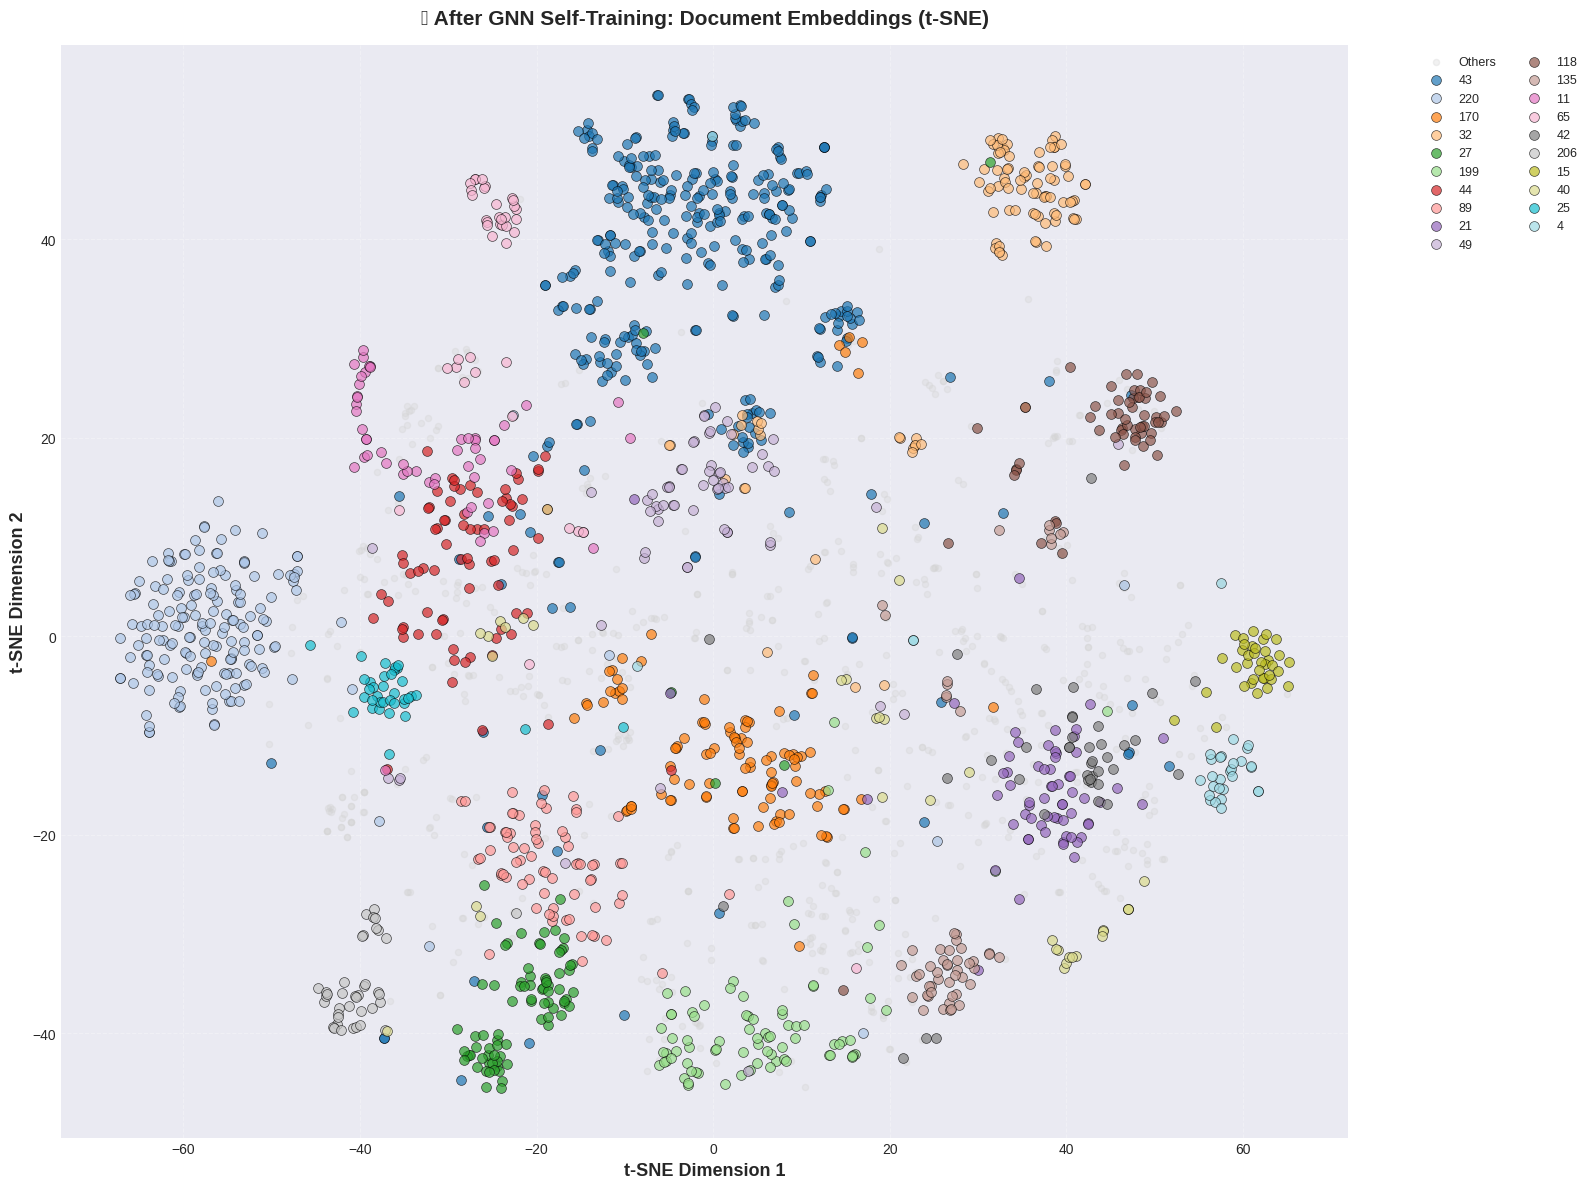

In [111]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "=" * 80)
print("📊 Step 9B-6-1: GNN 학습 후 t-SNE 시각화")
print("=" * 80)

# GNN Self-Training 후 최종 레이블로 샘플링
max_samples_gnn_post = 3000

# GNN Self-Training 후 데이터 (final_gnn_labeled_embeddings, final_gnn_labeled_labels 사용)
# 여기서는 train/val split을 유지하며 시각화
if len(X_train) > max_samples_gnn_post // 2:
    train_sample_idx_gnn_post = np.random.choice(len(X_train), max_samples_gnn_post // 2, replace=False)
    emb_train_sample_gnn_post = X_train[train_sample_idx_gnn_post].cpu().numpy()
    # GNN 예측 결과로 레이블 생성
    with torch.no_grad():
        gnn_model.eval()
        gnn_logits_train = gnn_model(X_train[train_sample_idx_gnn_post].to(device), class_embeddings.to(device), adj_matrix_norm)
        gnn_probs_train = torch.sigmoid(gnn_logits_train)
        gnn_preds_train = topk_predict(gnn_probs_train, k=TOP_K, min_prob=BEST_THRESHOLD).cpu().numpy()
else:
    emb_train_sample_gnn_post = X_train.cpu().numpy()
    with torch.no_grad():
        gnn_model.eval()
        gnn_logits_train = gnn_model(X_train.to(device), class_embeddings.to(device), adj_matrix_norm)
        gnn_probs_train = torch.sigmoid(gnn_logits_train)
        gnn_preds_train = topk_predict(gnn_probs_train, k=TOP_K, min_prob=BEST_THRESHOLD).cpu().numpy()

if len(X_val) > max_samples_gnn_post // 2:
    val_sample_idx_gnn_post = np.random.choice(len(X_val), max_samples_gnn_post // 2, replace=False)
    emb_val_sample_gnn_post = X_val[val_sample_idx_gnn_post].cpu().numpy()
    with torch.no_grad():
        gnn_model.eval()
        gnn_logits_val = gnn_model(X_val[val_sample_idx_gnn_post].to(device), class_embeddings.to(device), adj_matrix_norm)
        gnn_probs_val = torch.sigmoid(gnn_logits_val)
        gnn_preds_val = topk_predict(gnn_probs_val, k=TOP_K, min_prob=BEST_THRESHOLD).cpu().numpy()
else:
    emb_val_sample_gnn_post = X_val.cpu().numpy()
    with torch.no_grad():
        gnn_model.eval()
        gnn_logits_val = gnn_model(X_val.to(device), class_embeddings.to(device), adj_matrix_norm)
        gnn_probs_val = torch.sigmoid(gnn_logits_val)
        gnn_preds_val = topk_predict(gnn_probs_val, k=TOP_K, min_prob=BEST_THRESHOLD).cpu().numpy()

# 합치기
all_embeddings_gnn_post = np.vstack([emb_train_sample_gnn_post, emb_val_sample_gnn_post])
all_labels_gnn_post = np.vstack([gnn_preds_train, gnn_preds_val])

# 각 문서의 주요 클래스 선택
main_class_idx_gnn_post = []
for doc_labels in all_labels_gnn_post:
    active_classes = np.where(doc_labels > 0)[0]
    if len(active_classes) > 0:
        main_class_idx_gnn_post.append(active_classes[0])
    else:
        main_class_idx_gnn_post.append(-1)

main_class_idx_gnn_post = np.array(main_class_idx_gnn_post)

print(f"📊 시각화 데이터:")
print(f"  - Train samples: {len(emb_train_sample_gnn_post)}")
print(f"  - Val samples: {len(emb_val_sample_gnn_post)}")
print(f"  - Total samples: {len(all_embeddings_gnn_post)}")
print(f"  - Unique classes: {len(np.unique(main_class_idx_gnn_post[main_class_idx_gnn_post >= 0]))}")

# t-SNE 실행
print(f"\n🔄 t-SNE 실행 중 (GNN 학습 후)...")
tsne_gnn_post = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d_gnn_post = tsne_gnn_post.fit_transform(all_embeddings_gnn_post)

print(f"✅ t-SNE 완료")

# 시각화
fig, ax = plt.subplots(figsize=(16, 12))

# 상위 20개 클래스만 색상으로 표시
unique_classes_gnn_post, counts_gnn_post = np.unique(main_class_idx_gnn_post[main_class_idx_gnn_post >= 0], return_counts=True)
top_k_classes_gnn_post = unique_classes_gnn_post[np.argsort(-counts_gnn_post)[:20]]

# 색상 팔레트
colors_gnn_post = plt.cm.tab20(np.linspace(0, 1, 20))

# 배경 (기타 클래스)
other_mask_gnn_post = ~np.isin(main_class_idx_gnn_post, top_k_classes_gnn_post)
ax.scatter(embeddings_2d_gnn_post[other_mask_gnn_post, 0], embeddings_2d_gnn_post[other_mask_gnn_post, 1],
           c='lightgray', alpha=0.3, s=20, label='Others')

# 상위 20개 클래스
for i, cls_idx in enumerate(top_k_classes_gnn_post):
    mask = main_class_idx_gnn_post == cls_idx
    class_name = class_ids_list[cls_idx]

    ax.scatter(embeddings_2d_gnn_post[mask, 0], embeddings_2d_gnn_post[mask, 1],
               c=[colors_gnn_post[i]], alpha=0.7, s=50, label=class_name, edgecolors='black', linewidth=0.5)

ax.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
ax.set_title('📊 After GNN Self-Training: Document Embeddings (t-SNE)', fontsize=15, fontweight='bold', pad=15)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("=" * 80)


📊 Step 9B-6: Hierarchical Loss vs GNN 비교


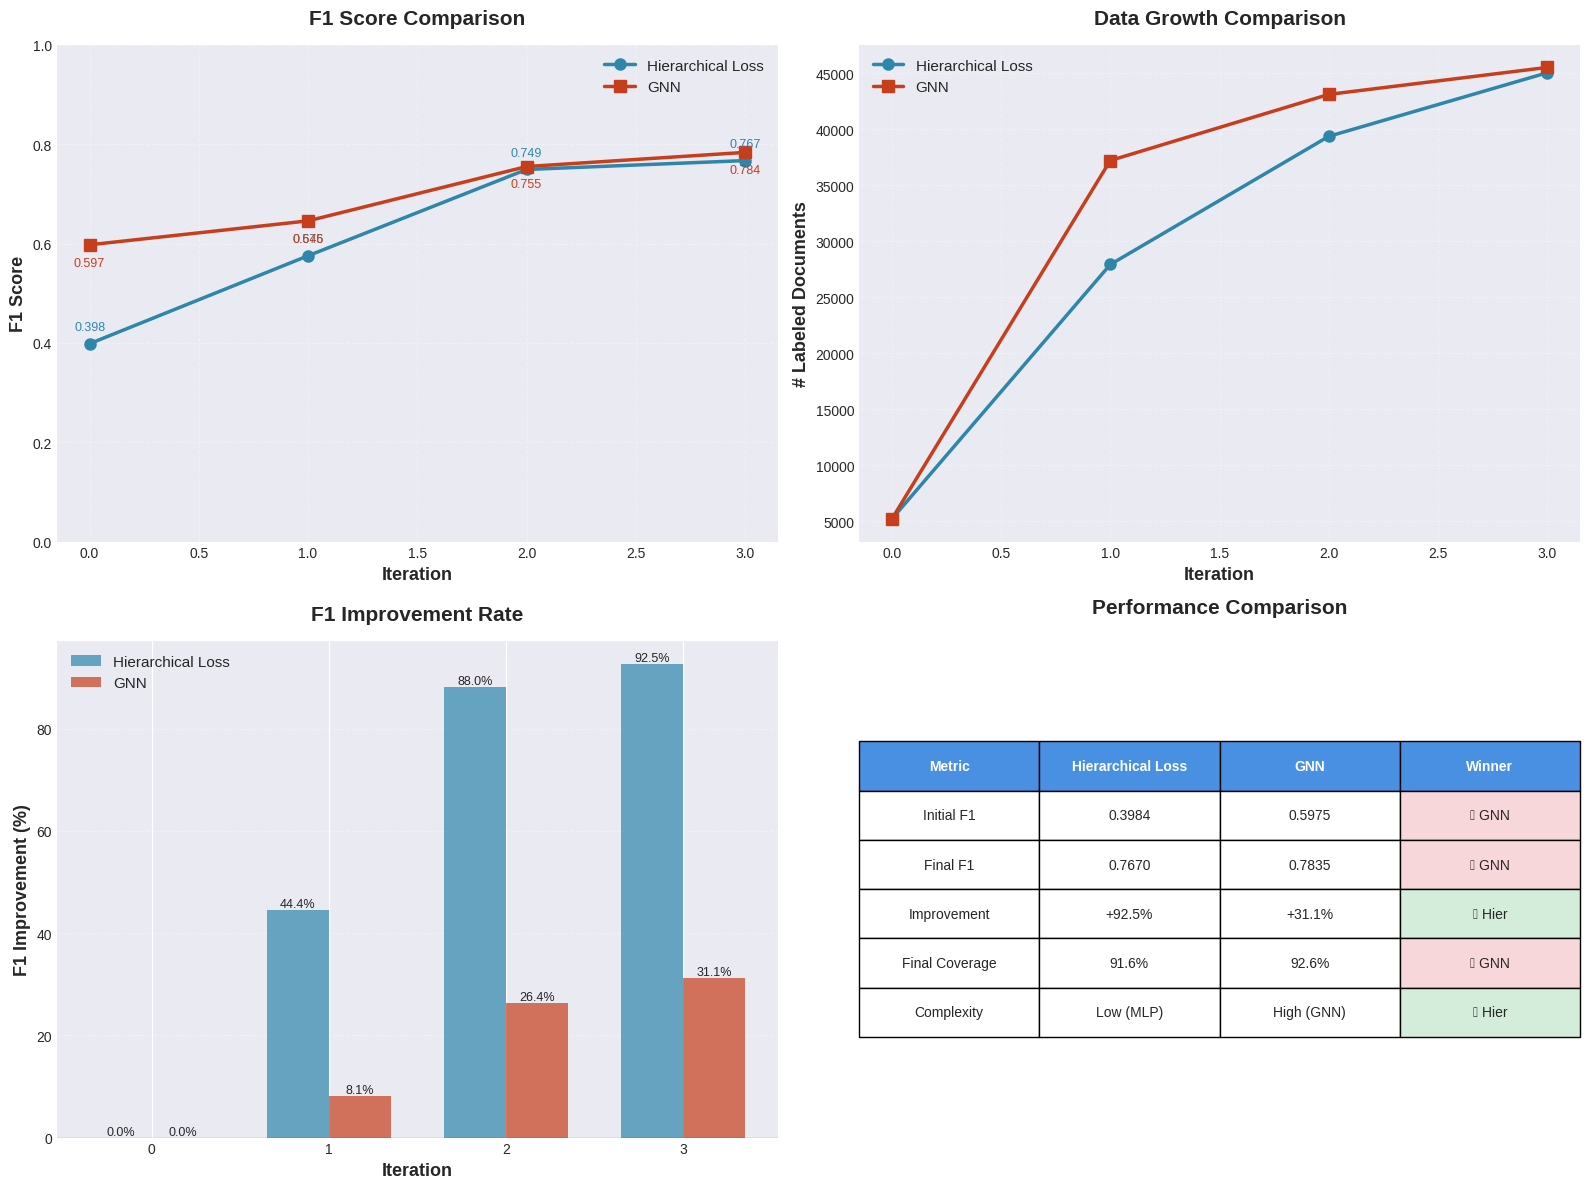


📊 최종 비교 결과:

🔵 Hierarchical Loss (MLP):
  - Initial F1: 0.3984
  - Final F1: 0.7670 (+92.5%)
  - Final Coverage: 91.6%
  - Complexity: Low

🔴 GNN-based:
  - Initial F1: 0.5975
  - Final F1: 0.7835 (+31.1%)
  - Final Coverage: 92.6%
  - Complexity: High

🏆 Winner: GNN
  - F1 차이: 0.0165



In [112]:
import matplotlib.pyplot as plt

print("\n" + "=" * 80)
print("📊 Step 9B-6: Hierarchical Loss vs GNN 비교")
print("=" * 80)

# 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. F1 Score 비교
iterations_comp = [0] + st_history["iteration"]
hier_f1 = [max(hier_history['val_f1'])] + st_history["val_f1"]
gnn_f1 = [best_gnn_f1] + gnn_st_history["val_f1"]

axes[0, 0].plot(iterations_comp, hier_f1, marker="o", linewidth=2.5,
                markersize=8, color='#2E86AB', label='Hierarchical Loss')
axes[0, 0].plot(iterations_comp, gnn_f1, marker="s", linewidth=2.5,
                markersize=8, color='#C73E1D', label='GNN')
axes[0, 0].set_xlabel("Iteration", fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel("F1 Score", fontsize=13, fontweight='bold')
axes[0, 0].set_title("F1 Score Comparison", fontsize=15, fontweight='bold', pad=15)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')
axes[0, 0].set_ylim([0, 1])

# 값 표시
for i, (x, y1, y2) in enumerate(zip(iterations_comp, hier_f1, gnn_f1)):
    axes[0, 0].annotate(f'{y1:.3f}', (x, y1), textcoords="offset points",
                        xytext=(0, 10), ha='center', fontsize=9, color='#2E86AB')
    axes[0, 0].annotate(f'{y2:.3f}', (x, y2), textcoords="offset points",
                        xytext=(0, -15), ha='center', fontsize=9, color='#C73E1D')

# 2. Labeled Data Growth 비교
hier_labeled = [len(initial_labels)] + st_history["num_labeled"]
gnn_labeled = [len(initial_labels)] + gnn_st_history["num_labeled"]

axes[0, 1].plot(iterations_comp, hier_labeled, marker="o", linewidth=2.5,
                markersize=8, color='#2E86AB', label='Hierarchical Loss')
axes[0, 1].plot(iterations_comp, gnn_labeled, marker="s", linewidth=2.5,
                markersize=8, color='#C73E1D', label='GNN')
axes[0, 1].set_xlabel("Iteration", fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel("# Labeled Documents", fontsize=13, fontweight='bold')
axes[0, 1].set_title("Data Growth Comparison", fontsize=15, fontweight='bold', pad=15)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3, linestyle='--')

# 3. F1 향상률
hier_improvement = [(f - hier_f1[0]) / hier_f1[0] * 100 for f in hier_f1]
gnn_improvement = [(f - gnn_f1[0]) / gnn_f1[0] * 100 for f in gnn_f1]

x = np.arange(len(iterations_comp))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, hier_improvement, width,
                       label='Hierarchical Loss', color='#2E86AB', alpha=0.7)
bars2 = axes[1, 0].bar(x + width/2, gnn_improvement, width,
                       label='GNN', color='#C73E1D', alpha=0.7)

axes[1, 0].set_xlabel("Iteration", fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel("F1 Improvement (%)", fontsize=13, fontweight='bold')
axes[1, 0].set_title("F1 Improvement Rate", fontsize=15, fontweight='bold', pad=15)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(iterations_comp)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3, linestyle='--', axis='y')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# 값 표시
for bar in bars1:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 4. 최종 성능 비교 테이블
axes[1, 1].axis('off')

comparison_data = [
    ['Metric', 'Hierarchical Loss', 'GNN', 'Winner'],
    ['Initial F1', f'{hier_f1[0]:.4f}', f'{gnn_f1[0]:.4f}',
     '🏆 Hier' if hier_f1[0] > gnn_f1[0] else '🏆 GNN'],
    ['Final F1', f'{best_overall_f1:.4f}', f'{best_gnn_overall_f1:.4f}',
     '🏆 Hier' if best_overall_f1 > best_gnn_overall_f1 else '🏆 GNN'],
    ['Improvement', f'+{(best_overall_f1-hier_f1[0])/hier_f1[0]*100:.1f}%',
     f'+{(best_gnn_overall_f1-gnn_f1[0])/gnn_f1[0]*100:.1f}%',
     '🏆 Hier' if (best_overall_f1-hier_f1[0]) > (best_gnn_overall_f1-gnn_f1[0]) else '🏆 GNN'],
    ['Final Coverage', f'{st_history["num_labeled"][-1]/len(train_embeddings)*100:.1f}%',
     f'{gnn_st_history["num_labeled"][-1]/len(train_embeddings)*100:.1f}%',
     '🏆 Hier' if st_history["num_labeled"][-1] > gnn_st_history["num_labeled"][-1] else '🏆 GNN'],
    ['Complexity', 'Low (MLP)', 'High (GNN)', '🏆 Hier'],
]

table = axes[1, 1].table(cellText=comparison_data, cellLoc='center', loc='center',
                         colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# 헤더 스타일
for i in range(4):
    table[(0, i)].set_facecolor('#4A90E2')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Winner 열 스타일
for i in range(1, len(comparison_data)):
    if '🏆 Hier' in comparison_data[i][3]:
        table[(i, 3)].set_facecolor('#D4EDDA')
    elif '🏆 GNN' in comparison_data[i][3]:
        table[(i, 3)].set_facecolor('#F8D7DA')

axes[1, 1].set_title("Performance Comparison", fontsize=15, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print(f"📊 최종 비교 결과:")
print(f"{'='*80}")
print(f"\n🔵 Hierarchical Loss (MLP):")
print(f"  - Initial F1: {hier_f1[0]:.4f}")
print(f"  - Final F1: {best_overall_f1:.4f} (+{(best_overall_f1-hier_f1[0])/hier_f1[0]*100:.1f}%)")
print(f"  - Final Coverage: {st_history['num_labeled'][-1]/len(train_embeddings)*100:.1f}%")
print(f"  - Complexity: Low")

print(f"\n🔴 GNN-based:")
print(f"  - Initial F1: {gnn_f1[0]:.4f}")
print(f"  - Final F1: {best_gnn_overall_f1:.4f} (+{(best_gnn_overall_f1-gnn_f1[0])/gnn_f1[0]*100:.1f}%)")
print(f"  - Final Coverage: {gnn_st_history['num_labeled'][-1]/len(train_embeddings)*100:.1f}%")
print(f"  - Complexity: High")

print(f"\n🏆 Winner: {'Hierarchical Loss' if best_overall_f1 > best_gnn_overall_f1 else 'GNN'}")
print(f"  - F1 차이: {abs(best_overall_f1 - best_gnn_overall_f1):.4f}")

print(f"\n{'='*80}")


📊 Step 9B-6-2: 전체 모델 학습 전후 비교 시각화 (2x2)

📊 (1/4) Hierarchical Loss 학습 전 시각화...
   ✅ 완료 - 274 클래스

📊 (2/4) Hierarchical Loss 학습 후 시각화...
   🔄 t-SNE 실행 중...
   ✅ 완료 - 10 클래스

📊 (3/4) GNN 학습 전 시각화...
   ✅ 완료 - 282 클래스

📊 (4/4) GNN 학습 후 시각화...
   ✅ 완료 - 126 클래스


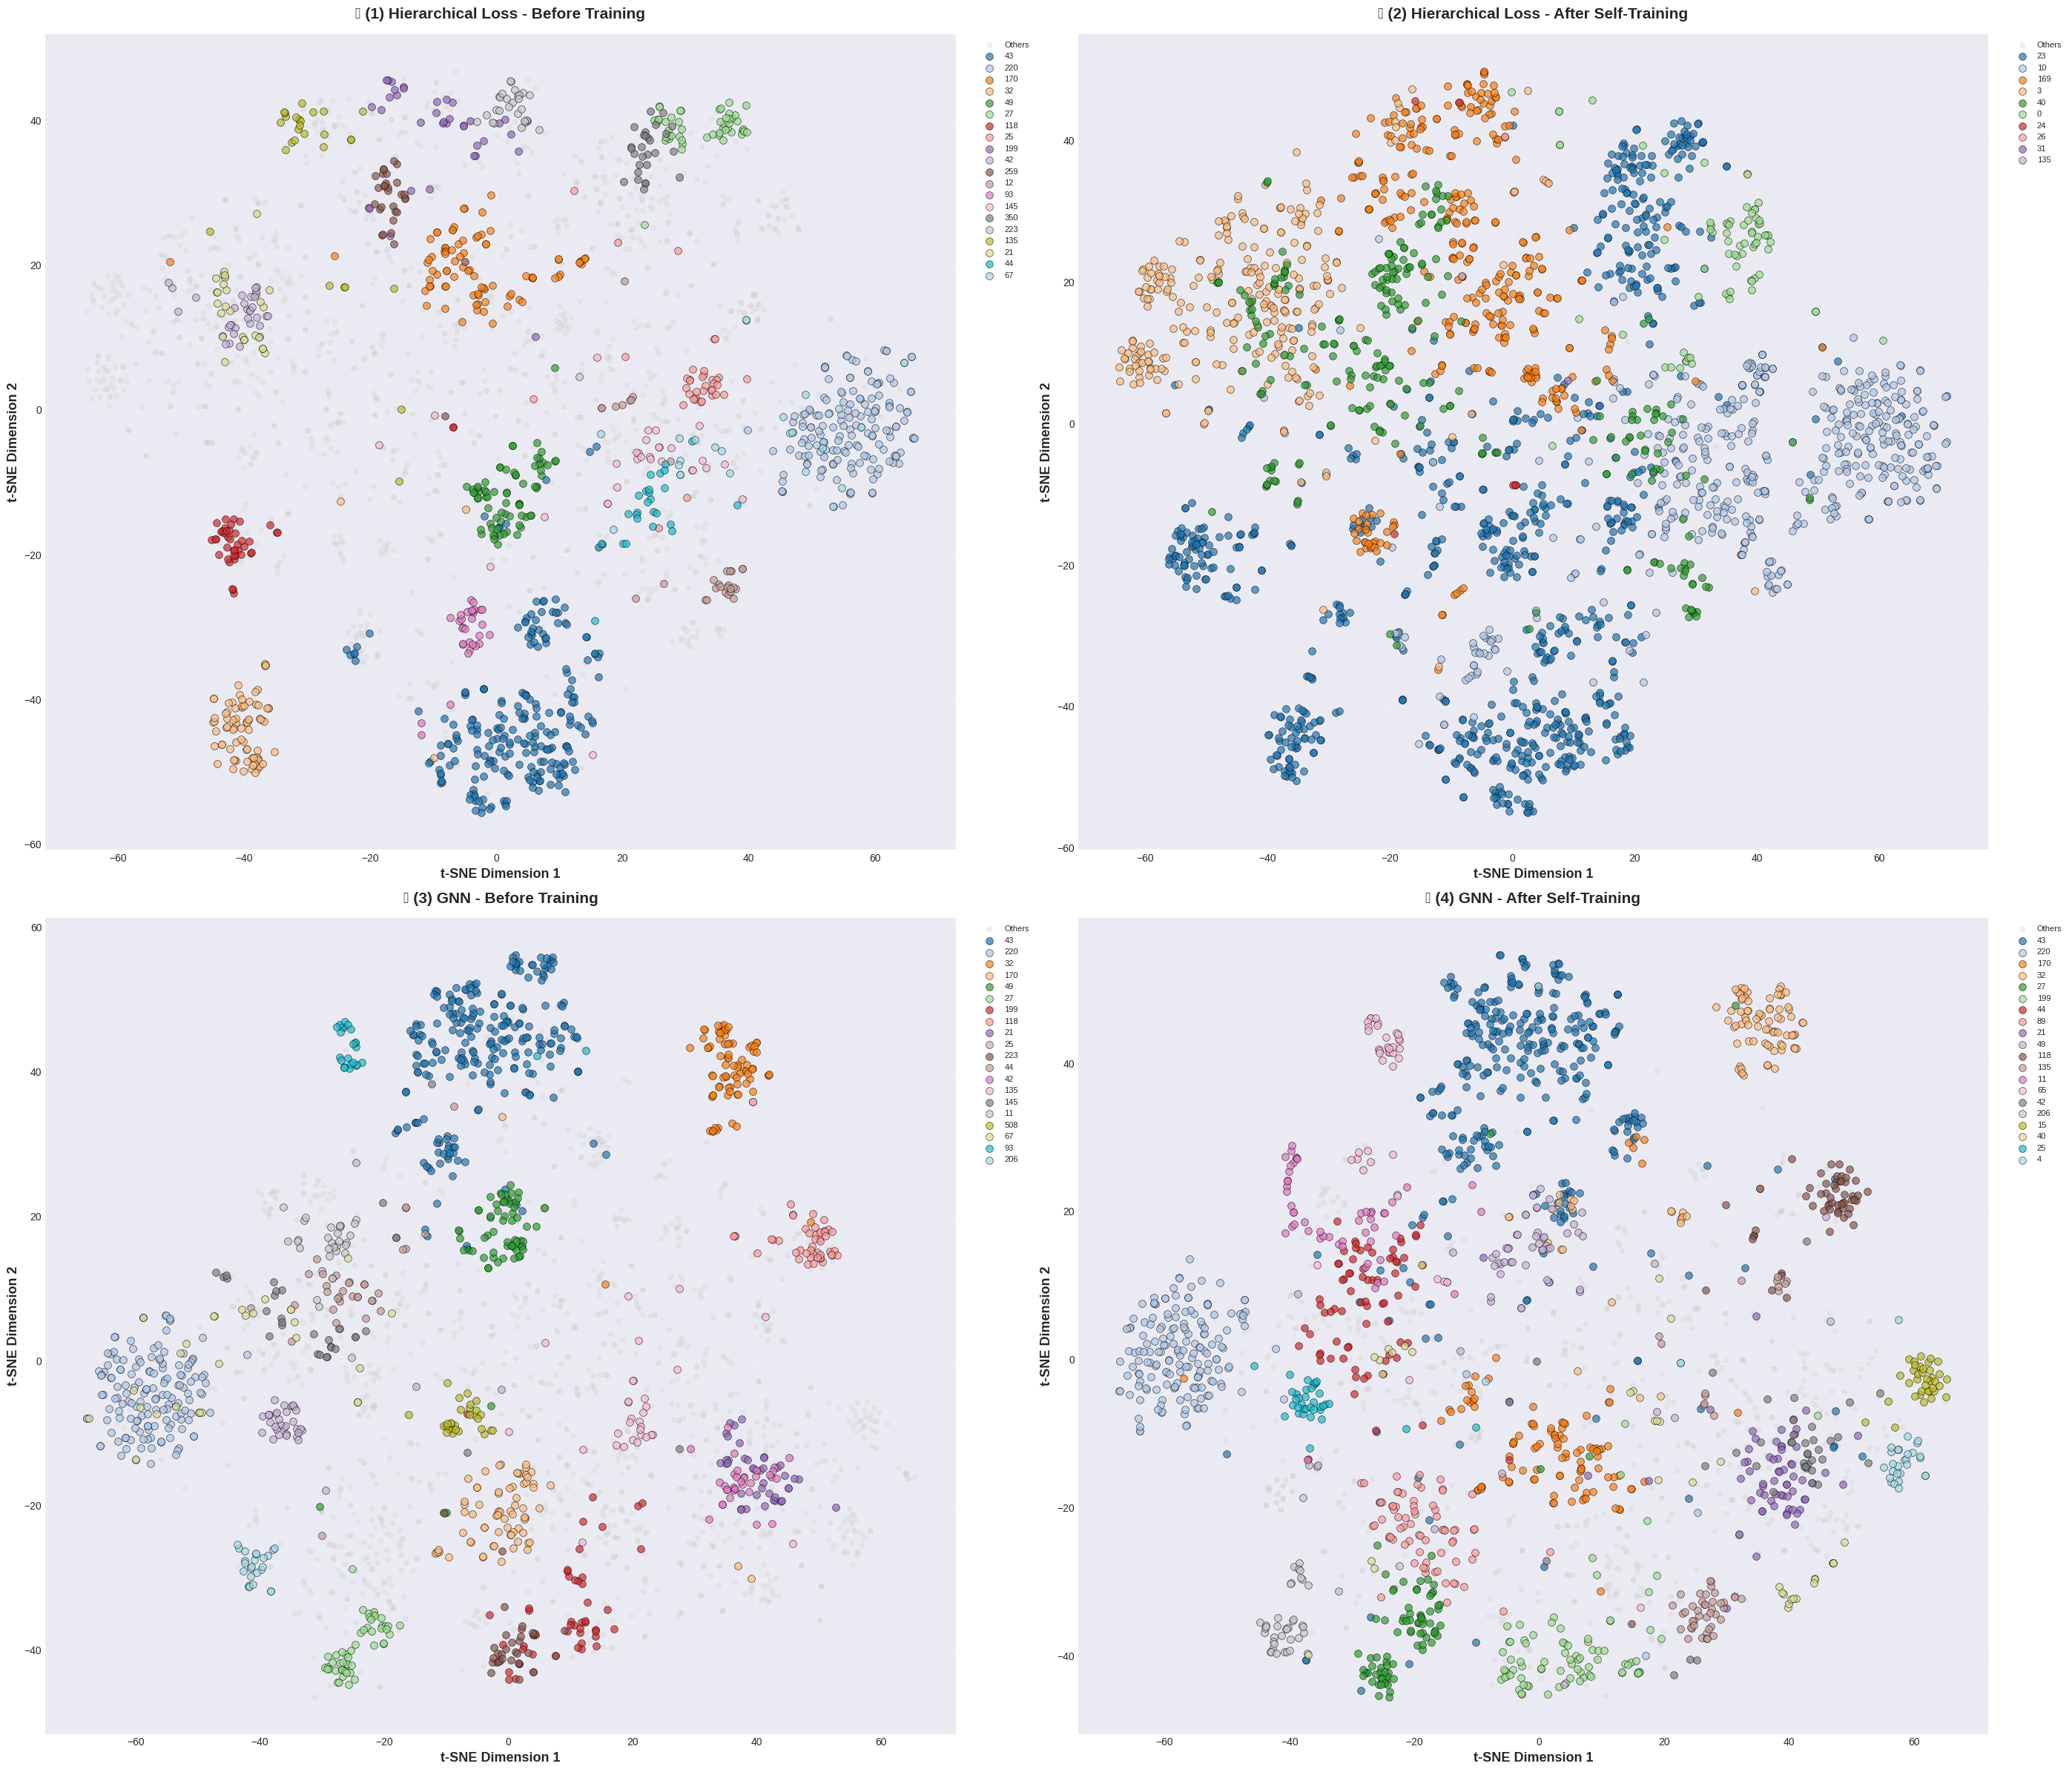


📊 전체 모델 학습 전후 비교 통계

🔵 Hierarchical Loss:
  - 학습 전 클래스 수: 274
  - 학습 후 클래스 수: 10
  - Best F1: 0.7670

🔴 GNN:
  - 학습 전 클래스 수: 282
  - 학습 후 클래스 수: 126
  - Best F1: 0.7835

💡 관찰 포인트:
  1. 클러스터 분리도: 학습 후 같은 클래스끼리 더 밀집되어 있는가?
  2. 계층 구조: 부모-자식 클래스가 인접하게 위치하는가?
  3. 모델 비교: Hierarchical Loss vs GNN의 클러스터링 품질 차이
  4. 경계 명확도: 각 모델이 클래스 간 경계를 얼마나 명확히 구분하는가?


In [113]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

print("\n" + "=" * 80)
print("📊 Step 9B-6-2: 전체 모델 학습 전후 비교 시각화 (2x2)")
print("=" * 80)

# 2x2 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(28, 24))

colors_comparison = plt.cm.tab20(np.linspace(0, 1, 20))

# ============================================================================
# 1. Hierarchical Loss 학습 전 (좌상) - Step 8-9 데이터 재사용
# ============================================================================
print("\n📊 (1/4) Hierarchical Loss 학습 전 시각화...")

# Step 8-9에서 이미 계산된 데이터 사용
unique_classes_hier_pre, counts_hier_pre = np.unique(main_class_idx[main_class_idx >= 0], return_counts=True)
top_k_classes_hier_pre = unique_classes_hier_pre[np.argsort(-counts_hier_pre)[:20]]

# 배경 (기타 클래스)
other_mask_hier_pre = ~np.isin(main_class_idx, top_k_classes_hier_pre)
axes[0, 0].scatter(embeddings_2d[other_mask_hier_pre, 0], embeddings_2d[other_mask_hier_pre, 1],
                   c='lightgray', alpha=0.3, s=20, label='Others')

# 상위 20개 클래스
for i, cls_idx in enumerate(top_k_classes_hier_pre):
    mask = main_class_idx == cls_idx
    class_name = class_ids_list[cls_idx]

    axes[0, 0].scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                       c=[colors_comparison[i]], alpha=0.7, s=50, label=class_name,
                       edgecolors='black', linewidth=0.5)

axes[0, 0].set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
axes[0, 0].set_title('📊 (1) Hierarchical Loss - Before Training', fontsize=15, fontweight='bold', pad=15)
axes[0, 0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8, ncol=1)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

print(f"   ✅ 완료 - {len(np.unique(main_class_idx[main_class_idx >= 0]))} 클래스")

# ============================================================================
# 2. Hierarchical Loss 학습 후 (우상) - Self-Training 결과
# ============================================================================
print("\n📊 (2/4) Hierarchical Loss 학습 후 시각화...")

# Self-Training 후 데이터로 t-SNE (새로 생성)
max_samples_hier_post = 3000

# Train에서 샘플링
if len(X_train) > max_samples_hier_post // 2:
    train_sample_idx_hier_post = np.random.choice(len(X_train), max_samples_hier_post // 2, replace=False)
    emb_train_sample_hier_post = X_train[train_sample_idx_hier_post].cpu().numpy()
    # Hierarchical 모델로 예측
    with torch.no_grad():
        hier_model.eval()
        hier_logits_train = hier_model(X_train[train_sample_idx_hier_post].to(device))
        hier_probs_train = torch.sigmoid(hier_logits_train)
        hier_preds_train = topk_predict(hier_probs_train, k=TOP_K, min_prob=BEST_THRESHOLD).cpu().numpy()
else:
    emb_train_sample_hier_post = X_train.cpu().numpy()
    with torch.no_grad():
        hier_model.eval()
        hier_logits_train = hier_model(X_train.to(device))
        hier_probs_train = torch.sigmoid(hier_logits_train)
        hier_preds_train = topk_predict(hier_probs_train, k=TOP_K, min_prob=BEST_THRESHOLD).cpu().numpy()

# Val에서 샘플링
if len(X_val) > max_samples_hier_post // 2:
    val_sample_idx_hier_post = np.random.choice(len(X_val), max_samples_hier_post // 2, replace=False)
    emb_val_sample_hier_post = X_val[val_sample_idx_hier_post].cpu().numpy()
    with torch.no_grad():
        hier_model.eval()
        hier_logits_val = hier_model(X_val[val_sample_idx_hier_post].to(device))
        hier_probs_val = torch.sigmoid(hier_logits_val)
        hier_preds_val = topk_predict(hier_probs_val, k=TOP_K, min_prob=BEST_THRESHOLD).cpu().numpy()
else:
    emb_val_sample_hier_post = X_val.cpu().numpy()
    with torch.no_grad():
        hier_model.eval()
        hier_logits_val = hier_model(X_val.to(device))
        hier_probs_val = torch.sigmoid(hier_logits_val)
        hier_preds_val = topk_predict(hier_probs_val, k=TOP_K, min_prob=BEST_THRESHOLD).cpu().numpy()

# 합치기
all_embeddings_hier_post = np.vstack([emb_train_sample_hier_post, emb_val_sample_hier_post])
all_labels_hier_post = np.vstack([hier_preds_train, hier_preds_val])

# 주요 클래스 선택
main_class_idx_hier_post = []
for doc_labels in all_labels_hier_post:
    active_classes = np.where(doc_labels > 0)[0]
    if len(active_classes) > 0:
        main_class_idx_hier_post.append(active_classes[0])
    else:
        main_class_idx_hier_post.append(-1)

main_class_idx_hier_post = np.array(main_class_idx_hier_post)

# t-SNE 실행
print(f"   🔄 t-SNE 실행 중...")
tsne_hier_post = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d_hier_post = tsne_hier_post.fit_transform(all_embeddings_hier_post)

# 시각화
unique_classes_hier_post, counts_hier_post = np.unique(main_class_idx_hier_post[main_class_idx_hier_post >= 0], return_counts=True)
top_k_classes_hier_post = unique_classes_hier_post[np.argsort(-counts_hier_post)[:20]]

other_mask_hier_post = ~np.isin(main_class_idx_hier_post, top_k_classes_hier_post)
axes[0, 1].scatter(embeddings_2d_hier_post[other_mask_hier_post, 0], embeddings_2d_hier_post[other_mask_hier_post, 1],
                   c='lightgray', alpha=0.3, s=20, label='Others')

for i, cls_idx in enumerate(top_k_classes_hier_post):
    mask = main_class_idx_hier_post == cls_idx
    class_name = class_ids_list[cls_idx]

    axes[0, 1].scatter(embeddings_2d_hier_post[mask, 0], embeddings_2d_hier_post[mask, 1],
                       c=[colors_comparison[i]], alpha=0.7, s=50, label=class_name,
                       edgecolors='black', linewidth=0.5)

axes[0, 1].set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
axes[0, 1].set_title('📊 (2) Hierarchical Loss - After Self-Training', fontsize=15, fontweight='bold', pad=15)
axes[0, 1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8, ncol=1)
axes[0, 1].grid(True, alpha=0.3, linestyle='--')

print(f"   ✅ 완료 - {len(np.unique(main_class_idx_hier_post[main_class_idx_hier_post >= 0]))} 클래스")

# ============================================================================
# 3. GNN 학습 전 (좌하) - 이미 계산된 데이터 사용
# ============================================================================
print("\n📊 (3/4) GNN 학습 전 시각화...")

unique_classes_gnn_pre, counts_gnn_pre = np.unique(main_class_idx_gnn_pre[main_class_idx_gnn_pre >= 0], return_counts=True)
top_k_classes_gnn_pre = unique_classes_gnn_pre[np.argsort(-counts_gnn_pre)[:20]]

other_mask_gnn_pre = ~np.isin(main_class_idx_gnn_pre, top_k_classes_gnn_pre)
axes[1, 0].scatter(embeddings_2d_gnn_pre[other_mask_gnn_pre, 0], embeddings_2d_gnn_pre[other_mask_gnn_pre, 1],
                   c='lightgray', alpha=0.3, s=20, label='Others')

for i, cls_idx in enumerate(top_k_classes_gnn_pre):
    mask = main_class_idx_gnn_pre == cls_idx
    class_name = class_ids_list[cls_idx]

    axes[1, 0].scatter(embeddings_2d_gnn_pre[mask, 0], embeddings_2d_gnn_pre[mask, 1],
                       c=[colors_comparison[i]], alpha=0.7, s=50, label=class_name,
                       edgecolors='black', linewidth=0.5)

axes[1, 0].set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
axes[1, 0].set_title('📊 (3) GNN - Before Training', fontsize=15, fontweight='bold', pad=15)
axes[1, 0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8, ncol=1)
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

print(f"   ✅ 완료 - {len(np.unique(main_class_idx_gnn_pre[main_class_idx_gnn_pre >= 0]))} 클래스")

# ============================================================================
# 4. GNN 학습 후 (우하) - 이미 계산된 데이터 사용
# ============================================================================
print("\n📊 (4/4) GNN 학습 후 시각화...")

unique_classes_gnn_post, counts_gnn_post = np.unique(main_class_idx_gnn_post[main_class_idx_gnn_post >= 0], return_counts=True)
top_k_classes_gnn_post = unique_classes_gnn_post[np.argsort(-counts_gnn_post)[:20]]

other_mask_gnn_post = ~np.isin(main_class_idx_gnn_post, top_k_classes_gnn_post)
axes[1, 1].scatter(embeddings_2d_gnn_post[other_mask_gnn_post, 0], embeddings_2d_gnn_post[other_mask_gnn_post, 1],
                   c='lightgray', alpha=0.3, s=20, label='Others')

for i, cls_idx in enumerate(top_k_classes_gnn_post):
    mask = main_class_idx_gnn_post == cls_idx
    class_name = class_ids_list[cls_idx]

    axes[1, 1].scatter(embeddings_2d_gnn_post[mask, 0], embeddings_2d_gnn_post[mask, 1],
                       c=[colors_comparison[i]], alpha=0.7, s=50, label=class_name,
                       edgecolors='black', linewidth=0.5)

axes[1, 1].set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
axes[1, 1].set_title('📊 (4) GNN - After Self-Training', fontsize=15, fontweight='bold', pad=15)
axes[1, 1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8, ncol=1)
axes[1, 1].grid(True, alpha=0.3, linestyle='--')

print(f"   ✅ 완료 - {len(np.unique(main_class_idx_gnn_post[main_class_idx_gnn_post >= 0]))} 클래스")

plt.tight_layout()
plt.show()

# ============================================================================
# 비교 통계
# ============================================================================
print("\n" + "=" * 80)
print("📊 전체 모델 학습 전후 비교 통계")
print("=" * 80)

print("\n🔵 Hierarchical Loss:")
print(f"  - 학습 전 클래스 수: {len(np.unique(main_class_idx[main_class_idx >= 0]))}")
print(f"  - 학습 후 클래스 수: {len(np.unique(main_class_idx_hier_post[main_class_idx_hier_post >= 0]))}")
print(f"  - Best F1: {best_overall_f1:.4f}")

print("\n🔴 GNN:")
print(f"  - 학습 전 클래스 수: {len(np.unique(main_class_idx_gnn_pre[main_class_idx_gnn_pre >= 0]))}")
print(f"  - 학습 후 클래스 수: {len(np.unique(main_class_idx_gnn_post[main_class_idx_gnn_post >= 0]))}")
print(f"  - Best F1: {best_gnn_overall_f1:.4f}")

print("\n💡 관찰 포인트:")
print("  1. 클러스터 분리도: 학습 후 같은 클래스끼리 더 밀집되어 있는가?")
print("  2. 계층 구조: 부모-자식 클래스가 인접하게 위치하는가?")
print("  3. 모델 비교: Hierarchical Loss vs GNN의 클러스터링 품질 차이")
print("  4. 경계 명확도: 각 모델이 클래스 간 경계를 얼마나 명확히 구분하는가?")

print("=" * 80)

---

## Step 10: 테스트 데이터 예측 및 CSV 생성

최종 학습된 모델로 테스트 데이터를 예측하고 제출용 CSV를 생성합니다.

**과정:**
1. 테스트 데이터 로드 및 임베딩
2. 모델 예측
3. 계층 일관성 적용
4. CSV 저장

In [56]:
print("=" * 80)
print("📊 Step 10-1: 테스트 데이터 로드")
print("=" * 80)

import os

# 테스트 임베딩 저장 경로
TEST_EMBEDDINGS_PATH = os.path.join(BASE_PATH, "test_embeddings.pt")

# 테스트 corpus 로드
test_pids = []
test_texts = []

print("📄 테스트 corpus 로딩 중...")
with open(TEST_CORPUS_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t', 1)
        if len(parts) == 2:
            pid, text = parts
            test_pids.append(pid)
            test_texts.append(text)

print(f"✅ 테스트 문서 수: {len(test_texts):,}")
print(f"   예시 PID: {test_pids[:3]}")

# 임베딩 로드 또는 생성
if os.path.exists(TEST_EMBEDDINGS_PATH):
    print(f"\n📂 저장된 임베딩 로드 중: {TEST_EMBEDDINGS_PATH}")
    test_embeddings_tensor = torch.load(TEST_EMBEDDINGS_PATH)
    print(f"✅ 테스트 임베딩 로드 완료: {test_embeddings_tensor.shape}")
else:
    print("\n🔢 테스트 임베딩 생성 중...")
    test_embeddings = model.encode(
        test_texts,
        batch_size=32,
        show_progress_bar=True,
        convert_to_tensor=True
    )
    test_embeddings_tensor = test_embeddings.to(device)
    print(f"✅ 테스트 임베딩 생성 완료: {test_embeddings_tensor.shape}")

    # 구글 드라이브에 저장
    print(f"\n💾 임베딩 저장 중: {TEST_EMBEDDINGS_PATH}")
    torch.save(test_embeddings_tensor.cpu(), TEST_EMBEDDINGS_PATH)
    print("✅ 저장 완료!")

    # 다시 GPU로 이동
    test_embeddings_tensor = test_embeddings_tensor.to(device)

print("=" * 80)

📊 Step 10-1: 테스트 데이터 로드
📄 테스트 corpus 로딩 중...
✅ 테스트 문서 수: 19,658
   예시 PID: ['0', '1', '2']

📂 저장된 임베딩 로드 중: /content/drive/MyDrive/Amazon_products/test_embeddings.pt
✅ 테스트 임베딩 로드 완료: torch.Size([19658, 1024])


In [57]:
print("\n" + "=" * 80)
print("🔧 Step 10-2: 계층 일관성 함수 정의")
print("=" * 80)

def apply_hierarchy_consistency(predictions, child_to_parents_dict, threshold=0.5):
    """
    예측에 계층 일관성 적용: 자식이 활성화되면 모든 조상도 활성화

    Args:
        predictions: (N, C) 확률 행렬
        child_to_parents_dict: 계층 구조 dict
        threshold: 활성화 임계값

    Returns:
        consistent_preds: 계층 일관성이 적용된 예측
    """
    N, C = predictions.shape
    consistent_preds = (predictions >= threshold).astype(int)

    for doc_idx in range(N):
        active_classes = np.where(consistent_preds[doc_idx] == 1)[0]

        # 각 활성 클래스의 조상들 찾아서 활성화
        for cls_idx in active_classes:
            # idx -> class_id 변환
            class_id = class_ids_list[cls_idx]

            # 조상 찾기
            if class_id in child_to_parents_dict:
                for parent_id in child_to_parents_dict[class_id]:
                    if parent_id in class2idx:
                        parent_idx = class2idx[parent_id]
                        consistent_preds[doc_idx, parent_idx] = 1

    return consistent_preds

def select_top_k_with_confidence(predictions, k_min=1, k_max=3, threshold=0.5):
    """
    각 문서에 대해 confidence threshold와 top-k를 함께 고려하여 레이블 선택

    Args:
        predictions: (N, C) 확률 행렬
        k_min: 최소 선택 레이블 수 (기본값: 1)
        k_max: 최대 선택 레이블 수 (기본값: 3, Kaggle 규칙)
        threshold: confidence 임계값

    Returns:
        selected_labels: 각 문서의 선택된 레이블 리스트
    """
    selected_labels = []

    for pred in predictions:
        # 임계값 이상인 클래스들
        above_threshold = np.where(pred >= threshold)[0]

        if len(above_threshold) == 0:
            # 임계값 이상이 없으면 최고 확률 1개
            top_cls = [np.argmax(pred)]
        else:
            # 임계값 이상 중에서 상위 k_max개
            top_indices = above_threshold[np.argsort(pred[above_threshold])[::-1]]
            top_cls = top_indices[:k_max].tolist()

            # 최소 k_min개 보장
            if len(top_cls) < k_min:
                remaining = np.setdiff1d(np.arange(len(pred)), top_cls)
                additional = remaining[np.argsort(pred[remaining])[::-1][:k_min - len(top_cls)]]
                top_cls.extend(additional.tolist())

        selected_labels.append(sorted(top_cls))

    return selected_labels

print("✅ 계층 일관성 함수 정의 완료!")
print("  - apply_hierarchy_consistency(): 자식 → 조상 활성화")
print("  - select_top_k_with_confidence(): 상위 K개 선택")
print("=" * 80)


🔧 Step 10-2: 계층 일관성 함수 정의
✅ 계층 일관성 함수 정의 완료!
  - apply_hierarchy_consistency(): 자식 → 조상 활성화
  - select_top_k_with_confidence(): 상위 K개 선택


In [58]:
print("\n" + "=" * 80)
print("🔮 Step 10-3: 두 모델로 테스트 예측")
print("=" * 80)

batch_size_test = 128

# ========================================
# 1. Hierarchical Loss 모델 예측
# ========================================
print("\n🔵 Hierarchical Loss 모델 예측 중...")
hier_model.eval()

device = next(hier_model.parameters()).device
hier_test_predictions = []

with torch.no_grad():
    for i in tqdm(range(0, len(test_embeddings_tensor), batch_size_test), desc="Hier 예측"):
        batch = test_embeddings_tensor[i:i+batch_size_test].to(device)
        logits = hier_model(batch)
        probs = torch.sigmoid(logits).cpu().numpy()
        hier_test_predictions.append(probs)

hier_test_predictions = np.vstack(hier_test_predictions)
print(f"✅ Hierarchical 예측 완료: {hier_test_predictions.shape}")

# 계층 일관성 적용
print("  🔗 계층 일관성 적용 중...")
hier_test_consistent = apply_hierarchy_consistency(
    hier_test_predictions,
    child_to_parents,
    threshold=0.5
)

# 레이블 선택 (1~3개)
print("  🎯 레이블 선택 중 (1~3개)...")
hier_final_labels = select_top_k_with_confidence(
    hier_test_predictions,
    k_min=1,
    k_max=3,
    threshold=0.5
)

# ========================================
# 2. GNN 모델 예측
# ========================================
print("\n🔴 GNN 모델 예측 중...")
gnn_model.eval()

device = next(gnn_model.parameters()).device
gnn_test_predictions = []

with torch.no_grad():
    for i in tqdm(range(0, len(test_embeddings_tensor), batch_size_test), desc="GNN 예측"):
        batch = test_embeddings_tensor[i:i+batch_size_test].to(device)
        logits = gnn_model(batch, class_embeddings, adj_matrix_norm)
        probs = torch.sigmoid(logits).cpu().numpy()
        gnn_test_predictions.append(probs)

gnn_test_predictions = np.vstack(gnn_test_predictions)
print(f"✅ GNN 예측 완료: {gnn_test_predictions.shape}")

# 계층 일관성 적용
print("  🔗 계층 일관성 적용 중...")
gnn_test_consistent = apply_hierarchy_consistency(
    gnn_test_predictions,
    child_to_parents,
    threshold=0.5
)

# 레이블 선택 (1~3개)
print("  🎯 레이블 선택 중 (1~3개)...")
gnn_final_labels = select_top_k_with_confidence(
    gnn_test_predictions,
    k_min=1,
    k_max=3,
    threshold=0.5
)

print("\n" + "=" * 80)
print("📊 예측 통계:")
print("=" * 80)

hier_label_counts = [len(labels) for labels in hier_final_labels]
gnn_label_counts = [len(labels) for labels in gnn_final_labels]

print(f"\n🔵 Hierarchical Loss:")
print(f"  - 평균 레이블 수: {np.mean(hier_label_counts):.2f}")
print(f"  - 최소/최대: {np.min(hier_label_counts)}/{np.max(hier_label_counts)}")
print(f"  - 중간값: {np.median(hier_label_counts):.1f}")

print(f"\n🔴 GNN:")
print(f"  - 평균 레이블 수: {np.mean(gnn_label_counts):.2f}")
print(f"  - 최소/최대: {np.min(gnn_label_counts)}/{np.max(gnn_label_counts)}")
print(f"  - 중간값: {np.median(gnn_label_counts):.1f}")

# 예측 일치율
agreement = sum(1 for h, g in zip(hier_final_labels, gnn_final_labels) if set(h) == set(g))
print(f"\n🤝 예측 일치율: {agreement}/{len(test_pids)} ({agreement/len(test_pids)*100:.1f}%)")

print("=" * 80)


🔮 Step 10-3: 두 모델로 테스트 예측

🔵 Hierarchical Loss 모델 예측 중...


✅ Hierarchical 예측 완료: (19658, 531)
  🔗 계층 일관성 적용 중...
  🎯 레이블 선택 중 (1~3개)...

🔴 GNN 모델 예측 중...


✅ GNN 예측 완료: (19658, 531)
  🔗 계층 일관성 적용 중...
  🎯 레이블 선택 중 (1~3개)...

📊 예측 통계:

🔵 Hierarchical Loss:
  - 평균 레이블 수: 2.21
  - 최소/최대: 1/3
  - 중간값: 2.0

🔴 GNN:
  - 평균 레이블 수: 1.63
  - 최소/최대: 1/3
  - 중간값: 1.0

🤝 예측 일치율: 184/19658 (0.9%)


In [59]:
print("\n" + "=" * 80)
print("💾 Step 10-4: CSV 파일 저장")
print("=" * 80)

import csv
import os

# 인덱스를 class_id로 변환하는 함수
def convert_indices_to_class_ids(label_indices_list):
    """레이블 인덱스를 실제 class_id로 변환"""
    result = []
    for indices in label_indices_list:
        class_ids = [class_ids_list[idx] for idx in indices]
        result.append(class_ids)
    return result

# CSV 저장 경로 (구글 드라이브)
CSV_SAVE_DIR = BASE_PATH

# 1. Hierarchical Loss 제출 파일
hier_csv_path = os.path.join(CSV_SAVE_DIR, "submission_hierarchical.csv")
hier_class_ids = convert_indices_to_class_ids(hier_final_labels)

with open(hier_csv_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'labels'])
    for pid, labels in zip(test_pids, hier_class_ids):
        writer.writerow([pid, ','.join(map(str, labels))])

print(f"✅ Hierarchical Loss 제출 파일 저장: {hier_csv_path}")

# 2. GNN 제출 파일
gnn_csv_path = os.path.join(CSV_SAVE_DIR, "submission_gnn.csv")
gnn_class_ids = convert_indices_to_class_ids(gnn_final_labels)

with open(gnn_csv_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'labels'])
    for pid, labels in zip(test_pids, gnn_class_ids):
        writer.writerow([pid, ','.join(map(str, labels))])

print(f"✅ GNN 제출 파일 저장: {gnn_csv_path}")

# 3. Ensemble (가중 투표 - 두 모델이 동의하는 레이블에 높은 점수)
print("\n🔀 Ensemble 예측 생성 중 (가중 투표 방식)...")
ensemble_final_labels = []

for h_labels, g_labels in zip(hier_final_labels, gnn_final_labels):
    # 모든 후보 레이블
    all_candidates = set(h_labels + g_labels)

    # 점수 계산: 두 모델이 모두 예측하면 2점, 하나만 예측하면 1점
    scores = {}
    for label in all_candidates:
        score = 0
        if label in h_labels:
            score += 1
        if label in g_labels:
            score += 1
        scores[label] = score

    # 점수 기준 정렬 후 상위 3개 선택
    sorted_labels = sorted(scores.items(), key=lambda x: (-x[1], x[0]))  # 점수 내림차순, 동점이면 레이블 오름차순
    final = [label for label, score in sorted_labels[:3]]

    # 최소 1개 보장
    if len(final) == 0:
        final = [h_labels[0]] if h_labels else [g_labels[0]]

    ensemble_final_labels.append(sorted(final))

# Ensemble 제출 파일 (인덱스를 class_id로 변환)
ensemble_csv_path = os.path.join(CSV_SAVE_DIR, "submission_ensemble.csv")
ensemble_class_ids = convert_indices_to_class_ids(ensemble_final_labels)

with open(ensemble_csv_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'labels'])
    for pid, labels in zip(test_pids, ensemble_class_ids):
        writer.writerow([pid, ','.join(map(str, labels))])

print(f"✅ Ensemble 제출 파일 저장: {ensemble_csv_path}")

ensemble_label_counts = [len(labels) for labels in ensemble_final_labels]
print(f"\n📊 Ensemble 통계:")
print(f"  - 평균 레이블 수: {np.mean(ensemble_label_counts):.2f}")
print(f"  - 최소/최대: {np.min(ensemble_label_counts)}/{np.max(ensemble_label_counts)}")

print("\n" + "=" * 80)
print("✅ 모든 제출 파일 생성 완료!")
print("=" * 80)
print(f"📁 생성된 파일 (구글 드라이브):")
print(f"  1. {hier_csv_path}")
print(f"  2. {gnn_csv_path}")
print(f"  3. {ensemble_csv_path}")
print("=" * 80)


💾 Step 10-4: CSV 파일 저장
✅ Hierarchical Loss 제출 파일 저장: /content/drive/MyDrive/Amazon_products/submission_hierarchical.csv
✅ GNN 제출 파일 저장: /content/drive/MyDrive/Amazon_products/submission_gnn.csv

🔀 Ensemble 예측 생성 중 (가중 투표 방식)...
✅ Ensemble 제출 파일 저장: /content/drive/MyDrive/Amazon_products/submission_ensemble.csv

📊 Ensemble 통계:
  - 평균 레이블 수: 2.77
  - 최소/최대: 1/3

✅ 모든 제출 파일 생성 완료!
📁 생성된 파일 (구글 드라이브):
  1. /content/drive/MyDrive/Amazon_products/submission_hierarchical.csv
  2. /content/drive/MyDrive/Amazon_products/submission_gnn.csv
  3. /content/drive/MyDrive/Amazon_products/submission_ensemble.csv
